<h1>Distributed Federated Learning with MNIST Data</h1>

<b>Importing the libraries</b>

<ul>
<li> Pytorch (to train the model)
<li> Pysyft (to train using federated approach)
</ul>

In [1]:
import pickle
import itertools
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import time
import copy
import numpy as np
import syft as sy
from syft.frameworks.torch.fl import utils
import pandas as pd
import itertools
import random
import datetime

In [2]:
#torch.multiprocessing.set_start_method('spawn')
#torch.multiprocessing.set_sharing_strategy('file_system')

In [3]:
class Parser:
     def __init__(self):
        self.batch_size = 64
        self.test_batch_size = 1000
        self.epochs = 150
        self.lr = 0.01
        self.momentum = 0.5
        self.no_cuda = False
        self.seed = 1
        self.log_interval = 30
        self.save_model = False
        self.num_of_workers = 100
    
args = Parser()
#torch.manual_seed(args.seed)
#kwargs = {'num_workers': 1, 'pin_memory': False}

use_cuda = not args.no_cuda and torch.cuda.is_available()

#torch.set_default_tensor_type(torch.cuda.FloatTensor)

torch.manual_seed(args.seed)

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if not use_cuda else {}
print(use_cuda)

False


<b>Download MNIST Data using torchvision datasets module</b>

In [4]:
train_loader = DataLoader( # <-- this is now a FederatedDataLoader 
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    #.federate((bob, alice)), # <-- NEW: we distribute the dataset across all the workers, it's now a FederatedDataset
    batch_size=1, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.test_batch_size, shuffle=True, **kwargs)

<b>Creating architecture of the Neural Network model</b>

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)
        self.previous_accuracy = 0
        self.previous_params = {}

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
    def federated_avg(self, neighbour_model_params=None, current_worker=None):
        #Average two models weights
        
        
        
        params1 = self.state_dict()
        #print(self.previous_params, params1)
        params2 = neighbour_model_params #neighbour_model_params.copy()
      
        with torch.no_grad():
            for name1 in params1:
                if name1 in params2:
                    #print("######", params2[name1].shape, params2[name1])
                    neighbour_ptr = params2[name1].copy()
                    neighbour_ptr.move(current_worker)
                    #print(name1, params1[name1].shape, neighbour_ptr.shape)
                    
                    params1[name1] = (params1[name1]  + neighbour_ptr)/2
                    #x = params1[name1].copy()
                    #x.get()
                    #print("parameter value", x)
        
        #for key, value in params1.items():
        #    print(key, value.shape)
        
                    
        #self.load_state_dict(params1, strict=False)
        self.load_state_dict(params1)
                             
        
    def federated_avg_multi(self, neighbour_model_params, current_worker=None):
    
        if len(neighbour_model_params) == 1:
            self.federated_avg(neighbour_model_params[0], current_worker)
        else:
            params1 = self.state_dict()
            for params2 in neighbour_model_params: 
                #params2 = neighbour_model_params #neighbour_model_params.copy()
                with torch.no_grad():
                    for name1 in params1:
                        if name1 in params2:
                            neighbour_ptr = params2[name1].copy()
                            neighbour_ptr.move(current_worker)
                    #print(current_worker, neighbour_ptr)
                            params1[name1] = params1[name1]  + neighbour_ptr
            
            #Averaging model weights
            scale = len(neighbour_model_params) + 1
            with torch.no_grad():
                for name in params1:
                    #print("#######param  ", name)
                    params1[name] = params1[name] / scale
                
            #Load back new params to model        
            #self.load_state_dict(params1, strict=False)
            self.load_state_dict(params1)
        
    def rollback_exchange(self):
        self.load_state_dict(self.previous_params, strict=False)
    

In [6]:
#Create events list for virutal workers exchange of parameters.
def create_events(num_of_workers):
    worker_events = list(itertools.combinations(range(1,num_of_workers+1),2))
    random.shuffle(worker_events)
    
    events_df = pd.DataFrame(worker_events,columns=['worker_id1','worker_id2'])
    events_df.index.names = ["batchnum"]
    return events_df

In [7]:
events_df = create_events(args.num_of_workers)
events_df

,worker_id1,worker_id2
batchnum,,
0,33,64
1,3,7
2,17,25
3,58,91
4,15,98
...,...,...
4945,3,67
4946,83,92
4947,12,73


<b>Initilizer Function to create Virtual workers, initiate models and optimizers. Data will split amongst workers and trained.</b>

In [8]:
def rotate_tuple_worker(worker_tuple):
    return worker_tuple[1:] + [worker_tuple[0]]

def generate_worker_split():
    target_worker_split = {}
    total_mnist_numbers = 10
    mnist_numbers = list(range(10))
    for i in range(args.num_of_workers):
        mnist_worker_number = random.sample(mnist_numbers, 3)
        
        for mnist_number in mnist_worker_number:
            if mnist_number in target_worker_split:
                target_worker_split[mnist_number].append(i)
            else:
                target_worker_split[mnist_number] = []
                target_worker_split[mnist_number].append(i)
    
    return target_worker_split
            
    
def initialize_workers():
    hook = sy.TorchHook(torch)
    compute_nodes = [sy.VirtualWorker(hook, id=f"worker-{i}") for i in range(args.num_of_workers)]
    remote_dataset = tuple(list() for _ in range(args.num_of_workers))
    input_worker_dataset = [list() for _ in range(args.num_of_workers)]
    target_worker_dataset = [list() for _ in range(args.num_of_workers)]
    target_counter = {}
    ##target_worker_split = {0:0, 1:1, 2:(2,0), 3:1, 4:0, 5:1, 6:2, 7:1, 8:(2,0), 9:2 }  ##target values for 3 workers
    #target_worker_split = {0:0, 1:1, 2:0, 3:1, 4:(1,0), 5:(1,0), 6:(0,1), 7:1, 8:(0,1), 9:0 }    ##target values for 2 workers
    #target_worker_split = {0:0, 1:1, 2:2, 3:0, 4:2, 5:1, 6:2, 7:0, 8:1, 9:2 }
    target_worker_split = generate_worker_split()
    print(target_worker_split)
    for batch_idx, (data,target) in enumerate(train_loader):
        target_value = target.item()
        
        if isinstance(target_worker_split[target_value], list):
            current_worker_idx = target_worker_split[target_value][0]
            target_worker_split[target_value] = rotate_tuple_worker(target_worker_split[target_value])
        else:
            current_worker_idx = target_worker_split[target_value]
        
        #for current_worker_idx in target_worker_split[target_value]:
        if len(target_worker_dataset[current_worker_idx]) == args.batch_size:
            input_data , target_values = list(zip(*target_worker_dataset[current_worker_idx]))
            target_values = torch.cat(target_values)
            #cuda#target_values = torch.cat(target_values).to(device)
            input_data = torch.cat(input_data)
            #cuda#input_data = torch.cat(input_data).to(device)
            remote_data = input_data.send(compute_nodes[current_worker_idx])
            remote_target = target_values.send(compute_nodes[current_worker_idx])
            remote_dataset[current_worker_idx].append((remote_data, remote_target))
            target_worker_dataset[current_worker_idx] = list()
                      
        target_worker_dataset[current_worker_idx].append((data, target))
            
    for current_worker_idx in range(args.num_of_workers):
        if len(target_worker_dataset[current_worker_idx]):
            input_data , target_values = list(zip(*target_worker_dataset[current_worker_idx]))
            target_values = torch.cat(target_values)
            #cuda#target_values = torch.cat(target_values).to(device)
            input_data = torch.cat(input_data)
            #cuda#input_data = torch.cat(input_data).to(device)
            remote_data = input_data.send(compute_nodes[current_worker_idx])
            remote_target = target_values.send(compute_nodes[current_worker_idx])
            remote_dataset[current_worker_idx].append((remote_data, remote_target))
            target_worker_dataset[current_worker_idx] = list()
        
    models = [Net() for _ in range(args.num_of_workers)]
    #for model in models:
    #    model.to(device)
    optimizers = [optim.SGD(models[i].parameters(), lr=args.lr) for i in range(args.num_of_workers)]
    return compute_nodes, remote_dataset, models, optimizers


In [9]:
def update(data, target, model, optimizer):
    #print(data, target)
    #for key, value in model.state_dict().items():
    #    print(model, key, value, value.shape)
    #CUDA#data, target = data.to(device), target.to(device)
    #print(data, target)
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    
            
    return model, data, target

In [10]:
def check_accuracy(model, node):
    model.get()
    _, accuracy = test(model, node.id)
    return accuracy, model.send(node)

def exchange_parameters(models, data_index):
    #Get the workers ID from event dataframe to exchange parameters between two worker models.
    event_idx = data_index % len(events_df)
    event_row = events_df.loc[[event_idx]]
    worker_id1 = event_row['worker_id1'].values[0]-1
    worker_id2 = event_row['worker_id2'].values[0]-1
    worker1_model = models[worker_id1]
    worker2_model = models[worker_id2]
    worker1_params = {key: value.copy() for key, value in worker1_model.state_dict().items()}
    worker2_params = {key: value.copy() for key, value in worker2_model.state_dict().items()}
    
    #Send worker2 params to worker1 for averaging at worker1
    #accuracy_before_exchange, models[worker_id1]  = check_accuracy(worker1_model, compute_nodes[worker_id1])
    
    worker1_model.federated_avg(worker2_params, compute_nodes[worker_id1])
    accuracy_after_exchange, models[worker_id1]  = check_accuracy(worker1_model, compute_nodes[worker_id1])

    #print("#########Node - {} accuracy before exchange - {} ; accuracy after exchange  - {} accuracy in last epoch - {}".format(compute_nodes[worker_id1], accuracy_before_exchange, accuracy_after_exchange, worker1_model.previous_accuracy ))
    
    if accuracy_after_exchange < worker1_model.previous_accuracy:
        worker1_model.rollback_exchange()
    else:
        worker1_model.previous_accuracy = accuracy_after_exchange
        worker1_model.previous_params = {key: value.copy() for key, value in worker1_model.state_dict().items()}
        
    
    #Send worker1 params to worker2 for averaging at worker2
    #accuracy_before_exchange, models[worker_id2]  = check_accuracy(worker2_model, compute_nodes[worker_id2])
    
    worker2_model.federated_avg(worker1_params, compute_nodes[worker_id2])
    #model_copy = worker2_model.copy()
    accuracy_after_exchange, models[worker_id2]  = check_accuracy(worker2_model, compute_nodes[worker_id2])
    #print("###########Node - {} accuracy before exchange - {} ;  accuracy after exchange  - {} accuracy in last epoch - {}".format(compute_nodes[worker_id2], accuracy_before_exchange, accuracy_after_exchange, worker2_model.previous_accuracy ))
    if accuracy_after_exchange < worker2_model.previous_accuracy:
        worker2_model.rollback_exchange()
    else:
        worker2_model.previous_accuracy = accuracy_after_exchange
        worker2_model.previous_params = {key: value.copy() for key, value in worker2_model.state_dict().items()}
        
    return worker_id1, worker_id2

def exchange_parameters_all(models, data_index):
    exchange_combinations = list(itertools.combinations(range(len(models)), 2))
    random.shuffle(exchange_combinations)
    
    for worker_id1, worker_id2 in exchange_combinations:
        worker1_model = models[worker_id1]
        worker2_model = models[worker_id2]
        #print("####MODELS",worker_id1, worker1_model, worker_id2, worker2_model)
        #for key, value in worker1_model.state_dict().items():
        #    print(worker_id1, key, value, value.shape)
            
        #for key, value in worker2_model.state_dict().items():
        #    print(worker_id2, key, value, value.shape)
            
        worker1_params = {key: value.copy() for key, value in worker1_model.state_dict().items()}
        worker2_params = {key: value.copy() for key, value in worker2_model.state_dict().items()}
        worker1_model.federated_avg(worker2_params, compute_nodes[worker_id1])
        worker2_model.federated_avg(worker1_params, compute_nodes[worker_id2])
        
        

def exchange_parameters_multiple(models, data_index=None):
    #Get the workers ID from event dataframe to exchange parameters between two worker models.
    #current_worker_idx = data_index % len(compute_nodes)
    #worker1_model = models[current_worker_idx]
    #worker1_params = worker1_model.state_dict().copy()
    worker_params = [model.state_dict().copy() for model in models]
    idx = 0
    
    for node in compute_nodes:
        other_worker_params = [param for i, param in enumerate(worker_params) if i != idx ]
        models[idx].federated_avg_multi(other_worker_params, compute_nodes[idx])
        idx += 1
    
        
    
    ##Copy the model to other workers
    #new_models = [] #[worker1_model.copy().move(node) for i, node in enumerate(compute_nodes) if i != current_worker_idx]
    #for i, node in enumerate(compute_nodes):
    #    if i == current_worker_idx:
    #        print("###CURRENT######", type(worker1_model), node, worker1_model)
    #        new_models.append(worker1_model)
    #    else:
    #        neighbour_model_ptr = worker1_model.copy()
    #        print("###other######", type(neighbour_model_ptr), node, worker1_model.location, neighbour_model_ptr)
    #        neighbour_model_ptr.move(node)
    #        new_models.append(neighbour_model_ptr)
    #        print("###After mive######", type(neighbour_model_ptr), node, neighbour_model_ptr)
    
    #return new_models
    
   

In [11]:
def train(models, compute_nodes, remote_dataset, optimizers, epoch_id, federated_average=False, decentralized=False):
    
    #for key, value in models[0].state_dict().items():
    #    print("BEFORE START - 0",models[0], key, value, value.shape)
    
    #for key, value in models[59].state_dict().items():
    #    print("before START - 59", models[59], key, value, value.size())
    
    #print("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$\n", models[59].to(device), models[59].to(device).state_dict())
    
    if federated_average:
        #cuda#models = [models.copy().to(device) for _ in range(args.num_of_workers)]
        models = [models.copy() for _ in range(args.num_of_workers)]
        optimizers = [optim.SGD(models[i].parameters(), lr=args.lr) for i in range(args.num_of_workers)]
    
    #for key, value in models[59].state_dict().items():
    #    print("before START - 59", models[59], key, value, value.size())
        
    #models = [model.send(compute_nodes[i]) for i, model in enumerate(models)]
    models = [model.send(compute_nodes[i]) for i, model in enumerate(models)]
    
    #print("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$\n")
    #for key, value in models[59].state_dict().items():
    #    print("AFTER SEND- 59", models[59], key, value, value.size())
    
    
    #print("#############################")
    
    for remote_index in range(len(compute_nodes)):
        #print(f"Trip {data_index} and length of remote_dataset in {len(remote_dataset[0])} {len(remote_dataset[1])} {len(remote_dataset[2])}")
        for data_index in range(len(remote_dataset[remote_index])):
            data, target = remote_dataset[remote_index][data_index]
            models[remote_index], data, target = update(data, target, models[remote_index], optimizers[remote_index])
            remote_dataset[remote_index][data_index] = (data, target)
        
    
       #Exchange of parameter between two remote models.
    if decentralized:
        #worker_id1, worker_id2 = exchange_parameters(models, epoch_id)
        exchange_parameters_all(models, epoch_id)
        #for i in range(len(models)):
        #    if i not in (worker_id1, worker_id2):
        #        print(i, worker_id1, worker_id2)
        #        accuracy, models[i] = check_accuracy(models[i], compute_nodes[i])
        #        if accuracy < models[i].previous_accuracy:
        #            models[i].rollback_exchange()
                
        #exchange_parameters_multiple(models, epoch_id)
        
        
    for i, model in enumerate(models):
        model.get()
        #if federated_average:
        #    _, current_accuracy = test(model, compute_nodes[i])
        #    print("###########Federated Average Node - {}  accuracy after exchange  - {} accuracy in last epoch - {}".format(compute_nodes[i], current_accuracy, model.previous_accuracy ))
        #    model.previous_accuracy = current_accuracy
        
        
    
    #if exchange:
    #    return models
        
    #Federated Average
    if federated_average:
        model =  utils.federated_avg({f"worker-{i}":models[i] for i in range(len(compute_nodes))})
        return model

In [12]:
def test(federated_model, worker_id):
    federated_model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            #cuda#data, target = data.to(device), target.to(device)
            output = federated_model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            prediction = output.argmax(1, keepdim=True)
            correct += prediction.eq(target.view_as(prediction)).sum().item()
           
        
    test_loss /= len(test_loader.dataset)
    avg_correct = correct / len(test_loader.dataset)
    #print('Test set for worker {}: Average loss: {:.4f} & Average Accuracy : {:.4f}'.format(worker_id, test_loss, avg_correct))
    return test_loss, avg_correct
    

In [13]:
def run_epochs(models, compute_nodes, remote_dataset, optimizers, federated_average=False, decentralized=False):
    model = Net()
    
    eval_results = []
    for epoch in range(args.epochs):
        start_time = time.time()
        print(f"Epoch Number {epoch + 1}")
        

        if decentralized:
            #models = train(models, compute_nodes, remote_dataset, optimizers, epoch, federated_average, exchange)
            train(models, compute_nodes, remote_dataset, optimizers, epoch, federated_average, decentralized)
            for worker_node, worker_model in zip(compute_nodes, models):
                avg_loss, avg_accuracy = test(worker_model, worker_node.id)
                print('Test set for worker {}: Average loss: {:.4f} & Average Accuracy : {:.4f}'.format(worker_node.id, avg_loss, avg_accuracy))
                results = {"worker_id" : worker_node.id,
                          "epoch_idx" : epoch,
                          "avg_loss": avg_loss,
                          "avg_accuracy" : avg_accuracy}
                eval_results.append(results)
        elif federated_average:
            
            federated_model = train(model, compute_nodes, remote_dataset, optimizers, epoch, federated_average, decentralized)
            avg_loss, avg_accuracy = test(federated_model, "federated_avg_local")
            print('Test set for worker {}: Average loss: {:.4f} & Average Accuracy : {:.4f}'.format("federated_avg_local", avg_loss, avg_accuracy))
            results = {"worker_id" : "federated_avg_local",
                          "epoch_idx" : epoch,
                          "avg_loss": avg_loss,
                          "avg_accuracy" : avg_accuracy}
            eval_results.append(results)
            model = federated_model
        else:
            train(models, compute_nodes, remote_dataset, optimizers, epoch, federated_average, decentralized)
            for worker_node, worker_model in zip(compute_nodes, models):
                avg_loss, avg_accuracy = test(worker_model, worker_node.id)
                print('Test set for worker {}: Average loss: {:.4f} & Average Accuracy : {:.4f}'.format(worker_node.id, avg_loss, avg_accuracy))
                results = {"worker_id" : worker_node.id,
                          "epoch_idx" : epoch,
                          "avg_loss": avg_loss,
                          "avg_accuracy" : avg_accuracy}
                eval_results.append(results)
            
        total_time = time.time() - start_time
        print('Communication time over the network', round(total_time, 2), 's\n')
    return eval_results

###  Simulation with training on individual workers on their local data

In [14]:
start_time = time.time()
print(f"Start time {datetime.datetime.now()}")
compute_nodes, remote_dataset, models, optimizers = initialize_workers()
individual_train_results = run_epochs(models, compute_nodes, remote_dataset, optimizers, federated_average=False, decentralized=False)
print(f"Total time taken for simulation -1 is {time.time() - start_time}")
print(f"End time {datetime.datetime.now()}")    
    

Start time 2021-03-27 15:05:19.758757
{6: [0, 1, 2, 5, 7, 8, 16, 20, 22, 28, 33, 37, 41, 42, 46, 48, 49, 51, 63, 65, 66, 67, 72, 78, 79, 87, 90, 96, 99], 9: [0, 2, 3, 6, 10, 12, 14, 15, 17, 19, 22, 23, 31, 32, 35, 37, 38, 43, 44, 49, 53, 60, 61, 68, 69, 71, 78, 81, 83, 84, 88, 93, 94, 97, 98], 2: [0, 2, 6, 7, 11, 17, 24, 25, 26, 29, 30, 36, 39, 40, 46, 47, 52, 53, 56, 57, 60, 61, 62, 66, 68, 70, 71, 75, 77, 80, 83, 85, 89, 90, 94], 5: [1, 4, 5, 8, 9, 13, 18, 23, 34, 42, 50, 51, 54, 59, 66, 67, 90, 93, 94, 95, 96, 99], 0: [1, 19, 22, 25, 26, 27, 28, 32, 33, 35, 36, 39, 43, 48, 49, 51, 52, 55, 63, 64, 67, 70, 77, 78, 82, 86], 4: [3, 9, 13, 14, 15, 17, 18, 21, 25, 26, 28, 29, 30, 34, 35, 37, 39, 41, 43, 47, 50, 55, 56, 57, 58, 59, 60, 64, 65, 68, 69, 70, 72, 74, 75, 76, 80, 81, 82, 84, 85, 87, 88, 91, 92, 93, 95, 97, 98, 99], 1: [3, 4, 7, 11, 12, 16, 18, 20, 23, 27, 31, 36, 42, 44, 45, 52, 62, 65, 73, 76, 77, 82, 88], 7: [4, 12, 13, 24, 30, 31, 33, 38, 41, 45, 50, 54, 59, 69, 72, 81, 87, 

Test set for worker worker-87: Average loss: 2.8406 & Average Accuracy : 0.1030
Test set for worker worker-88: Average loss: 2.7159 & Average Accuracy : 0.1136
Test set for worker worker-89: Average loss: 2.7987 & Average Accuracy : 0.0974
Test set for worker worker-90: Average loss: 2.7051 & Average Accuracy : 0.1219
Test set for worker worker-91: Average loss: 2.8129 & Average Accuracy : 0.1806
Test set for worker worker-92: Average loss: 2.5676 & Average Accuracy : 0.1028
Test set for worker worker-93: Average loss: 2.4253 & Average Accuracy : 0.0892
Test set for worker worker-94: Average loss: 2.5995 & Average Accuracy : 0.0892
Test set for worker worker-95: Average loss: 2.8683 & Average Accuracy : 0.1306
Test set for worker worker-96: Average loss: 2.4197 & Average Accuracy : 0.1509
Test set for worker worker-97: Average loss: 2.3398 & Average Accuracy : 0.1823
Test set for worker worker-98: Average loss: 2.8977 & Average Accuracy : 0.1028
Test set for worker worker-99: Average l

Test set for worker worker-89: Average loss: 3.8149 & Average Accuracy : 0.0974
Test set for worker worker-90: Average loss: 3.8086 & Average Accuracy : 0.2347
Test set for worker worker-91: Average loss: 3.7723 & Average Accuracy : 0.1899
Test set for worker worker-92: Average loss: 3.4646 & Average Accuracy : 0.1486
Test set for worker worker-93: Average loss: 3.1472 & Average Accuracy : 0.0892
Test set for worker worker-94: Average loss: 3.6345 & Average Accuracy : 0.1963
Test set for worker worker-95: Average loss: 4.0201 & Average Accuracy : 0.1879
Test set for worker worker-96: Average loss: 3.2415 & Average Accuracy : 0.1655
Test set for worker worker-97: Average loss: 2.8960 & Average Accuracy : 0.1883
Test set for worker worker-98: Average loss: 3.7390 & Average Accuracy : 0.1028
Test set for worker worker-99: Average loss: 3.4165 & Average Accuracy : 0.1761
Communication time over the network 143.91 s

Epoch Number 3
Test set for worker worker-0: Average loss: 4.3083 & Averag

Test set for worker worker-91: Average loss: 4.4864 & Average Accuracy : 0.1915
Test set for worker worker-92: Average loss: 4.1653 & Average Accuracy : 0.1965
Test set for worker worker-93: Average loss: 3.8236 & Average Accuracy : 0.1003
Test set for worker worker-94: Average loss: 4.3803 & Average Accuracy : 0.2648
Test set for worker worker-95: Average loss: 4.8583 & Average Accuracy : 0.2443
Test set for worker worker-96: Average loss: 4.0273 & Average Accuracy : 0.1963
Test set for worker worker-97: Average loss: 3.6108 & Average Accuracy : 0.1955
Test set for worker worker-98: Average loss: 4.3547 & Average Accuracy : 0.1441
Test set for worker worker-99: Average loss: 4.1652 & Average Accuracy : 0.1779
Communication time over the network 145.51 s

Epoch Number 4
Test set for worker worker-0: Average loss: 4.9348 & Average Accuracy : 0.2776
Test set for worker worker-1: Average loss: 5.5196 & Average Accuracy : 0.2531
Test set for worker worker-2: Average loss: 4.6651 & Average 

Test set for worker worker-93: Average loss: 4.3574 & Average Accuracy : 0.1701
Test set for worker worker-94: Average loss: 4.9680 & Average Accuracy : 0.2722
Test set for worker worker-95: Average loss: 5.5766 & Average Accuracy : 0.2678
Test set for worker worker-96: Average loss: 4.6082 & Average Accuracy : 0.2412
Test set for worker worker-97: Average loss: 4.1617 & Average Accuracy : 0.1945
Test set for worker worker-98: Average loss: 4.8250 & Average Accuracy : 0.1806
Test set for worker worker-99: Average loss: 4.7644 & Average Accuracy : 0.2041
Communication time over the network 155.68 s

Epoch Number 5
Test set for worker worker-0: Average loss: 5.3962 & Average Accuracy : 0.2038
Test set for worker worker-1: Average loss: 6.2232 & Average Accuracy : 0.2633
Test set for worker worker-2: Average loss: 5.1757 & Average Accuracy : 0.2854
Test set for worker worker-3: Average loss: 5.8218 & Average Accuracy : 0.2436
Test set for worker worker-4: Average loss: 7.3965 & Average Ac

Test set for worker worker-95: Average loss: 6.1758 & Average Accuracy : 0.2743
Test set for worker worker-96: Average loss: 5.1196 & Average Accuracy : 0.2570
Test set for worker worker-97: Average loss: 4.6137 & Average Accuracy : 0.1941
Test set for worker worker-98: Average loss: 5.2351 & Average Accuracy : 0.1922
Test set for worker worker-99: Average loss: 5.2243 & Average Accuracy : 0.2249
Communication time over the network 155.3 s

Epoch Number 6
Test set for worker worker-0: Average loss: 5.1114 & Average Accuracy : 0.2714
Test set for worker worker-1: Average loss: 6.0513 & Average Accuracy : 0.2487
Test set for worker worker-2: Average loss: 5.6065 & Average Accuracy : 0.2860
Test set for worker worker-3: Average loss: 6.2253 & Average Accuracy : 0.2450
Test set for worker worker-4: Average loss: 8.0394 & Average Accuracy : 0.2894
Test set for worker worker-5: Average loss: 5.5987 & Average Accuracy : 0.2560
Test set for worker worker-6: Average loss: 5.4081 & Average Accur

Test set for worker worker-97: Average loss: 5.0175 & Average Accuracy : 0.1960
Test set for worker worker-98: Average loss: 5.5912 & Average Accuracy : 0.2063
Test set for worker worker-99: Average loss: 5.6687 & Average Accuracy : 0.2344
Communication time over the network 147.87 s

Epoch Number 7
Test set for worker worker-0: Average loss: 5.4380 & Average Accuracy : 0.2840
Test set for worker worker-1: Average loss: 6.4388 & Average Accuracy : 0.2666
Test set for worker worker-2: Average loss: 5.9625 & Average Accuracy : 0.2873
Test set for worker worker-3: Average loss: 6.5536 & Average Accuracy : 0.2494
Test set for worker worker-4: Average loss: 8.5269 & Average Accuracy : 0.2918
Test set for worker worker-5: Average loss: 6.1760 & Average Accuracy : 0.1884
Test set for worker worker-6: Average loss: 6.0445 & Average Accuracy : 0.1264
Test set for worker worker-7: Average loss: 6.7872 & Average Accuracy : 0.2894
Test set for worker worker-8: Average loss: 5.7276 & Average Accura

Test set for worker worker-99: Average loss: 6.0613 & Average Accuracy : 0.2437
Communication time over the network 149.04 s

Epoch Number 8
Test set for worker worker-0: Average loss: 5.7980 & Average Accuracy : 0.2832
Test set for worker worker-1: Average loss: 6.7403 & Average Accuracy : 0.2671
Test set for worker worker-2: Average loss: 6.2434 & Average Accuracy : 0.2878
Test set for worker worker-3: Average loss: 6.7848 & Average Accuracy : 0.2524
Test set for worker worker-4: Average loss: 8.9078 & Average Accuracy : 0.2931
Test set for worker worker-5: Average loss: 5.8806 & Average Accuracy : 0.2607
Test set for worker worker-6: Average loss: 5.3259 & Average Accuracy : 0.2760
Test set for worker worker-7: Average loss: 6.9534 & Average Accuracy : 0.2917
Test set for worker worker-8: Average loss: 5.8874 & Average Accuracy : 0.2645
Test set for worker worker-9: Average loss: 5.9369 & Average Accuracy : 0.1962
Test set for worker worker-10: Average loss: 5.5593 & Average Accurac

Test set for worker worker-1: Average loss: 6.9997 & Average Accuracy : 0.2681
Test set for worker worker-2: Average loss: 6.4853 & Average Accuracy : 0.2887
Test set for worker worker-3: Average loss: 6.8876 & Average Accuracy : 0.2649
Test set for worker worker-4: Average loss: 9.2116 & Average Accuracy : 0.2945
Test set for worker worker-5: Average loss: 6.2767 & Average Accuracy : 0.2559
Test set for worker worker-6: Average loss: 5.7974 & Average Accuracy : 0.2372
Test set for worker worker-7: Average loss: 7.1184 & Average Accuracy : 0.2940
Test set for worker worker-8: Average loss: 6.0810 & Average Accuracy : 0.2676
Test set for worker worker-9: Average loss: 5.8289 & Average Accuracy : 0.2695
Test set for worker worker-10: Average loss: 5.8707 & Average Accuracy : 0.2749
Test set for worker worker-11: Average loss: 7.7010 & Average Accuracy : 0.3036
Test set for worker worker-12: Average loss: 7.4889 & Average Accuracy : 0.2877
Test set for worker worker-13: Average loss: 7.42

Test set for worker worker-3: Average loss: 7.0533 & Average Accuracy : 0.2826
Test set for worker worker-4: Average loss: 9.4589 & Average Accuracy : 0.2951
Test set for worker worker-5: Average loss: 6.5461 & Average Accuracy : 0.2589
Test set for worker worker-6: Average loss: 5.6789 & Average Accuracy : 0.2779
Test set for worker worker-7: Average loss: 7.2799 & Average Accuracy : 0.2962
Test set for worker worker-8: Average loss: 6.3033 & Average Accuracy : 0.2694
Test set for worker worker-9: Average loss: 6.1947 & Average Accuracy : 0.2703
Test set for worker worker-10: Average loss: 6.1825 & Average Accuracy : 0.2814
Test set for worker worker-11: Average loss: 7.8531 & Average Accuracy : 0.3049
Test set for worker worker-12: Average loss: 7.6558 & Average Accuracy : 0.2919
Test set for worker worker-13: Average loss: 7.6490 & Average Accuracy : 0.2819
Test set for worker worker-14: Average loss: 6.0359 & Average Accuracy : 0.2636
Test set for worker worker-15: Average loss: 6.

Test set for worker worker-5: Average loss: 6.7911 & Average Accuracy : 0.2597
Test set for worker worker-6: Average loss: 6.0962 & Average Accuracy : 0.2580
Test set for worker worker-7: Average loss: 7.4311 & Average Accuracy : 0.2976
Test set for worker worker-8: Average loss: 6.5342 & Average Accuracy : 0.2690
Test set for worker worker-9: Average loss: 6.4754 & Average Accuracy : 0.2711
Test set for worker worker-10: Average loss: 6.4620 & Average Accuracy : 0.2742
Test set for worker worker-11: Average loss: 7.9657 & Average Accuracy : 0.3060
Test set for worker worker-12: Average loss: 7.8040 & Average Accuracy : 0.2944
Test set for worker worker-13: Average loss: 7.8362 & Average Accuracy : 0.2825
Test set for worker worker-14: Average loss: 6.2311 & Average Accuracy : 0.2628
Test set for worker worker-15: Average loss: 6.5548 & Average Accuracy : 0.2531
Test set for worker worker-16: Average loss: 8.1357 & Average Accuracy : 0.2963
Test set for worker worker-17: Average loss: 

Test set for worker worker-7: Average loss: 7.5723 & Average Accuracy : 0.2993
Test set for worker worker-8: Average loss: 6.7557 & Average Accuracy : 0.2695
Test set for worker worker-9: Average loss: 6.7243 & Average Accuracy : 0.2719
Test set for worker worker-10: Average loss: 6.1218 & Average Accuracy : 0.2822
Test set for worker worker-11: Average loss: 8.0527 & Average Accuracy : 0.3066
Test set for worker worker-12: Average loss: 7.9369 & Average Accuracy : 0.2964
Test set for worker worker-13: Average loss: 7.9983 & Average Accuracy : 0.2827
Test set for worker worker-14: Average loss: 6.4836 & Average Accuracy : 0.2400
Test set for worker worker-15: Average loss: 7.2449 & Average Accuracy : 0.2039
Test set for worker worker-16: Average loss: 8.3112 & Average Accuracy : 0.2968
Test set for worker worker-17: Average loss: 6.3589 & Average Accuracy : 0.2692
Test set for worker worker-18: Average loss: 8.5713 & Average Accuracy : 0.2917
Test set for worker worker-19: Average loss

Test set for worker worker-9: Average loss: 6.9398 & Average Accuracy : 0.2724
Test set for worker worker-10: Average loss: 6.2720 & Average Accuracy : 0.2829
Test set for worker worker-11: Average loss: 8.1174 & Average Accuracy : 0.3074
Test set for worker worker-12: Average loss: 8.0561 & Average Accuracy : 0.2974
Test set for worker worker-13: Average loss: 8.1393 & Average Accuracy : 0.2833
Test set for worker worker-14: Average loss: 6.3603 & Average Accuracy : 0.2658
Test set for worker worker-15: Average loss: 6.5775 & Average Accuracy : 0.2648
Test set for worker worker-16: Average loss: 8.4608 & Average Accuracy : 0.2969
Test set for worker worker-17: Average loss: 6.5311 & Average Accuracy : 0.2734
Test set for worker worker-18: Average loss: 8.7932 & Average Accuracy : 0.2924
Test set for worker worker-19: Average loss: 6.6837 & Average Accuracy : 0.2778
Test set for worker worker-20: Average loss: 8.1751 & Average Accuracy : 0.3041
Test set for worker worker-21: Average lo

Test set for worker worker-11: Average loss: 8.1684 & Average Accuracy : 0.3086
Test set for worker worker-12: Average loss: 8.1621 & Average Accuracy : 0.2993
Test set for worker worker-13: Average loss: 8.2651 & Average Accuracy : 0.2836
Test set for worker worker-14: Average loss: 6.5407 & Average Accuracy : 0.2738
Test set for worker worker-15: Average loss: 7.0173 & Average Accuracy : 0.2669
Test set for worker worker-16: Average loss: 8.5905 & Average Accuracy : 0.2969
Test set for worker worker-17: Average loss: 6.6992 & Average Accuracy : 0.2762
Test set for worker worker-18: Average loss: 8.9927 & Average Accuracy : 0.2928
Test set for worker worker-19: Average loss: 6.7895 & Average Accuracy : 0.2787
Test set for worker worker-20: Average loss: 8.2994 & Average Accuracy : 0.3041
Test set for worker worker-21: Average loss: 6.6289 & Average Accuracy : 0.2834
Test set for worker worker-22: Average loss: 8.0261 & Average Accuracy : 0.2862
Test set for worker worker-23: Average l

Test set for worker worker-13: Average loss: 8.3767 & Average Accuracy : 0.2843
Test set for worker worker-14: Average loss: 6.7871 & Average Accuracy : 0.2710
Test set for worker worker-15: Average loss: 7.1860 & Average Accuracy : 0.2722
Test set for worker worker-16: Average loss: 8.7034 & Average Accuracy : 0.2971
Test set for worker worker-17: Average loss: 6.8529 & Average Accuracy : 0.2783
Test set for worker worker-18: Average loss: 9.1735 & Average Accuracy : 0.2936
Test set for worker worker-19: Average loss: 6.8826 & Average Accuracy : 0.2796
Test set for worker worker-20: Average loss: 8.4130 & Average Accuracy : 0.3042
Test set for worker worker-21: Average loss: 6.7784 & Average Accuracy : 0.2836
Test set for worker worker-22: Average loss: 8.1598 & Average Accuracy : 0.2864
Test set for worker worker-23: Average loss: 8.9905 & Average Accuracy : 0.2952
Test set for worker worker-24: Average loss: 7.2264 & Average Accuracy : 0.2846
Test set for worker worker-25: Average l

Test set for worker worker-15: Average loss: 7.4465 & Average Accuracy : 0.2737
Test set for worker worker-16: Average loss: 8.8054 & Average Accuracy : 0.2974
Test set for worker worker-17: Average loss: 6.9819 & Average Accuracy : 0.2789
Test set for worker worker-18: Average loss: 9.3388 & Average Accuracy : 0.2940
Test set for worker worker-19: Average loss: 6.9667 & Average Accuracy : 0.2808
Test set for worker worker-20: Average loss: 8.5175 & Average Accuracy : 0.3044
Test set for worker worker-21: Average loss: 6.9133 & Average Accuracy : 0.2844
Test set for worker worker-22: Average loss: 8.2835 & Average Accuracy : 0.2867
Test set for worker worker-23: Average loss: 9.0831 & Average Accuracy : 0.2955
Test set for worker worker-24: Average loss: 7.3272 & Average Accuracy : 0.2856
Test set for worker worker-25: Average loss: 7.1619 & Average Accuracy : 0.2918
Test set for worker worker-26: Average loss: 6.9598 & Average Accuracy : 0.2900
Test set for worker worker-27: Average l

Test set for worker worker-17: Average loss: 7.0734 & Average Accuracy : 0.2805
Test set for worker worker-18: Average loss: 9.4904 & Average Accuracy : 0.2940
Test set for worker worker-19: Average loss: 7.0443 & Average Accuracy : 0.2812
Test set for worker worker-20: Average loss: 8.6140 & Average Accuracy : 0.3045
Test set for worker worker-21: Average loss: 7.0362 & Average Accuracy : 0.2847
Test set for worker worker-22: Average loss: 8.3973 & Average Accuracy : 0.2868
Test set for worker worker-23: Average loss: 9.1636 & Average Accuracy : 0.2959
Test set for worker worker-24: Average loss: 7.4172 & Average Accuracy : 0.2859
Test set for worker worker-25: Average loss: 7.2541 & Average Accuracy : 0.2921
Test set for worker worker-26: Average loss: 7.0353 & Average Accuracy : 0.2902
Test set for worker worker-27: Average loss: 8.3193 & Average Accuracy : 0.3022
Test set for worker worker-28: Average loss: 7.3803 & Average Accuracy : 0.2839
Test set for worker worker-29: Average l

Test set for worker worker-19: Average loss: 7.1158 & Average Accuracy : 0.2822
Test set for worker worker-20: Average loss: 8.7043 & Average Accuracy : 0.3046
Test set for worker worker-21: Average loss: 7.1495 & Average Accuracy : 0.2852
Test set for worker worker-22: Average loss: 8.5036 & Average Accuracy : 0.2872
Test set for worker worker-23: Average loss: 9.2366 & Average Accuracy : 0.2960
Test set for worker worker-24: Average loss: 7.4994 & Average Accuracy : 0.2866
Test set for worker worker-25: Average loss: 7.3408 & Average Accuracy : 0.2922
Test set for worker worker-26: Average loss: 7.1035 & Average Accuracy : 0.2904
Test set for worker worker-27: Average loss: 8.3943 & Average Accuracy : 0.3025
Test set for worker worker-28: Average loss: 7.4829 & Average Accuracy : 0.2843
Test set for worker worker-29: Average loss: 7.1815 & Average Accuracy : 0.2886
Test set for worker worker-30: Average loss: 7.4623 & Average Accuracy : 0.2896
Test set for worker worker-31: Average l

Test set for worker worker-21: Average loss: 7.2527 & Average Accuracy : 0.2856
Test set for worker worker-22: Average loss: 8.6038 & Average Accuracy : 0.2875
Test set for worker worker-23: Average loss: 9.3020 & Average Accuracy : 0.2965
Test set for worker worker-24: Average loss: 7.5739 & Average Accuracy : 0.2873
Test set for worker worker-25: Average loss: 7.4221 & Average Accuracy : 0.2922
Test set for worker worker-26: Average loss: 7.1664 & Average Accuracy : 0.2906
Test set for worker worker-27: Average loss: 8.4639 & Average Accuracy : 0.3026
Test set for worker worker-28: Average loss: 7.5787 & Average Accuracy : 0.2849
Test set for worker worker-29: Average loss: 7.2533 & Average Accuracy : 0.2886
Test set for worker worker-30: Average loss: 7.5303 & Average Accuracy : 0.2896
Test set for worker worker-31: Average loss: 8.3548 & Average Accuracy : 0.3036
Test set for worker worker-32: Average loss: 7.7235 & Average Accuracy : 0.2862
Test set for worker worker-33: Average l

Test set for worker worker-23: Average loss: 9.3616 & Average Accuracy : 0.2964
Test set for worker worker-24: Average loss: 7.6423 & Average Accuracy : 0.2877
Test set for worker worker-25: Average loss: 7.4989 & Average Accuracy : 0.2922
Test set for worker worker-26: Average loss: 7.2241 & Average Accuracy : 0.2906
Test set for worker worker-27: Average loss: 8.5326 & Average Accuracy : 0.3029
Test set for worker worker-28: Average loss: 7.6694 & Average Accuracy : 0.2852
Test set for worker worker-29: Average loss: 7.3177 & Average Accuracy : 0.2885
Test set for worker worker-30: Average loss: 7.5934 & Average Accuracy : 0.2900
Test set for worker worker-31: Average loss: 8.3891 & Average Accuracy : 0.3040
Test set for worker worker-32: Average loss: 7.8173 & Average Accuracy : 0.2868
Test set for worker worker-33: Average loss: 8.5108 & Average Accuracy : 0.2923
Test set for worker worker-34: Average loss: 7.7318 & Average Accuracy : 0.2765
Test set for worker worker-35: Average l

Test set for worker worker-25: Average loss: 7.5718 & Average Accuracy : 0.2922
Test set for worker worker-26: Average loss: 7.2787 & Average Accuracy : 0.2906
Test set for worker worker-27: Average loss: 8.5961 & Average Accuracy : 0.3035
Test set for worker worker-28: Average loss: 7.7548 & Average Accuracy : 0.2853
Test set for worker worker-29: Average loss: 7.3784 & Average Accuracy : 0.2883
Test set for worker worker-30: Average loss: 7.6527 & Average Accuracy : 0.2901
Test set for worker worker-31: Average loss: 8.4224 & Average Accuracy : 0.3042
Test set for worker worker-32: Average loss: 7.9049 & Average Accuracy : 0.2870
Test set for worker worker-33: Average loss: 8.5900 & Average Accuracy : 0.2924
Test set for worker worker-34: Average loss: 7.8645 & Average Accuracy : 0.2765
Test set for worker worker-35: Average loss: 7.8631 & Average Accuracy : 0.2847
Test set for worker worker-36: Average loss: 8.5226 & Average Accuracy : 0.3079
Test set for worker worker-37: Average l

Test set for worker worker-27: Average loss: 8.6555 & Average Accuracy : 0.3038
Test set for worker worker-28: Average loss: 7.8363 & Average Accuracy : 0.2855
Test set for worker worker-29: Average loss: 7.4345 & Average Accuracy : 0.2885
Test set for worker worker-30: Average loss: 7.7084 & Average Accuracy : 0.2904
Test set for worker worker-31: Average loss: 8.4567 & Average Accuracy : 0.3043
Test set for worker worker-32: Average loss: 7.9872 & Average Accuracy : 0.2870
Test set for worker worker-33: Average loss: 8.6656 & Average Accuracy : 0.2924
Test set for worker worker-34: Average loss: 7.9853 & Average Accuracy : 0.2763
Test set for worker worker-35: Average loss: 7.9524 & Average Accuracy : 0.2847
Test set for worker worker-36: Average loss: 8.5899 & Average Accuracy : 0.3078
Test set for worker worker-37: Average loss: 7.8944 & Average Accuracy : 0.2811
Test set for worker worker-38: Average loss: 8.0423 & Average Accuracy : 0.2856
Test set for worker worker-39: Average l

Test set for worker worker-29: Average loss: 7.4883 & Average Accuracy : 0.2884
Test set for worker worker-30: Average loss: 7.7617 & Average Accuracy : 0.2909
Test set for worker worker-31: Average loss: 8.4910 & Average Accuracy : 0.3044
Test set for worker worker-32: Average loss: 8.0637 & Average Accuracy : 0.2874
Test set for worker worker-33: Average loss: 8.7373 & Average Accuracy : 0.2923
Test set for worker worker-34: Average loss: 8.0960 & Average Accuracy : 0.2762
Test set for worker worker-35: Average loss: 8.0384 & Average Accuracy : 0.2850
Test set for worker worker-36: Average loss: 8.6555 & Average Accuracy : 0.3077
Test set for worker worker-37: Average loss: 7.9913 & Average Accuracy : 0.2806
Test set for worker worker-38: Average loss: 8.0585 & Average Accuracy : 0.2856
Test set for worker worker-39: Average loss: 8.0893 & Average Accuracy : 0.2920
Test set for worker worker-40: Average loss: 7.0296 & Average Accuracy : 0.2790
Test set for worker worker-41: Average l

Test set for worker worker-31: Average loss: 8.5261 & Average Accuracy : 0.3047
Test set for worker worker-32: Average loss: 8.1363 & Average Accuracy : 0.2878
Test set for worker worker-33: Average loss: 8.8061 & Average Accuracy : 0.2923
Test set for worker worker-34: Average loss: 8.1985 & Average Accuracy : 0.2760
Test set for worker worker-35: Average loss: 8.1160 & Average Accuracy : 0.2859
Test set for worker worker-36: Average loss: 8.7155 & Average Accuracy : 0.3078
Test set for worker worker-37: Average loss: 8.0812 & Average Accuracy : 0.2809
Test set for worker worker-38: Average loss: 8.0701 & Average Accuracy : 0.2859
Test set for worker worker-39: Average loss: 8.1496 & Average Accuracy : 0.2922
Test set for worker worker-40: Average loss: 7.0713 & Average Accuracy : 0.2800
Test set for worker worker-41: Average loss: 8.3479 & Average Accuracy : 0.2890
Test set for worker worker-42: Average loss: 10.1410 & Average Accuracy : 0.2886
Test set for worker worker-43: Average 

Test set for worker worker-33: Average loss: 8.8719 & Average Accuracy : 0.2924
Test set for worker worker-34: Average loss: 8.2921 & Average Accuracy : 0.2761
Test set for worker worker-35: Average loss: 8.1918 & Average Accuracy : 0.2859
Test set for worker worker-36: Average loss: 8.7724 & Average Accuracy : 0.3077
Test set for worker worker-37: Average loss: 8.1648 & Average Accuracy : 0.2808
Test set for worker worker-38: Average loss: 8.0781 & Average Accuracy : 0.2862
Test set for worker worker-39: Average loss: 8.2069 & Average Accuracy : 0.2924
Test set for worker worker-40: Average loss: 7.1093 & Average Accuracy : 0.2806
Test set for worker worker-41: Average loss: 8.3816 & Average Accuracy : 0.2891
Test set for worker worker-42: Average loss: 10.2093 & Average Accuracy : 0.2888
Test set for worker worker-43: Average loss: 7.5482 & Average Accuracy : 0.2814
Test set for worker worker-44: Average loss: 9.1512 & Average Accuracy : 0.3089
Test set for worker worker-45: Average 

Test set for worker worker-35: Average loss: 8.2589 & Average Accuracy : 0.2864
Test set for worker worker-36: Average loss: 8.8272 & Average Accuracy : 0.3077
Test set for worker worker-37: Average loss: 8.2434 & Average Accuracy : 0.2807
Test set for worker worker-38: Average loss: 8.0862 & Average Accuracy : 0.2863
Test set for worker worker-39: Average loss: 8.2613 & Average Accuracy : 0.2928
Test set for worker worker-40: Average loss: 7.1454 & Average Accuracy : 0.2808
Test set for worker worker-41: Average loss: 8.4148 & Average Accuracy : 0.2891
Test set for worker worker-42: Average loss: 10.2735 & Average Accuracy : 0.2889
Test set for worker worker-43: Average loss: 7.6139 & Average Accuracy : 0.2816
Test set for worker worker-44: Average loss: 9.2076 & Average Accuracy : 0.3089
Test set for worker worker-45: Average loss: 9.4736 & Average Accuracy : 0.3074
Test set for worker worker-46: Average loss: 9.1709 & Average Accuracy : 0.2894
Test set for worker worker-47: Average 

Test set for worker worker-37: Average loss: 8.3171 & Average Accuracy : 0.2807
Test set for worker worker-38: Average loss: 8.0907 & Average Accuracy : 0.2864
Test set for worker worker-39: Average loss: 8.3139 & Average Accuracy : 0.2929
Test set for worker worker-40: Average loss: 7.1783 & Average Accuracy : 0.2812
Test set for worker worker-41: Average loss: 8.4461 & Average Accuracy : 0.2894
Test set for worker worker-42: Average loss: 10.3367 & Average Accuracy : 0.2896
Test set for worker worker-43: Average loss: 7.6763 & Average Accuracy : 0.2818
Test set for worker worker-44: Average loss: 9.2614 & Average Accuracy : 0.3089
Test set for worker worker-45: Average loss: 9.5167 & Average Accuracy : 0.3077
Test set for worker worker-46: Average loss: 9.2586 & Average Accuracy : 0.2895
Test set for worker worker-47: Average loss: 7.5939 & Average Accuracy : 0.2879
Test set for worker worker-48: Average loss: 8.4712 & Average Accuracy : 0.2903
Test set for worker worker-49: Average 

Test set for worker worker-39: Average loss: 8.3634 & Average Accuracy : 0.2931
Test set for worker worker-40: Average loss: 7.2094 & Average Accuracy : 0.2813
Test set for worker worker-41: Average loss: 8.4761 & Average Accuracy : 0.2894
Test set for worker worker-42: Average loss: 10.3975 & Average Accuracy : 0.2898
Test set for worker worker-43: Average loss: 7.7365 & Average Accuracy : 0.2818
Test set for worker worker-44: Average loss: 9.3124 & Average Accuracy : 0.3089
Test set for worker worker-45: Average loss: 9.5577 & Average Accuracy : 0.3079
Test set for worker worker-46: Average loss: 9.3427 & Average Accuracy : 0.2900
Test set for worker worker-47: Average loss: 7.6474 & Average Accuracy : 0.2881
Test set for worker worker-48: Average loss: 8.5104 & Average Accuracy : 0.2902
Test set for worker worker-49: Average loss: 8.3159 & Average Accuracy : 0.2889
Test set for worker worker-50: Average loss: 9.5284 & Average Accuracy : 0.2870
Test set for worker worker-51: Average 

Test set for worker worker-41: Average loss: 8.5046 & Average Accuracy : 0.2894
Test set for worker worker-42: Average loss: 10.4566 & Average Accuracy : 0.2898
Test set for worker worker-43: Average loss: 7.7936 & Average Accuracy : 0.2818
Test set for worker worker-44: Average loss: 9.3615 & Average Accuracy : 0.3090
Test set for worker worker-45: Average loss: 9.5984 & Average Accuracy : 0.3081
Test set for worker worker-46: Average loss: 9.4241 & Average Accuracy : 0.2901
Test set for worker worker-47: Average loss: 7.7013 & Average Accuracy : 0.2882
Test set for worker worker-48: Average loss: 8.5497 & Average Accuracy : 0.2902
Test set for worker worker-49: Average loss: 8.3498 & Average Accuracy : 0.2889
Test set for worker worker-50: Average loss: 9.5738 & Average Accuracy : 0.2872
Test set for worker worker-51: Average loss: 8.7615 & Average Accuracy : 0.2772
Test set for worker worker-52: Average loss: 9.6183 & Average Accuracy : 0.3106
Test set for worker worker-53: Average 

Test set for worker worker-43: Average loss: 7.8487 & Average Accuracy : 0.2822
Test set for worker worker-44: Average loss: 9.4090 & Average Accuracy : 0.3090
Test set for worker worker-45: Average loss: 9.6363 & Average Accuracy : 0.3083
Test set for worker worker-46: Average loss: 9.5023 & Average Accuracy : 0.2900
Test set for worker worker-47: Average loss: 7.7519 & Average Accuracy : 0.2882
Test set for worker worker-48: Average loss: 8.5870 & Average Accuracy : 0.2904
Test set for worker worker-49: Average loss: 8.3835 & Average Accuracy : 0.2889
Test set for worker worker-50: Average loss: 9.6172 & Average Accuracy : 0.2873
Test set for worker worker-51: Average loss: 8.7949 & Average Accuracy : 0.2775
Test set for worker worker-52: Average loss: 9.6742 & Average Accuracy : 0.3107
Test set for worker worker-53: Average loss: 7.6126 & Average Accuracy : 0.2896
Test set for worker worker-54: Average loss: 8.9372 & Average Accuracy : 0.2816
Test set for worker worker-55: Average l

Test set for worker worker-45: Average loss: 9.6749 & Average Accuracy : 0.3087
Test set for worker worker-46: Average loss: 9.5783 & Average Accuracy : 0.2900
Test set for worker worker-47: Average loss: 7.8024 & Average Accuracy : 0.2883
Test set for worker worker-48: Average loss: 8.6240 & Average Accuracy : 0.2904
Test set for worker worker-49: Average loss: 8.4156 & Average Accuracy : 0.2890
Test set for worker worker-50: Average loss: 9.6582 & Average Accuracy : 0.2873
Test set for worker worker-51: Average loss: 8.8272 & Average Accuracy : 0.2777
Test set for worker worker-52: Average loss: 9.7271 & Average Accuracy : 0.3107
Test set for worker worker-53: Average loss: 7.6681 & Average Accuracy : 0.2897
Test set for worker worker-54: Average loss: 8.9924 & Average Accuracy : 0.2816
Test set for worker worker-55: Average loss: 7.8720 & Average Accuracy : 0.2882
Test set for worker worker-56: Average loss: 7.2351 & Average Accuracy : 0.2853
Test set for worker worker-57: Average l

Test set for worker worker-47: Average loss: 7.8520 & Average Accuracy : 0.2884
Test set for worker worker-48: Average loss: 8.6599 & Average Accuracy : 0.2903
Test set for worker worker-49: Average loss: 8.4475 & Average Accuracy : 0.2892
Test set for worker worker-50: Average loss: 9.6961 & Average Accuracy : 0.2873
Test set for worker worker-51: Average loss: 8.8598 & Average Accuracy : 0.2778
Test set for worker worker-52: Average loss: 9.7782 & Average Accuracy : 0.3107
Test set for worker worker-53: Average loss: 7.7245 & Average Accuracy : 0.2897
Test set for worker worker-54: Average loss: 9.0441 & Average Accuracy : 0.2817
Test set for worker worker-55: Average loss: 7.9230 & Average Accuracy : 0.2883
Test set for worker worker-56: Average loss: 7.2509 & Average Accuracy : 0.2863
Test set for worker worker-57: Average loss: 8.3467 & Average Accuracy : 0.2926
Test set for worker worker-58: Average loss: 7.5703 & Average Accuracy : 0.2864
Test set for worker worker-59: Average l

Test set for worker worker-49: Average loss: 8.4781 & Average Accuracy : 0.2892
Test set for worker worker-50: Average loss: 9.7337 & Average Accuracy : 0.2873
Test set for worker worker-51: Average loss: 8.8912 & Average Accuracy : 0.2777
Test set for worker worker-52: Average loss: 9.8275 & Average Accuracy : 0.3108
Test set for worker worker-53: Average loss: 7.7804 & Average Accuracy : 0.2900
Test set for worker worker-54: Average loss: 9.0964 & Average Accuracy : 0.2817
Test set for worker worker-55: Average loss: 7.9717 & Average Accuracy : 0.2885
Test set for worker worker-56: Average loss: 7.2639 & Average Accuracy : 0.2867
Test set for worker worker-57: Average loss: 8.3800 & Average Accuracy : 0.2925
Test set for worker worker-58: Average loss: 7.6067 & Average Accuracy : 0.2864
Test set for worker worker-59: Average loss: 10.4181 & Average Accuracy : 0.2856
Test set for worker worker-60: Average loss: 7.4586 & Average Accuracy : 0.2857
Test set for worker worker-61: Average 

Test set for worker worker-51: Average loss: 8.9225 & Average Accuracy : 0.2777
Test set for worker worker-52: Average loss: 9.8742 & Average Accuracy : 0.3108
Test set for worker worker-53: Average loss: 7.8351 & Average Accuracy : 0.2905
Test set for worker worker-54: Average loss: 9.1461 & Average Accuracy : 0.2820
Test set for worker worker-55: Average loss: 8.0188 & Average Accuracy : 0.2886
Test set for worker worker-56: Average loss: 7.2793 & Average Accuracy : 0.2873
Test set for worker worker-57: Average loss: 8.4121 & Average Accuracy : 0.2925
Test set for worker worker-58: Average loss: 7.6428 & Average Accuracy : 0.2869
Test set for worker worker-59: Average loss: 10.4626 & Average Accuracy : 0.2857
Test set for worker worker-60: Average loss: 7.4941 & Average Accuracy : 0.2860
Test set for worker worker-61: Average loss: 7.0804 & Average Accuracy : 0.2902
Test set for worker worker-62: Average loss: 10.2515 & Average Accuracy : 0.3085
Test set for worker worker-63: Average

Test set for worker worker-53: Average loss: 7.8876 & Average Accuracy : 0.2906
Test set for worker worker-54: Average loss: 9.1957 & Average Accuracy : 0.2821
Test set for worker worker-55: Average loss: 8.0655 & Average Accuracy : 0.2887
Test set for worker worker-56: Average loss: 7.2918 & Average Accuracy : 0.2878
Test set for worker worker-57: Average loss: 8.4416 & Average Accuracy : 0.2927
Test set for worker worker-58: Average loss: 7.6760 & Average Accuracy : 0.2873
Test set for worker worker-59: Average loss: 10.5038 & Average Accuracy : 0.2855
Test set for worker worker-60: Average loss: 7.5318 & Average Accuracy : 0.2866
Test set for worker worker-61: Average loss: 7.1315 & Average Accuracy : 0.2907
Test set for worker worker-62: Average loss: 10.2865 & Average Accuracy : 0.3085
Test set for worker worker-63: Average loss: 8.9292 & Average Accuracy : 0.2895
Test set for worker worker-64: Average loss: 8.5976 & Average Accuracy : 0.2929
Test set for worker worker-65: Average

Test set for worker worker-55: Average loss: 8.1100 & Average Accuracy : 0.2888
Test set for worker worker-56: Average loss: 7.3071 & Average Accuracy : 0.2885
Test set for worker worker-57: Average loss: 8.4711 & Average Accuracy : 0.2927
Test set for worker worker-58: Average loss: 7.7087 & Average Accuracy : 0.2873
Test set for worker worker-59: Average loss: 10.5460 & Average Accuracy : 0.2857
Test set for worker worker-60: Average loss: 7.5645 & Average Accuracy : 0.2867
Test set for worker worker-61: Average loss: 7.1778 & Average Accuracy : 0.2910
Test set for worker worker-62: Average loss: 10.3202 & Average Accuracy : 0.3088
Test set for worker worker-63: Average loss: 8.9641 & Average Accuracy : 0.2896
Test set for worker worker-64: Average loss: 8.6307 & Average Accuracy : 0.2929
Test set for worker worker-65: Average loss: 9.6783 & Average Accuracy : 0.3013
Test set for worker worker-66: Average loss: 9.0864 & Average Accuracy : 0.2769
Test set for worker worker-67: Average

Test set for worker worker-57: Average loss: 8.4986 & Average Accuracy : 0.2930
Test set for worker worker-58: Average loss: 7.7407 & Average Accuracy : 0.2875
Test set for worker worker-59: Average loss: 10.5859 & Average Accuracy : 0.2859
Test set for worker worker-60: Average loss: 7.6008 & Average Accuracy : 0.2870
Test set for worker worker-61: Average loss: 7.2283 & Average Accuracy : 0.2914
Test set for worker worker-62: Average loss: 10.3519 & Average Accuracy : 0.3087
Test set for worker worker-63: Average loss: 8.9969 & Average Accuracy : 0.2896
Test set for worker worker-64: Average loss: 8.6630 & Average Accuracy : 0.2929
Test set for worker worker-65: Average loss: 9.7143 & Average Accuracy : 0.3013
Test set for worker worker-66: Average loss: 9.1203 & Average Accuracy : 0.2769
Test set for worker worker-67: Average loss: 9.5373 & Average Accuracy : 0.2742
Test set for worker worker-68: Average loss: 7.9290 & Average Accuracy : 0.2887
Test set for worker worker-69: Average

Test set for worker worker-59: Average loss: 10.6260 & Average Accuracy : 0.2858
Test set for worker worker-60: Average loss: 7.6354 & Average Accuracy : 0.2872
Test set for worker worker-61: Average loss: 7.2754 & Average Accuracy : 0.2915
Test set for worker worker-62: Average loss: 10.3831 & Average Accuracy : 0.3088
Test set for worker worker-63: Average loss: 9.0280 & Average Accuracy : 0.2896
Test set for worker worker-64: Average loss: 8.6931 & Average Accuracy : 0.2930
Test set for worker worker-65: Average loss: 9.7500 & Average Accuracy : 0.3013
Test set for worker worker-66: Average loss: 9.1528 & Average Accuracy : 0.2771
Test set for worker worker-67: Average loss: 9.5543 & Average Accuracy : 0.2742
Test set for worker worker-68: Average loss: 7.9718 & Average Accuracy : 0.2889
Test set for worker worker-69: Average loss: 8.0964 & Average Accuracy : 0.2880
Test set for worker worker-70: Average loss: 8.5130 & Average Accuracy : 0.2930
Test set for worker worker-71: Average

Test set for worker worker-61: Average loss: 7.3207 & Average Accuracy : 0.2916
Test set for worker worker-62: Average loss: 10.4144 & Average Accuracy : 0.3089
Test set for worker worker-63: Average loss: 9.0591 & Average Accuracy : 0.2896
Test set for worker worker-64: Average loss: 8.7230 & Average Accuracy : 0.2930
Test set for worker worker-65: Average loss: 9.7849 & Average Accuracy : 0.3014
Test set for worker worker-66: Average loss: 9.1846 & Average Accuracy : 0.2773
Test set for worker worker-67: Average loss: 9.5727 & Average Accuracy : 0.2745
Test set for worker worker-68: Average loss: 8.0123 & Average Accuracy : 0.2891
Test set for worker worker-69: Average loss: 8.1274 & Average Accuracy : 0.2882
Test set for worker worker-70: Average loss: 8.5555 & Average Accuracy : 0.2931
Test set for worker worker-71: Average loss: 8.6114 & Average Accuracy : 0.2958
Test set for worker worker-72: Average loss: 9.4808 & Average Accuracy : 0.2913
Test set for worker worker-73: Average 

Test set for worker worker-63: Average loss: 9.0892 & Average Accuracy : 0.2895
Test set for worker worker-64: Average loss: 8.7537 & Average Accuracy : 0.2931
Test set for worker worker-65: Average loss: 9.8190 & Average Accuracy : 0.3014
Test set for worker worker-66: Average loss: 9.2175 & Average Accuracy : 0.2776
Test set for worker worker-67: Average loss: 9.5907 & Average Accuracy : 0.2745
Test set for worker worker-68: Average loss: 8.0521 & Average Accuracy : 0.2892
Test set for worker worker-69: Average loss: 8.1601 & Average Accuracy : 0.2884
Test set for worker worker-70: Average loss: 8.5977 & Average Accuracy : 0.2931
Test set for worker worker-71: Average loss: 8.6277 & Average Accuracy : 0.2957
Test set for worker worker-72: Average loss: 9.5224 & Average Accuracy : 0.2915
Test set for worker worker-73: Average loss: 8.9825 & Average Accuracy : 0.3011
Test set for worker worker-74: Average loss: 7.2385 & Average Accuracy : 0.2861
Test set for worker worker-75: Average l

Test set for worker worker-65: Average loss: 9.8521 & Average Accuracy : 0.3015
Test set for worker worker-66: Average loss: 9.2478 & Average Accuracy : 0.2779
Test set for worker worker-67: Average loss: 9.6092 & Average Accuracy : 0.2745
Test set for worker worker-68: Average loss: 8.0893 & Average Accuracy : 0.2893
Test set for worker worker-69: Average loss: 8.1938 & Average Accuracy : 0.2882
Test set for worker worker-70: Average loss: 8.6377 & Average Accuracy : 0.2931
Test set for worker worker-71: Average loss: 8.6436 & Average Accuracy : 0.2956
Test set for worker worker-72: Average loss: 9.5637 & Average Accuracy : 0.2915
Test set for worker worker-73: Average loss: 8.9994 & Average Accuracy : 0.3013
Test set for worker worker-74: Average loss: 7.2634 & Average Accuracy : 0.2864
Test set for worker worker-75: Average loss: 8.5556 & Average Accuracy : 0.2916
Test set for worker worker-76: Average loss: 10.1600 & Average Accuracy : 0.3083
Test set for worker worker-77: Average 

Test set for worker worker-67: Average loss: 9.6274 & Average Accuracy : 0.2745
Test set for worker worker-68: Average loss: 8.1271 & Average Accuracy : 0.2892
Test set for worker worker-69: Average loss: 8.2242 & Average Accuracy : 0.2884
Test set for worker worker-70: Average loss: 8.6776 & Average Accuracy : 0.2930
Test set for worker worker-71: Average loss: 8.6591 & Average Accuracy : 0.2957
Test set for worker worker-72: Average loss: 9.6032 & Average Accuracy : 0.2915
Test set for worker worker-73: Average loss: 9.0167 & Average Accuracy : 0.3015
Test set for worker worker-74: Average loss: 7.2882 & Average Accuracy : 0.2867
Test set for worker worker-75: Average loss: 8.5920 & Average Accuracy : 0.2916
Test set for worker worker-76: Average loss: 10.1989 & Average Accuracy : 0.3083
Test set for worker worker-77: Average loss: 9.9256 & Average Accuracy : 0.3096
Test set for worker worker-78: Average loss: 9.0886 & Average Accuracy : 0.2894
Test set for worker worker-79: Average 

Test set for worker worker-69: Average loss: 8.2572 & Average Accuracy : 0.2887
Test set for worker worker-70: Average loss: 8.7167 & Average Accuracy : 0.2930
Test set for worker worker-71: Average loss: 8.6752 & Average Accuracy : 0.2956
Test set for worker worker-72: Average loss: 9.6417 & Average Accuracy : 0.2915
Test set for worker worker-73: Average loss: 9.0339 & Average Accuracy : 0.3016
Test set for worker worker-74: Average loss: 7.3118 & Average Accuracy : 0.2868
Test set for worker worker-75: Average loss: 8.6285 & Average Accuracy : 0.2917
Test set for worker worker-76: Average loss: 10.2382 & Average Accuracy : 0.3083
Test set for worker worker-77: Average loss: 9.9577 & Average Accuracy : 0.3096
Test set for worker worker-78: Average loss: 9.1145 & Average Accuracy : 0.2894
Test set for worker worker-79: Average loss: 8.2065 & Average Accuracy : 0.2855
Test set for worker worker-80: Average loss: 8.2585 & Average Accuracy : 0.2940
Test set for worker worker-81: Average 

Test set for worker worker-71: Average loss: 8.6904 & Average Accuracy : 0.2955
Test set for worker worker-72: Average loss: 9.6810 & Average Accuracy : 0.2915
Test set for worker worker-73: Average loss: 9.0517 & Average Accuracy : 0.3017
Test set for worker worker-74: Average loss: 7.3363 & Average Accuracy : 0.2872
Test set for worker worker-75: Average loss: 8.6643 & Average Accuracy : 0.2917
Test set for worker worker-76: Average loss: 10.2752 & Average Accuracy : 0.3084
Test set for worker worker-77: Average loss: 9.9887 & Average Accuracy : 0.3096
Test set for worker worker-78: Average loss: 9.1407 & Average Accuracy : 0.2896
Test set for worker worker-79: Average loss: 8.2302 & Average Accuracy : 0.2855
Test set for worker worker-80: Average loss: 8.2773 & Average Accuracy : 0.2941
Test set for worker worker-81: Average loss: 7.5633 & Average Accuracy : 0.2890
Test set for worker worker-82: Average loss: 9.1918 & Average Accuracy : 0.3081
Test set for worker worker-83: Average 

Test set for worker worker-73: Average loss: 9.0711 & Average Accuracy : 0.3018
Test set for worker worker-74: Average loss: 7.3598 & Average Accuracy : 0.2871
Test set for worker worker-75: Average loss: 8.7006 & Average Accuracy : 0.2918
Test set for worker worker-76: Average loss: 10.3125 & Average Accuracy : 0.3084
Test set for worker worker-77: Average loss: 10.0196 & Average Accuracy : 0.3096
Test set for worker worker-78: Average loss: 9.1663 & Average Accuracy : 0.2896
Test set for worker worker-79: Average loss: 8.2549 & Average Accuracy : 0.2855
Test set for worker worker-80: Average loss: 8.2936 & Average Accuracy : 0.2941
Test set for worker worker-81: Average loss: 7.5990 & Average Accuracy : 0.2891
Test set for worker worker-82: Average loss: 9.2166 & Average Accuracy : 0.3081
Test set for worker worker-83: Average loss: 8.0516 & Average Accuracy : 0.2895
Test set for worker worker-84: Average loss: 8.5208 & Average Accuracy : 0.2875
Test set for worker worker-85: Average

Test set for worker worker-75: Average loss: 8.7364 & Average Accuracy : 0.2918
Test set for worker worker-76: Average loss: 10.3483 & Average Accuracy : 0.3084
Test set for worker worker-77: Average loss: 10.0488 & Average Accuracy : 0.3096
Test set for worker worker-78: Average loss: 9.1911 & Average Accuracy : 0.2897
Test set for worker worker-79: Average loss: 8.2784 & Average Accuracy : 0.2856
Test set for worker worker-80: Average loss: 8.3117 & Average Accuracy : 0.2943
Test set for worker worker-81: Average loss: 7.6320 & Average Accuracy : 0.2893
Test set for worker worker-82: Average loss: 9.2409 & Average Accuracy : 0.3081
Test set for worker worker-83: Average loss: 8.0979 & Average Accuracy : 0.2896
Test set for worker worker-84: Average loss: 8.5523 & Average Accuracy : 0.2875
Test set for worker worker-85: Average loss: 7.7410 & Average Accuracy : 0.2887
Test set for worker worker-86: Average loss: 7.3932 & Average Accuracy : 0.2879
Test set for worker worker-87: Average

Test set for worker worker-77: Average loss: 10.0783 & Average Accuracy : 0.3096
Test set for worker worker-78: Average loss: 9.2153 & Average Accuracy : 0.2898
Test set for worker worker-79: Average loss: 8.3027 & Average Accuracy : 0.2858
Test set for worker worker-80: Average loss: 8.3285 & Average Accuracy : 0.2944
Test set for worker worker-81: Average loss: 7.6673 & Average Accuracy : 0.2896
Test set for worker worker-82: Average loss: 9.2650 & Average Accuracy : 0.3081
Test set for worker worker-83: Average loss: 8.1455 & Average Accuracy : 0.2896
Test set for worker worker-84: Average loss: 8.5835 & Average Accuracy : 0.2877
Test set for worker worker-85: Average loss: 7.7586 & Average Accuracy : 0.2888
Test set for worker worker-86: Average loss: 7.4140 & Average Accuracy : 0.2880
Test set for worker worker-87: Average loss: 10.0905 & Average Accuracy : 0.2917
Test set for worker worker-88: Average loss: 9.1430 & Average Accuracy : 0.3044
Test set for worker worker-89: Average

Test set for worker worker-79: Average loss: 8.3270 & Average Accuracy : 0.2859
Test set for worker worker-80: Average loss: 8.3463 & Average Accuracy : 0.2945
Test set for worker worker-81: Average loss: 7.7009 & Average Accuracy : 0.2897
Test set for worker worker-82: Average loss: 9.2871 & Average Accuracy : 0.3081
Test set for worker worker-83: Average loss: 8.1896 & Average Accuracy : 0.2899
Test set for worker worker-84: Average loss: 8.6144 & Average Accuracy : 0.2877
Test set for worker worker-85: Average loss: 7.7772 & Average Accuracy : 0.2887
Test set for worker worker-86: Average loss: 7.4337 & Average Accuracy : 0.2880
Test set for worker worker-87: Average loss: 10.1282 & Average Accuracy : 0.2918
Test set for worker worker-88: Average loss: 9.1723 & Average Accuracy : 0.3044
Test set for worker worker-89: Average loss: 7.7413 & Average Accuracy : 0.2895
Test set for worker worker-90: Average loss: 8.9303 & Average Accuracy : 0.2793
Test set for worker worker-91: Average 

Test set for worker worker-81: Average loss: 7.7338 & Average Accuracy : 0.2900
Test set for worker worker-82: Average loss: 9.3106 & Average Accuracy : 0.3081
Test set for worker worker-83: Average loss: 8.2369 & Average Accuracy : 0.2902
Test set for worker worker-84: Average loss: 8.6452 & Average Accuracy : 0.2878
Test set for worker worker-85: Average loss: 7.7941 & Average Accuracy : 0.2887
Test set for worker worker-86: Average loss: 7.4531 & Average Accuracy : 0.2882
Test set for worker worker-87: Average loss: 10.1657 & Average Accuracy : 0.2919
Test set for worker worker-88: Average loss: 9.2005 & Average Accuracy : 0.3044
Test set for worker worker-89: Average loss: 7.7630 & Average Accuracy : 0.2896
Test set for worker worker-90: Average loss: 8.9656 & Average Accuracy : 0.2794
Test set for worker worker-91: Average loss: 11.0656 & Average Accuracy : 0.2919
Test set for worker worker-92: Average loss: 9.5699 & Average Accuracy : 0.2953
Test set for worker worker-93: Average

Test set for worker worker-83: Average loss: 8.2823 & Average Accuracy : 0.2902
Test set for worker worker-84: Average loss: 8.6773 & Average Accuracy : 0.2878
Test set for worker worker-85: Average loss: 7.8133 & Average Accuracy : 0.2887
Test set for worker worker-86: Average loss: 7.4733 & Average Accuracy : 0.2882
Test set for worker worker-87: Average loss: 10.2020 & Average Accuracy : 0.2919
Test set for worker worker-88: Average loss: 9.2304 & Average Accuracy : 0.3046
Test set for worker worker-89: Average loss: 7.7865 & Average Accuracy : 0.2895
Test set for worker worker-90: Average loss: 9.0025 & Average Accuracy : 0.2796
Test set for worker worker-91: Average loss: 11.1058 & Average Accuracy : 0.2919
Test set for worker worker-92: Average loss: 9.6048 & Average Accuracy : 0.2953
Test set for worker worker-93: Average loss: 10.3219 & Average Accuracy : 0.2776
Test set for worker worker-94: Average loss: 10.2317 & Average Accuracy : 0.2861
Test set for worker worker-95: Avera

Test set for worker worker-85: Average loss: 7.8311 & Average Accuracy : 0.2889
Test set for worker worker-86: Average loss: 7.4928 & Average Accuracy : 0.2881
Test set for worker worker-87: Average loss: 10.2376 & Average Accuracy : 0.2919
Test set for worker worker-88: Average loss: 9.2590 & Average Accuracy : 0.3045
Test set for worker worker-89: Average loss: 7.8091 & Average Accuracy : 0.2894
Test set for worker worker-90: Average loss: 9.0363 & Average Accuracy : 0.2796
Test set for worker worker-91: Average loss: 11.1461 & Average Accuracy : 0.2919
Test set for worker worker-92: Average loss: 9.6399 & Average Accuracy : 0.2953
Test set for worker worker-93: Average loss: 10.3471 & Average Accuracy : 0.2776
Test set for worker worker-94: Average loss: 10.2664 & Average Accuracy : 0.2861
Test set for worker worker-95: Average loss: 10.8265 & Average Accuracy : 0.2845
Test set for worker worker-96: Average loss: 8.9932 & Average Accuracy : 0.2766
Test set for worker worker-97: Aver

Test set for worker worker-87: Average loss: 10.2726 & Average Accuracy : 0.2919
Test set for worker worker-88: Average loss: 9.2897 & Average Accuracy : 0.3047
Test set for worker worker-89: Average loss: 7.8332 & Average Accuracy : 0.2894
Test set for worker worker-90: Average loss: 9.0708 & Average Accuracy : 0.2796
Test set for worker worker-91: Average loss: 11.1846 & Average Accuracy : 0.2919
Test set for worker worker-92: Average loss: 9.6740 & Average Accuracy : 0.2952
Test set for worker worker-93: Average loss: 10.3749 & Average Accuracy : 0.2777
Test set for worker worker-94: Average loss: 10.3004 & Average Accuracy : 0.2861
Test set for worker worker-95: Average loss: 10.8610 & Average Accuracy : 0.2846
Test set for worker worker-96: Average loss: 9.0251 & Average Accuracy : 0.2769
Test set for worker worker-97: Average loss: 9.2328 & Average Accuracy : 0.2891
Test set for worker worker-98: Average loss: 8.7364 & Average Accuracy : 0.2916
Test set for worker worker-99: Aver

Test set for worker worker-89: Average loss: 7.8574 & Average Accuracy : 0.2895
Test set for worker worker-90: Average loss: 9.1045 & Average Accuracy : 0.2796
Test set for worker worker-91: Average loss: 11.2227 & Average Accuracy : 0.2920
Test set for worker worker-92: Average loss: 9.7078 & Average Accuracy : 0.2952
Test set for worker worker-93: Average loss: 10.3996 & Average Accuracy : 0.2777
Test set for worker worker-94: Average loss: 10.3341 & Average Accuracy : 0.2862
Test set for worker worker-95: Average loss: 10.8931 & Average Accuracy : 0.2847
Test set for worker worker-96: Average loss: 9.0562 & Average Accuracy : 0.2769
Test set for worker worker-97: Average loss: 9.2799 & Average Accuracy : 0.2892
Test set for worker worker-98: Average loss: 8.7714 & Average Accuracy : 0.2918
Test set for worker worker-99: Average loss: 9.4545 & Average Accuracy : 0.2763
Communication time over the network 220.86 s

Epoch Number 54
Test set for worker worker-0: Average loss: 9.0499 & A

Test set for worker worker-91: Average loss: 11.2604 & Average Accuracy : 0.2920
Test set for worker worker-92: Average loss: 9.7415 & Average Accuracy : 0.2952
Test set for worker worker-93: Average loss: 10.4258 & Average Accuracy : 0.2777
Test set for worker worker-94: Average loss: 10.3676 & Average Accuracy : 0.2862
Test set for worker worker-95: Average loss: 10.9267 & Average Accuracy : 0.2847
Test set for worker worker-96: Average loss: 9.0870 & Average Accuracy : 0.2769
Test set for worker worker-97: Average loss: 9.3251 & Average Accuracy : 0.2893
Test set for worker worker-98: Average loss: 8.8080 & Average Accuracy : 0.2919
Test set for worker worker-99: Average loss: 9.4829 & Average Accuracy : 0.2763
Communication time over the network 217.61 s

Epoch Number 55
Test set for worker worker-0: Average loss: 9.0826 & Average Accuracy : 0.2946
Test set for worker worker-1: Average loss: 9.6066 & Average Accuracy : 0.2750
Test set for worker worker-2: Average loss: 9.7299 & Ave

Test set for worker worker-93: Average loss: 10.4524 & Average Accuracy : 0.2778
Test set for worker worker-94: Average loss: 10.4006 & Average Accuracy : 0.2862
Test set for worker worker-95: Average loss: 10.9581 & Average Accuracy : 0.2848
Test set for worker worker-96: Average loss: 9.1180 & Average Accuracy : 0.2768
Test set for worker worker-97: Average loss: 9.3714 & Average Accuracy : 0.2894
Test set for worker worker-98: Average loss: 8.8429 & Average Accuracy : 0.2920
Test set for worker worker-99: Average loss: 9.5115 & Average Accuracy : 0.2766
Communication time over the network 248.82 s

Epoch Number 56
Test set for worker worker-0: Average loss: 9.1139 & Average Accuracy : 0.2946
Test set for worker worker-1: Average loss: 9.6320 & Average Accuracy : 0.2750
Test set for worker worker-2: Average loss: 9.7689 & Average Accuracy : 0.2948
Test set for worker worker-3: Average loss: 9.8767 & Average Accuracy : 0.3035
Test set for worker worker-4: Average loss: 12.4377 & Avera

Test set for worker worker-95: Average loss: 10.9902 & Average Accuracy : 0.2847
Test set for worker worker-96: Average loss: 9.1477 & Average Accuracy : 0.2768
Test set for worker worker-97: Average loss: 9.4154 & Average Accuracy : 0.2893
Test set for worker worker-98: Average loss: 8.8786 & Average Accuracy : 0.2920
Test set for worker worker-99: Average loss: 9.5381 & Average Accuracy : 0.2766
Communication time over the network 203.37 s

Epoch Number 57
Test set for worker worker-0: Average loss: 9.1442 & Average Accuracy : 0.2947
Test set for worker worker-1: Average loss: 9.6608 & Average Accuracy : 0.2751
Test set for worker worker-2: Average loss: 9.8064 & Average Accuracy : 0.2948
Test set for worker worker-3: Average loss: 9.9171 & Average Accuracy : 0.3036
Test set for worker worker-4: Average loss: 12.4800 & Average Accuracy : 0.3006
Test set for worker worker-5: Average loss: 9.5061 & Average Accuracy : 0.2745
Test set for worker worker-6: Average loss: 9.2127 & Average A

Test set for worker worker-97: Average loss: 9.4595 & Average Accuracy : 0.2893
Test set for worker worker-98: Average loss: 8.9130 & Average Accuracy : 0.2921
Test set for worker worker-99: Average loss: 9.5660 & Average Accuracy : 0.2766
Communication time over the network 201.75 s

Epoch Number 58
Test set for worker worker-0: Average loss: 9.1755 & Average Accuracy : 0.2946
Test set for worker worker-1: Average loss: 9.6877 & Average Accuracy : 0.2751
Test set for worker worker-2: Average loss: 9.8442 & Average Accuracy : 0.2948
Test set for worker worker-3: Average loss: 9.9587 & Average Accuracy : 0.3037
Test set for worker worker-4: Average loss: 12.5194 & Average Accuracy : 0.3006
Test set for worker worker-5: Average loss: 9.5363 & Average Accuracy : 0.2747
Test set for worker worker-6: Average loss: 9.2482 & Average Accuracy : 0.2891
Test set for worker worker-7: Average loss: 10.1099 & Average Accuracy : 0.3083
Test set for worker worker-8: Average loss: 9.4530 & Average Acc

Test set for worker worker-99: Average loss: 9.5931 & Average Accuracy : 0.2767
Communication time over the network 212.64 s

Epoch Number 59
Test set for worker worker-0: Average loss: 9.2060 & Average Accuracy : 0.2947
Test set for worker worker-1: Average loss: 9.7147 & Average Accuracy : 0.2751
Test set for worker worker-2: Average loss: 9.8808 & Average Accuracy : 0.2948
Test set for worker worker-3: Average loss: 9.9962 & Average Accuracy : 0.3039
Test set for worker worker-4: Average loss: 12.5598 & Average Accuracy : 0.3006
Test set for worker worker-5: Average loss: 9.5684 & Average Accuracy : 0.2748
Test set for worker worker-6: Average loss: 9.2836 & Average Accuracy : 0.2892
Test set for worker worker-7: Average loss: 10.1438 & Average Accuracy : 0.3083
Test set for worker worker-8: Average loss: 9.4790 & Average Accuracy : 0.2757
Test set for worker worker-9: Average loss: 9.8558 & Average Accuracy : 0.2812
Test set for worker worker-10: Average loss: 8.6316 & Average Accu

Test set for worker worker-0: Average loss: 9.2354 & Average Accuracy : 0.2948
Test set for worker worker-1: Average loss: 9.7420 & Average Accuracy : 0.2751
Test set for worker worker-2: Average loss: 9.9176 & Average Accuracy : 0.2949
Test set for worker worker-3: Average loss: 10.0359 & Average Accuracy : 0.3039
Test set for worker worker-4: Average loss: 12.5999 & Average Accuracy : 0.3006
Test set for worker worker-5: Average loss: 9.5993 & Average Accuracy : 0.2748
Test set for worker worker-6: Average loss: 9.3206 & Average Accuracy : 0.2895
Test set for worker worker-7: Average loss: 10.1782 & Average Accuracy : 0.3082
Test set for worker worker-8: Average loss: 9.5042 & Average Accuracy : 0.2757
Test set for worker worker-9: Average loss: 9.8902 & Average Accuracy : 0.2812
Test set for worker worker-10: Average loss: 8.6671 & Average Accuracy : 0.2902
Test set for worker worker-11: Average loss: 8.9718 & Average Accuracy : 0.3124
Test set for worker worker-12: Average loss: 9.

Test set for worker worker-2: Average loss: 9.9531 & Average Accuracy : 0.2949
Test set for worker worker-3: Average loss: 10.0730 & Average Accuracy : 0.3039
Test set for worker worker-4: Average loss: 12.6405 & Average Accuracy : 0.3006
Test set for worker worker-5: Average loss: 9.6304 & Average Accuracy : 0.2746
Test set for worker worker-6: Average loss: 9.3548 & Average Accuracy : 0.2897
Test set for worker worker-7: Average loss: 10.2119 & Average Accuracy : 0.3082
Test set for worker worker-8: Average loss: 9.5308 & Average Accuracy : 0.2756
Test set for worker worker-9: Average loss: 9.9250 & Average Accuracy : 0.2813
Test set for worker worker-10: Average loss: 8.7020 & Average Accuracy : 0.2903
Test set for worker worker-11: Average loss: 8.9924 & Average Accuracy : 0.3124
Test set for worker worker-12: Average loss: 9.4278 & Average Accuracy : 0.3091
Test set for worker worker-13: Average loss: 10.4235 & Average Accuracy : 0.2870
Test set for worker worker-14: Average loss:

Test set for worker worker-4: Average loss: 12.6808 & Average Accuracy : 0.3007
Test set for worker worker-5: Average loss: 9.6631 & Average Accuracy : 0.2745
Test set for worker worker-6: Average loss: 9.3901 & Average Accuracy : 0.2897
Test set for worker worker-7: Average loss: 10.2458 & Average Accuracy : 0.3082
Test set for worker worker-8: Average loss: 9.5569 & Average Accuracy : 0.2756
Test set for worker worker-9: Average loss: 9.9587 & Average Accuracy : 0.2813
Test set for worker worker-10: Average loss: 8.7379 & Average Accuracy : 0.2903
Test set for worker worker-11: Average loss: 9.0138 & Average Accuracy : 0.3124
Test set for worker worker-12: Average loss: 9.4405 & Average Accuracy : 0.3091
Test set for worker worker-13: Average loss: 10.4515 & Average Accuracy : 0.2870
Test set for worker worker-14: Average loss: 10.2738 & Average Accuracy : 0.2809
Test set for worker worker-15: Average loss: 10.9115 & Average Accuracy : 0.2851
Test set for worker worker-16: Average lo

Test set for worker worker-6: Average loss: 9.4260 & Average Accuracy : 0.2898
Test set for worker worker-7: Average loss: 10.2795 & Average Accuracy : 0.3082
Test set for worker worker-8: Average loss: 9.5821 & Average Accuracy : 0.2754
Test set for worker worker-9: Average loss: 9.9920 & Average Accuracy : 0.2813
Test set for worker worker-10: Average loss: 8.7726 & Average Accuracy : 0.2904
Test set for worker worker-11: Average loss: 9.0365 & Average Accuracy : 0.3124
Test set for worker worker-12: Average loss: 9.4523 & Average Accuracy : 0.3091
Test set for worker worker-13: Average loss: 10.4799 & Average Accuracy : 0.2870
Test set for worker worker-14: Average loss: 10.3026 & Average Accuracy : 0.2813
Test set for worker worker-15: Average loss: 10.9415 & Average Accuracy : 0.2850
Test set for worker worker-16: Average loss: 10.6589 & Average Accuracy : 0.3031
Test set for worker worker-17: Average loss: 9.3186 & Average Accuracy : 0.2896
Test set for worker worker-18: Average 

Test set for worker worker-8: Average loss: 9.6077 & Average Accuracy : 0.2753
Test set for worker worker-9: Average loss: 10.0241 & Average Accuracy : 0.2815
Test set for worker worker-10: Average loss: 8.8085 & Average Accuracy : 0.2904
Test set for worker worker-11: Average loss: 9.0581 & Average Accuracy : 0.3124
Test set for worker worker-12: Average loss: 9.4656 & Average Accuracy : 0.3092
Test set for worker worker-13: Average loss: 10.5077 & Average Accuracy : 0.2870
Test set for worker worker-14: Average loss: 10.3334 & Average Accuracy : 0.2815
Test set for worker worker-15: Average loss: 10.9724 & Average Accuracy : 0.2850
Test set for worker worker-16: Average loss: 10.6854 & Average Accuracy : 0.3031
Test set for worker worker-17: Average loss: 9.3525 & Average Accuracy : 0.2896
Test set for worker worker-18: Average loss: 12.2071 & Average Accuracy : 0.2973
Test set for worker worker-19: Average loss: 8.8249 & Average Accuracy : 0.2887
Test set for worker worker-20: Avera

Test set for worker worker-10: Average loss: 8.8432 & Average Accuracy : 0.2904
Test set for worker worker-11: Average loss: 9.0780 & Average Accuracy : 0.3125
Test set for worker worker-12: Average loss: 9.4795 & Average Accuracy : 0.3092
Test set for worker worker-13: Average loss: 10.5350 & Average Accuracy : 0.2870
Test set for worker worker-14: Average loss: 10.3644 & Average Accuracy : 0.2815
Test set for worker worker-15: Average loss: 11.0011 & Average Accuracy : 0.2852
Test set for worker worker-16: Average loss: 10.7117 & Average Accuracy : 0.3032
Test set for worker worker-17: Average loss: 9.3858 & Average Accuracy : 0.2897
Test set for worker worker-18: Average loss: 12.2363 & Average Accuracy : 0.2973
Test set for worker worker-19: Average loss: 8.8521 & Average Accuracy : 0.2889
Test set for worker worker-20: Average loss: 10.7780 & Average Accuracy : 0.3068
Test set for worker worker-21: Average loss: 8.8435 & Average Accuracy : 0.2898
Test set for worker worker-22: Ave

Test set for worker worker-12: Average loss: 9.4931 & Average Accuracy : 0.3092
Test set for worker worker-13: Average loss: 10.5625 & Average Accuracy : 0.2869
Test set for worker worker-14: Average loss: 10.3921 & Average Accuracy : 0.2817
Test set for worker worker-15: Average loss: 11.0317 & Average Accuracy : 0.2852
Test set for worker worker-16: Average loss: 10.7382 & Average Accuracy : 0.3032
Test set for worker worker-17: Average loss: 9.4186 & Average Accuracy : 0.2897
Test set for worker worker-18: Average loss: 12.2663 & Average Accuracy : 0.2973
Test set for worker worker-19: Average loss: 8.8781 & Average Accuracy : 0.2889
Test set for worker worker-20: Average loss: 10.8076 & Average Accuracy : 0.3068
Test set for worker worker-21: Average loss: 8.8647 & Average Accuracy : 0.2898
Test set for worker worker-22: Average loss: 10.8662 & Average Accuracy : 0.2893
Test set for worker worker-23: Average loss: 10.6785 & Average Accuracy : 0.2997
Test set for worker worker-24: A

Test set for worker worker-14: Average loss: 10.4198 & Average Accuracy : 0.2819
Test set for worker worker-15: Average loss: 11.0610 & Average Accuracy : 0.2852
Test set for worker worker-16: Average loss: 10.7652 & Average Accuracy : 0.3032
Test set for worker worker-17: Average loss: 9.4514 & Average Accuracy : 0.2898
Test set for worker worker-18: Average loss: 12.2945 & Average Accuracy : 0.2973
Test set for worker worker-19: Average loss: 8.9042 & Average Accuracy : 0.2889
Test set for worker worker-20: Average loss: 10.8358 & Average Accuracy : 0.3068
Test set for worker worker-21: Average loss: 8.8862 & Average Accuracy : 0.2897
Test set for worker worker-22: Average loss: 10.8931 & Average Accuracy : 0.2893
Test set for worker worker-23: Average loss: 10.7059 & Average Accuracy : 0.2997
Test set for worker worker-24: Average loss: 9.2594 & Average Accuracy : 0.2928
Test set for worker worker-25: Average loss: 9.6958 & Average Accuracy : 0.2931
Test set for worker worker-26: Av

Test set for worker worker-16: Average loss: 10.7914 & Average Accuracy : 0.3032
Test set for worker worker-17: Average loss: 9.4840 & Average Accuracy : 0.2898
Test set for worker worker-18: Average loss: 12.3232 & Average Accuracy : 0.2973
Test set for worker worker-19: Average loss: 8.9297 & Average Accuracy : 0.2890
Test set for worker worker-20: Average loss: 10.8652 & Average Accuracy : 0.3069
Test set for worker worker-21: Average loss: 8.9063 & Average Accuracy : 0.2898
Test set for worker worker-22: Average loss: 10.9187 & Average Accuracy : 0.2893
Test set for worker worker-23: Average loss: 10.7351 & Average Accuracy : 0.2997
Test set for worker worker-24: Average loss: 9.2819 & Average Accuracy : 0.2928
Test set for worker worker-25: Average loss: 9.7305 & Average Accuracy : 0.2932
Test set for worker worker-26: Average loss: 8.4521 & Average Accuracy : 0.2946
Test set for worker worker-27: Average loss: 10.0978 & Average Accuracy : 0.3056
Test set for worker worker-28: Ave

Test set for worker worker-18: Average loss: 12.3515 & Average Accuracy : 0.2973
Test set for worker worker-19: Average loss: 8.9563 & Average Accuracy : 0.2891
Test set for worker worker-20: Average loss: 10.8942 & Average Accuracy : 0.3069
Test set for worker worker-21: Average loss: 8.9281 & Average Accuracy : 0.2898
Test set for worker worker-22: Average loss: 10.9444 & Average Accuracy : 0.2893
Test set for worker worker-23: Average loss: 10.7655 & Average Accuracy : 0.2997
Test set for worker worker-24: Average loss: 9.3041 & Average Accuracy : 0.2929
Test set for worker worker-25: Average loss: 9.7649 & Average Accuracy : 0.2931
Test set for worker worker-26: Average loss: 8.4712 & Average Accuracy : 0.2946
Test set for worker worker-27: Average loss: 10.1198 & Average Accuracy : 0.3055
Test set for worker worker-28: Average loss: 9.9680 & Average Accuracy : 0.2870
Test set for worker worker-29: Average loss: 9.0031 & Average Accuracy : 0.2901
Test set for worker worker-30: Aver

Test set for worker worker-20: Average loss: 10.9211 & Average Accuracy : 0.3070
Test set for worker worker-21: Average loss: 8.9501 & Average Accuracy : 0.2898
Test set for worker worker-22: Average loss: 10.9704 & Average Accuracy : 0.2894
Test set for worker worker-23: Average loss: 10.7951 & Average Accuracy : 0.2997
Test set for worker worker-24: Average loss: 9.3264 & Average Accuracy : 0.2930
Test set for worker worker-25: Average loss: 9.7988 & Average Accuracy : 0.2931
Test set for worker worker-26: Average loss: 8.4901 & Average Accuracy : 0.2946
Test set for worker worker-27: Average loss: 10.1430 & Average Accuracy : 0.3055
Test set for worker worker-28: Average loss: 9.9989 & Average Accuracy : 0.2870
Test set for worker worker-29: Average loss: 9.0297 & Average Accuracy : 0.2901
Test set for worker worker-30: Average loss: 9.0617 & Average Accuracy : 0.2950
Test set for worker worker-31: Average loss: 10.0658 & Average Accuracy : 0.3089
Test set for worker worker-32: Aver

Test set for worker worker-22: Average loss: 10.9959 & Average Accuracy : 0.2894
Test set for worker worker-23: Average loss: 10.8254 & Average Accuracy : 0.2997
Test set for worker worker-24: Average loss: 9.3490 & Average Accuracy : 0.2932
Test set for worker worker-25: Average loss: 9.8333 & Average Accuracy : 0.2931
Test set for worker worker-26: Average loss: 8.5086 & Average Accuracy : 0.2946
Test set for worker worker-27: Average loss: 10.1649 & Average Accuracy : 0.3055
Test set for worker worker-28: Average loss: 10.0285 & Average Accuracy : 0.2870
Test set for worker worker-29: Average loss: 9.0594 & Average Accuracy : 0.2901
Test set for worker worker-30: Average loss: 9.0814 & Average Accuracy : 0.2950
Test set for worker worker-31: Average loss: 10.0903 & Average Accuracy : 0.3091
Test set for worker worker-32: Average loss: 10.0305 & Average Accuracy : 0.2881
Test set for worker worker-33: Average loss: 10.6047 & Average Accuracy : 0.2925
Test set for worker worker-34: Av

Test set for worker worker-24: Average loss: 9.3708 & Average Accuracy : 0.2933
Test set for worker worker-25: Average loss: 9.8659 & Average Accuracy : 0.2931
Test set for worker worker-26: Average loss: 8.5272 & Average Accuracy : 0.2947
Test set for worker worker-27: Average loss: 10.1883 & Average Accuracy : 0.3055
Test set for worker worker-28: Average loss: 10.0579 & Average Accuracy : 0.2871
Test set for worker worker-29: Average loss: 9.0858 & Average Accuracy : 0.2902
Test set for worker worker-30: Average loss: 9.1025 & Average Accuracy : 0.2949
Test set for worker worker-31: Average loss: 10.1169 & Average Accuracy : 0.3091
Test set for worker worker-32: Average loss: 10.0627 & Average Accuracy : 0.2882
Test set for worker worker-33: Average loss: 10.6293 & Average Accuracy : 0.2925
Test set for worker worker-34: Average loss: 10.4102 & Average Accuracy : 0.2836
Test set for worker worker-35: Average loss: 9.6618 & Average Accuracy : 0.2896
Test set for worker worker-36: Ave

Test set for worker worker-26: Average loss: 8.5460 & Average Accuracy : 0.2947
Test set for worker worker-27: Average loss: 10.2102 & Average Accuracy : 0.3055
Test set for worker worker-28: Average loss: 10.0873 & Average Accuracy : 0.2871
Test set for worker worker-29: Average loss: 9.1132 & Average Accuracy : 0.2902
Test set for worker worker-30: Average loss: 9.1215 & Average Accuracy : 0.2949
Test set for worker worker-31: Average loss: 10.1396 & Average Accuracy : 0.3091
Test set for worker worker-32: Average loss: 10.0917 & Average Accuracy : 0.2882
Test set for worker worker-33: Average loss: 10.6543 & Average Accuracy : 0.2925
Test set for worker worker-34: Average loss: 10.4417 & Average Accuracy : 0.2836
Test set for worker worker-35: Average loss: 9.6826 & Average Accuracy : 0.2896
Test set for worker worker-36: Average loss: 10.1305 & Average Accuracy : 0.3092
Test set for worker worker-37: Average loss: 10.2068 & Average Accuracy : 0.2863
Test set for worker worker-38: A

Test set for worker worker-28: Average loss: 10.1162 & Average Accuracy : 0.2871
Test set for worker worker-29: Average loss: 9.1410 & Average Accuracy : 0.2902
Test set for worker worker-30: Average loss: 9.1417 & Average Accuracy : 0.2949
Test set for worker worker-31: Average loss: 10.1658 & Average Accuracy : 0.3092
Test set for worker worker-32: Average loss: 10.1230 & Average Accuracy : 0.2883
Test set for worker worker-33: Average loss: 10.6785 & Average Accuracy : 0.2925
Test set for worker worker-34: Average loss: 10.4736 & Average Accuracy : 0.2835
Test set for worker worker-35: Average loss: 9.7023 & Average Accuracy : 0.2896
Test set for worker worker-36: Average loss: 10.1525 & Average Accuracy : 0.3092
Test set for worker worker-37: Average loss: 10.2376 & Average Accuracy : 0.2864
Test set for worker worker-38: Average loss: 8.5228 & Average Accuracy : 0.2913
Test set for worker worker-39: Average loss: 9.7152 & Average Accuracy : 0.2943
Test set for worker worker-40: Av

Test set for worker worker-30: Average loss: 9.1624 & Average Accuracy : 0.2949
Test set for worker worker-31: Average loss: 10.1899 & Average Accuracy : 0.3092
Test set for worker worker-32: Average loss: 10.1537 & Average Accuracy : 0.2883
Test set for worker worker-33: Average loss: 10.7026 & Average Accuracy : 0.2925
Test set for worker worker-34: Average loss: 10.5048 & Average Accuracy : 0.2835
Test set for worker worker-35: Average loss: 9.7225 & Average Accuracy : 0.2897
Test set for worker worker-36: Average loss: 10.1736 & Average Accuracy : 0.3093
Test set for worker worker-37: Average loss: 10.2689 & Average Accuracy : 0.2863
Test set for worker worker-38: Average loss: 8.5440 & Average Accuracy : 0.2914
Test set for worker worker-39: Average loss: 9.7347 & Average Accuracy : 0.2943
Test set for worker worker-40: Average loss: 8.4061 & Average Accuracy : 0.2887
Test set for worker worker-41: Average loss: 9.3857 & Average Accuracy : 0.2914
Test set for worker worker-42: Ave

Test set for worker worker-32: Average loss: 10.1834 & Average Accuracy : 0.2883
Test set for worker worker-33: Average loss: 10.7263 & Average Accuracy : 0.2925
Test set for worker worker-34: Average loss: 10.5361 & Average Accuracy : 0.2835
Test set for worker worker-35: Average loss: 9.7427 & Average Accuracy : 0.2896
Test set for worker worker-36: Average loss: 10.1922 & Average Accuracy : 0.3093
Test set for worker worker-37: Average loss: 10.2988 & Average Accuracy : 0.2863
Test set for worker worker-38: Average loss: 8.5630 & Average Accuracy : 0.2913
Test set for worker worker-39: Average loss: 9.7536 & Average Accuracy : 0.2944
Test set for worker worker-40: Average loss: 8.4277 & Average Accuracy : 0.2888
Test set for worker worker-41: Average loss: 9.4005 & Average Accuracy : 0.2914
Test set for worker worker-42: Average loss: 12.4902 & Average Accuracy : 0.2919
Test set for worker worker-43: Average loss: 9.5293 & Average Accuracy : 0.2867
Test set for worker worker-44: Ave

Test set for worker worker-34: Average loss: 10.5675 & Average Accuracy : 0.2833
Test set for worker worker-35: Average loss: 9.7625 & Average Accuracy : 0.2896
Test set for worker worker-36: Average loss: 10.2148 & Average Accuracy : 0.3093
Test set for worker worker-37: Average loss: 10.3291 & Average Accuracy : 0.2862
Test set for worker worker-38: Average loss: 8.5812 & Average Accuracy : 0.2913
Test set for worker worker-39: Average loss: 9.7725 & Average Accuracy : 0.2944
Test set for worker worker-40: Average loss: 8.4521 & Average Accuracy : 0.2889
Test set for worker worker-41: Average loss: 9.4176 & Average Accuracy : 0.2914
Test set for worker worker-42: Average loss: 12.5208 & Average Accuracy : 0.2920
Test set for worker worker-43: Average loss: 9.5572 & Average Accuracy : 0.2868
Test set for worker worker-44: Average loss: 10.9313 & Average Accuracy : 0.3103
Test set for worker worker-45: Average loss: 11.2075 & Average Accuracy : 0.3131
Test set for worker worker-46: Ave

Test set for worker worker-36: Average loss: 10.2358 & Average Accuracy : 0.3093
Test set for worker worker-37: Average loss: 10.3597 & Average Accuracy : 0.2862
Test set for worker worker-38: Average loss: 8.6023 & Average Accuracy : 0.2912
Test set for worker worker-39: Average loss: 9.7919 & Average Accuracy : 0.2943
Test set for worker worker-40: Average loss: 8.4745 & Average Accuracy : 0.2891
Test set for worker worker-41: Average loss: 9.4331 & Average Accuracy : 0.2914
Test set for worker worker-42: Average loss: 12.5507 & Average Accuracy : 0.2920
Test set for worker worker-43: Average loss: 9.5851 & Average Accuracy : 0.2869
Test set for worker worker-44: Average loss: 10.9570 & Average Accuracy : 0.3104
Test set for worker worker-45: Average loss: 11.2403 & Average Accuracy : 0.3131
Test set for worker worker-46: Average loss: 11.5484 & Average Accuracy : 0.2906
Test set for worker worker-47: Average loss: 9.3005 & Average Accuracy : 0.2907
Test set for worker worker-48: Ave

Test set for worker worker-38: Average loss: 8.6228 & Average Accuracy : 0.2914
Test set for worker worker-39: Average loss: 9.8100 & Average Accuracy : 0.2943
Test set for worker worker-40: Average loss: 8.4982 & Average Accuracy : 0.2891
Test set for worker worker-41: Average loss: 9.4475 & Average Accuracy : 0.2914
Test set for worker worker-42: Average loss: 12.5797 & Average Accuracy : 0.2920
Test set for worker worker-43: Average loss: 9.6117 & Average Accuracy : 0.2870
Test set for worker worker-44: Average loss: 10.9837 & Average Accuracy : 0.3105
Test set for worker worker-45: Average loss: 11.2736 & Average Accuracy : 0.3131
Test set for worker worker-46: Average loss: 11.5759 & Average Accuracy : 0.2906
Test set for worker worker-47: Average loss: 9.3224 & Average Accuracy : 0.2907
Test set for worker worker-48: Average loss: 9.9325 & Average Accuracy : 0.2908
Test set for worker worker-49: Average loss: 9.4329 & Average Accuracy : 0.2900
Test set for worker worker-50: Avera

Test set for worker worker-40: Average loss: 8.5207 & Average Accuracy : 0.2891
Test set for worker worker-41: Average loss: 9.4654 & Average Accuracy : 0.2915
Test set for worker worker-42: Average loss: 12.6084 & Average Accuracy : 0.2920
Test set for worker worker-43: Average loss: 9.6390 & Average Accuracy : 0.2870
Test set for worker worker-44: Average loss: 11.0092 & Average Accuracy : 0.3103
Test set for worker worker-45: Average loss: 11.3072 & Average Accuracy : 0.3131
Test set for worker worker-46: Average loss: 11.6036 & Average Accuracy : 0.2906
Test set for worker worker-47: Average loss: 9.3435 & Average Accuracy : 0.2909
Test set for worker worker-48: Average loss: 9.9522 & Average Accuracy : 0.2908
Test set for worker worker-49: Average loss: 9.4459 & Average Accuracy : 0.2900
Test set for worker worker-50: Average loss: 10.9137 & Average Accuracy : 0.2879
Test set for worker worker-51: Average loss: 10.3997 & Average Accuracy : 0.2779
Test set for worker worker-52: Ave

Test set for worker worker-42: Average loss: 12.6372 & Average Accuracy : 0.2920
Test set for worker worker-43: Average loss: 9.6652 & Average Accuracy : 0.2871
Test set for worker worker-44: Average loss: 11.0343 & Average Accuracy : 0.3103
Test set for worker worker-45: Average loss: 11.3397 & Average Accuracy : 0.3131
Test set for worker worker-46: Average loss: 11.6303 & Average Accuracy : 0.2906
Test set for worker worker-47: Average loss: 9.3659 & Average Accuracy : 0.2909
Test set for worker worker-48: Average loss: 9.9723 & Average Accuracy : 0.2908
Test set for worker worker-49: Average loss: 9.4593 & Average Accuracy : 0.2901
Test set for worker worker-50: Average loss: 10.9349 & Average Accuracy : 0.2879
Test set for worker worker-51: Average loss: 10.4303 & Average Accuracy : 0.2780
Test set for worker worker-52: Average loss: 11.2279 & Average Accuracy : 0.3106
Test set for worker worker-53: Average loss: 9.6913 & Average Accuracy : 0.2928
Test set for worker worker-54: Av

Test set for worker worker-44: Average loss: 11.0593 & Average Accuracy : 0.3103
Test set for worker worker-45: Average loss: 11.3725 & Average Accuracy : 0.3130
Test set for worker worker-46: Average loss: 11.6572 & Average Accuracy : 0.2907
Test set for worker worker-47: Average loss: 9.3859 & Average Accuracy : 0.2909
Test set for worker worker-48: Average loss: 9.9915 & Average Accuracy : 0.2908
Test set for worker worker-49: Average loss: 9.4727 & Average Accuracy : 0.2901
Test set for worker worker-50: Average loss: 10.9561 & Average Accuracy : 0.2878
Test set for worker worker-51: Average loss: 10.4599 & Average Accuracy : 0.2779
Test set for worker worker-52: Average loss: 11.2495 & Average Accuracy : 0.3106
Test set for worker worker-53: Average loss: 9.7208 & Average Accuracy : 0.2928
Test set for worker worker-54: Average loss: 10.9934 & Average Accuracy : 0.2848
Test set for worker worker-55: Average loss: 9.6707 & Average Accuracy : 0.2897
Test set for worker worker-56: Av

Test set for worker worker-46: Average loss: 11.6842 & Average Accuracy : 0.2907
Test set for worker worker-47: Average loss: 9.4081 & Average Accuracy : 0.2910
Test set for worker worker-48: Average loss: 10.0108 & Average Accuracy : 0.2908
Test set for worker worker-49: Average loss: 9.4861 & Average Accuracy : 0.2902
Test set for worker worker-50: Average loss: 10.9771 & Average Accuracy : 0.2878
Test set for worker worker-51: Average loss: 10.4893 & Average Accuracy : 0.2779
Test set for worker worker-52: Average loss: 11.2717 & Average Accuracy : 0.3106
Test set for worker worker-53: Average loss: 9.7520 & Average Accuracy : 0.2930
Test set for worker worker-54: Average loss: 11.0255 & Average Accuracy : 0.2848
Test set for worker worker-55: Average loss: 9.6978 & Average Accuracy : 0.2897
Test set for worker worker-56: Average loss: 8.2548 & Average Accuracy : 0.2952
Test set for worker worker-57: Average loss: 9.2821 & Average Accuracy : 0.2952
Test set for worker worker-58: Ave

Test set for worker worker-48: Average loss: 10.0305 & Average Accuracy : 0.2909
Test set for worker worker-49: Average loss: 9.4991 & Average Accuracy : 0.2902
Test set for worker worker-50: Average loss: 10.9971 & Average Accuracy : 0.2878
Test set for worker worker-51: Average loss: 10.5168 & Average Accuracy : 0.2779
Test set for worker worker-52: Average loss: 11.2935 & Average Accuracy : 0.3107
Test set for worker worker-53: Average loss: 9.7815 & Average Accuracy : 0.2931
Test set for worker worker-54: Average loss: 11.0562 & Average Accuracy : 0.2848
Test set for worker worker-55: Average loss: 9.7245 & Average Accuracy : 0.2897
Test set for worker worker-56: Average loss: 8.2746 & Average Accuracy : 0.2952
Test set for worker worker-57: Average loss: 9.2996 & Average Accuracy : 0.2953
Test set for worker worker-58: Average loss: 8.9483 & Average Accuracy : 0.2897
Test set for worker worker-59: Average loss: 11.9921 & Average Accuracy : 0.2862
Test set for worker worker-60: Ave

Test set for worker worker-50: Average loss: 11.0181 & Average Accuracy : 0.2878
Test set for worker worker-51: Average loss: 10.5478 & Average Accuracy : 0.2779
Test set for worker worker-52: Average loss: 11.3158 & Average Accuracy : 0.3107
Test set for worker worker-53: Average loss: 9.8112 & Average Accuracy : 0.2932
Test set for worker worker-54: Average loss: 11.0863 & Average Accuracy : 0.2849
Test set for worker worker-55: Average loss: 9.7510 & Average Accuracy : 0.2898
Test set for worker worker-56: Average loss: 8.2953 & Average Accuracy : 0.2953
Test set for worker worker-57: Average loss: 9.3185 & Average Accuracy : 0.2954
Test set for worker worker-58: Average loss: 8.9720 & Average Accuracy : 0.2897
Test set for worker worker-59: Average loss: 12.0153 & Average Accuracy : 0.2862
Test set for worker worker-60: Average loss: 9.1927 & Average Accuracy : 0.2905
Test set for worker worker-61: Average loss: 8.8314 & Average Accuracy : 0.2948
Test set for worker worker-62: Aver

Test set for worker worker-52: Average loss: 11.3374 & Average Accuracy : 0.3106
Test set for worker worker-53: Average loss: 9.8404 & Average Accuracy : 0.2931
Test set for worker worker-54: Average loss: 11.1161 & Average Accuracy : 0.2849
Test set for worker worker-55: Average loss: 9.7769 & Average Accuracy : 0.2898
Test set for worker worker-56: Average loss: 8.3162 & Average Accuracy : 0.2954
Test set for worker worker-57: Average loss: 9.3355 & Average Accuracy : 0.2953
Test set for worker worker-58: Average loss: 8.9941 & Average Accuracy : 0.2897
Test set for worker worker-59: Average loss: 12.0389 & Average Accuracy : 0.2861
Test set for worker worker-60: Average loss: 9.2197 & Average Accuracy : 0.2905
Test set for worker worker-61: Average loss: 8.8594 & Average Accuracy : 0.2948
Test set for worker worker-62: Average loss: 11.4137 & Average Accuracy : 0.3109
Test set for worker worker-63: Average loss: 10.1306 & Average Accuracy : 0.2890
Test set for worker worker-64: Aver

Test set for worker worker-54: Average loss: 11.1451 & Average Accuracy : 0.2849
Test set for worker worker-55: Average loss: 9.8032 & Average Accuracy : 0.2898
Test set for worker worker-56: Average loss: 8.3361 & Average Accuracy : 0.2954
Test set for worker worker-57: Average loss: 9.3547 & Average Accuracy : 0.2953
Test set for worker worker-58: Average loss: 9.0175 & Average Accuracy : 0.2898
Test set for worker worker-59: Average loss: 12.0618 & Average Accuracy : 0.2861
Test set for worker worker-60: Average loss: 9.2488 & Average Accuracy : 0.2904
Test set for worker worker-61: Average loss: 8.8891 & Average Accuracy : 0.2947
Test set for worker worker-62: Average loss: 11.4328 & Average Accuracy : 0.3110
Test set for worker worker-63: Average loss: 10.1482 & Average Accuracy : 0.2890
Test set for worker worker-64: Average loss: 9.7681 & Average Accuracy : 0.2950
Test set for worker worker-65: Average loss: 11.0385 & Average Accuracy : 0.3027
Test set for worker worker-66: Aver

Test set for worker worker-56: Average loss: 8.3572 & Average Accuracy : 0.2954
Test set for worker worker-57: Average loss: 9.3729 & Average Accuracy : 0.2954
Test set for worker worker-58: Average loss: 9.0404 & Average Accuracy : 0.2899
Test set for worker worker-59: Average loss: 12.0847 & Average Accuracy : 0.2861
Test set for worker worker-60: Average loss: 9.2749 & Average Accuracy : 0.2903
Test set for worker worker-61: Average loss: 8.9175 & Average Accuracy : 0.2948
Test set for worker worker-62: Average loss: 11.4557 & Average Accuracy : 0.3111
Test set for worker worker-63: Average loss: 10.1672 & Average Accuracy : 0.2890
Test set for worker worker-64: Average loss: 9.7863 & Average Accuracy : 0.2950
Test set for worker worker-65: Average loss: 11.0605 & Average Accuracy : 0.3026
Test set for worker worker-66: Average loss: 10.4560 & Average Accuracy : 0.2807
Test set for worker worker-67: Average loss: 10.7886 & Average Accuracy : 0.2769
Test set for worker worker-68: Ave

Test set for worker worker-58: Average loss: 9.0625 & Average Accuracy : 0.2900
Test set for worker worker-59: Average loss: 12.1066 & Average Accuracy : 0.2861
Test set for worker worker-60: Average loss: 9.3041 & Average Accuracy : 0.2902
Test set for worker worker-61: Average loss: 8.9470 & Average Accuracy : 0.2949
Test set for worker worker-62: Average loss: 11.4773 & Average Accuracy : 0.3112
Test set for worker worker-63: Average loss: 10.1871 & Average Accuracy : 0.2890
Test set for worker worker-64: Average loss: 9.8045 & Average Accuracy : 0.2950
Test set for worker worker-65: Average loss: 11.0835 & Average Accuracy : 0.3027
Test set for worker worker-66: Average loss: 10.4797 & Average Accuracy : 0.2807
Test set for worker worker-67: Average loss: 10.8166 & Average Accuracy : 0.2769
Test set for worker worker-68: Average loss: 9.2318 & Average Accuracy : 0.2922
Test set for worker worker-69: Average loss: 9.5767 & Average Accuracy : 0.2913
Test set for worker worker-70: Ave

Test set for worker worker-60: Average loss: 9.3292 & Average Accuracy : 0.2902
Test set for worker worker-61: Average loss: 8.9748 & Average Accuracy : 0.2949
Test set for worker worker-62: Average loss: 11.4988 & Average Accuracy : 0.3113
Test set for worker worker-63: Average loss: 10.2052 & Average Accuracy : 0.2890
Test set for worker worker-64: Average loss: 9.8229 & Average Accuracy : 0.2950
Test set for worker worker-65: Average loss: 11.1051 & Average Accuracy : 0.3027
Test set for worker worker-66: Average loss: 10.5025 & Average Accuracy : 0.2806
Test set for worker worker-67: Average loss: 10.8433 & Average Accuracy : 0.2769
Test set for worker worker-68: Average loss: 9.2522 & Average Accuracy : 0.2923
Test set for worker worker-69: Average loss: 9.6043 & Average Accuracy : 0.2914
Test set for worker worker-70: Average loss: 9.9585 & Average Accuracy : 0.2939
Test set for worker worker-71: Average loss: 9.4826 & Average Accuracy : 0.2965
Test set for worker worker-72: Aver

Test set for worker worker-61: Average loss: 9.0027 & Average Accuracy : 0.2949
Test set for worker worker-62: Average loss: 11.5225 & Average Accuracy : 0.3115
Test set for worker worker-63: Average loss: 10.2233 & Average Accuracy : 0.2890
Test set for worker worker-64: Average loss: 9.8412 & Average Accuracy : 0.2950
Test set for worker worker-65: Average loss: 11.1273 & Average Accuracy : 0.3027
Test set for worker worker-66: Average loss: 10.5255 & Average Accuracy : 0.2806
Test set for worker worker-67: Average loss: 10.8721 & Average Accuracy : 0.2769
Test set for worker worker-68: Average loss: 9.2717 & Average Accuracy : 0.2923
Test set for worker worker-69: Average loss: 9.6312 & Average Accuracy : 0.2915
Test set for worker worker-70: Average loss: 9.9781 & Average Accuracy : 0.2940
Test set for worker worker-71: Average loss: 9.5011 & Average Accuracy : 0.2965
Test set for worker worker-72: Average loss: 10.9695 & Average Accuracy : 0.2922
Test set for worker worker-73: Ave

Test set for worker worker-62: Average loss: 11.5444 & Average Accuracy : 0.3115
Test set for worker worker-63: Average loss: 10.2409 & Average Accuracy : 0.2889
Test set for worker worker-64: Average loss: 9.8588 & Average Accuracy : 0.2949
Test set for worker worker-65: Average loss: 11.1489 & Average Accuracy : 0.3028
Test set for worker worker-66: Average loss: 10.5480 & Average Accuracy : 0.2806
Test set for worker worker-67: Average loss: 10.8988 & Average Accuracy : 0.2769
Test set for worker worker-68: Average loss: 9.2925 & Average Accuracy : 0.2924
Test set for worker worker-69: Average loss: 9.6578 & Average Accuracy : 0.2915
Test set for worker worker-70: Average loss: 9.9968 & Average Accuracy : 0.2940
Test set for worker worker-71: Average loss: 9.5190 & Average Accuracy : 0.2965
Test set for worker worker-72: Average loss: 10.9891 & Average Accuracy : 0.2922
Test set for worker worker-73: Average loss: 10.2119 & Average Accuracy : 0.3037
Test set for worker worker-74: Av

Test set for worker worker-63: Average loss: 10.2596 & Average Accuracy : 0.2890
Test set for worker worker-64: Average loss: 9.8759 & Average Accuracy : 0.2949
Test set for worker worker-65: Average loss: 11.1712 & Average Accuracy : 0.3028
Test set for worker worker-66: Average loss: 10.5710 & Average Accuracy : 0.2806
Test set for worker worker-67: Average loss: 10.9276 & Average Accuracy : 0.2769
Test set for worker worker-68: Average loss: 9.3135 & Average Accuracy : 0.2923
Test set for worker worker-69: Average loss: 9.6835 & Average Accuracy : 0.2915
Test set for worker worker-70: Average loss: 10.0158 & Average Accuracy : 0.2940
Test set for worker worker-71: Average loss: 9.5375 & Average Accuracy : 0.2965
Test set for worker worker-72: Average loss: 11.0092 & Average Accuracy : 0.2922
Test set for worker worker-73: Average loss: 10.2353 & Average Accuracy : 0.3038
Test set for worker worker-74: Average loss: 8.4875 & Average Accuracy : 0.2893
Test set for worker worker-75: Av

Test set for worker worker-64: Average loss: 9.8938 & Average Accuracy : 0.2949
Test set for worker worker-65: Average loss: 11.1930 & Average Accuracy : 0.3028
Test set for worker worker-66: Average loss: 10.5927 & Average Accuracy : 0.2806
Test set for worker worker-67: Average loss: 10.9548 & Average Accuracy : 0.2770
Test set for worker worker-68: Average loss: 9.3324 & Average Accuracy : 0.2925
Test set for worker worker-69: Average loss: 9.7092 & Average Accuracy : 0.2916
Test set for worker worker-70: Average loss: 10.0344 & Average Accuracy : 0.2940
Test set for worker worker-71: Average loss: 9.5556 & Average Accuracy : 0.2965
Test set for worker worker-72: Average loss: 11.0294 & Average Accuracy : 0.2922
Test set for worker worker-73: Average loss: 10.2583 & Average Accuracy : 0.3038
Test set for worker worker-74: Average loss: 8.5100 & Average Accuracy : 0.2896
Test set for worker worker-75: Average loss: 10.0898 & Average Accuracy : 0.2934
Test set for worker worker-76: Av

Test set for worker worker-65: Average loss: 11.2155 & Average Accuracy : 0.3027
Test set for worker worker-66: Average loss: 10.6150 & Average Accuracy : 0.2807
Test set for worker worker-67: Average loss: 10.9820 & Average Accuracy : 0.2770
Test set for worker worker-68: Average loss: 9.3547 & Average Accuracy : 0.2924
Test set for worker worker-69: Average loss: 9.7364 & Average Accuracy : 0.2916
Test set for worker worker-70: Average loss: 10.0528 & Average Accuracy : 0.2940
Test set for worker worker-71: Average loss: 9.5736 & Average Accuracy : 0.2965
Test set for worker worker-72: Average loss: 11.0488 & Average Accuracy : 0.2921
Test set for worker worker-73: Average loss: 10.2806 & Average Accuracy : 0.3038
Test set for worker worker-74: Average loss: 8.5309 & Average Accuracy : 0.2896
Test set for worker worker-75: Average loss: 10.1117 & Average Accuracy : 0.2934
Test set for worker worker-76: Average loss: 11.5992 & Average Accuracy : 0.3096
Test set for worker worker-77: A

Test set for worker worker-66: Average loss: 10.6372 & Average Accuracy : 0.2807
Test set for worker worker-67: Average loss: 11.0104 & Average Accuracy : 0.2771
Test set for worker worker-68: Average loss: 9.3750 & Average Accuracy : 0.2924
Test set for worker worker-69: Average loss: 9.7630 & Average Accuracy : 0.2916
Test set for worker worker-70: Average loss: 10.0710 & Average Accuracy : 0.2940
Test set for worker worker-71: Average loss: 9.5923 & Average Accuracy : 0.2965
Test set for worker worker-72: Average loss: 11.0684 & Average Accuracy : 0.2921
Test set for worker worker-73: Average loss: 10.3043 & Average Accuracy : 0.3038
Test set for worker worker-74: Average loss: 8.5524 & Average Accuracy : 0.2897
Test set for worker worker-75: Average loss: 10.1339 & Average Accuracy : 0.2934
Test set for worker worker-76: Average loss: 11.6180 & Average Accuracy : 0.3096
Test set for worker worker-77: Average loss: 11.3656 & Average Accuracy : 0.3103
Test set for worker worker-78: A

Test set for worker worker-67: Average loss: 11.0366 & Average Accuracy : 0.2771
Test set for worker worker-68: Average loss: 9.3954 & Average Accuracy : 0.2924
Test set for worker worker-69: Average loss: 9.7895 & Average Accuracy : 0.2917
Test set for worker worker-70: Average loss: 10.0891 & Average Accuracy : 0.2940
Test set for worker worker-71: Average loss: 9.6089 & Average Accuracy : 0.2965
Test set for worker worker-72: Average loss: 11.0880 & Average Accuracy : 0.2921
Test set for worker worker-73: Average loss: 10.3270 & Average Accuracy : 0.3038
Test set for worker worker-74: Average loss: 8.5744 & Average Accuracy : 0.2898
Test set for worker worker-75: Average loss: 10.1572 & Average Accuracy : 0.2934
Test set for worker worker-76: Average loss: 11.6378 & Average Accuracy : 0.3096
Test set for worker worker-77: Average loss: 11.3908 & Average Accuracy : 0.3103
Test set for worker worker-78: Average loss: 10.2253 & Average Accuracy : 0.2897
Test set for worker worker-79: A

Test set for worker worker-68: Average loss: 9.4171 & Average Accuracy : 0.2923
Test set for worker worker-69: Average loss: 9.8156 & Average Accuracy : 0.2916
Test set for worker worker-70: Average loss: 10.1071 & Average Accuracy : 0.2940
Test set for worker worker-71: Average loss: 9.6265 & Average Accuracy : 0.2965
Test set for worker worker-72: Average loss: 11.1067 & Average Accuracy : 0.2921
Test set for worker worker-73: Average loss: 10.3495 & Average Accuracy : 0.3038
Test set for worker worker-74: Average loss: 8.5958 & Average Accuracy : 0.2898
Test set for worker worker-75: Average loss: 10.1788 & Average Accuracy : 0.2934
Test set for worker worker-76: Average loss: 11.6569 & Average Accuracy : 0.3096
Test set for worker worker-77: Average loss: 11.4172 & Average Accuracy : 0.3103
Test set for worker worker-78: Average loss: 10.2446 & Average Accuracy : 0.2897
Test set for worker worker-79: Average loss: 9.5824 & Average Accuracy : 0.2872
Test set for worker worker-80: Av

Test set for worker worker-69: Average loss: 9.8414 & Average Accuracy : 0.2916
Test set for worker worker-70: Average loss: 10.1248 & Average Accuracy : 0.2940
Test set for worker worker-71: Average loss: 9.6445 & Average Accuracy : 0.2965
Test set for worker worker-72: Average loss: 11.1259 & Average Accuracy : 0.2921
Test set for worker worker-73: Average loss: 10.3732 & Average Accuracy : 0.3038
Test set for worker worker-74: Average loss: 8.6164 & Average Accuracy : 0.2898
Test set for worker worker-75: Average loss: 10.2009 & Average Accuracy : 0.2935
Test set for worker worker-76: Average loss: 11.6757 & Average Accuracy : 0.3096
Test set for worker worker-77: Average loss: 11.4425 & Average Accuracy : 0.3103
Test set for worker worker-78: Average loss: 10.2639 & Average Accuracy : 0.2897
Test set for worker worker-79: Average loss: 9.6030 & Average Accuracy : 0.2872
Test set for worker worker-80: Average loss: 9.2671 & Average Accuracy : 0.2957
Test set for worker worker-81: Av

Test set for worker worker-70: Average loss: 10.1422 & Average Accuracy : 0.2940
Test set for worker worker-71: Average loss: 9.6626 & Average Accuracy : 0.2965
Test set for worker worker-72: Average loss: 11.1445 & Average Accuracy : 0.2921
Test set for worker worker-73: Average loss: 10.3941 & Average Accuracy : 0.3038
Test set for worker worker-74: Average loss: 8.6382 & Average Accuracy : 0.2899
Test set for worker worker-75: Average loss: 10.2226 & Average Accuracy : 0.2935
Test set for worker worker-76: Average loss: 11.6951 & Average Accuracy : 0.3096
Test set for worker worker-77: Average loss: 11.4681 & Average Accuracy : 0.3103
Test set for worker worker-78: Average loss: 10.2825 & Average Accuracy : 0.2897
Test set for worker worker-79: Average loss: 9.6234 & Average Accuracy : 0.2872
Test set for worker worker-80: Average loss: 9.2865 & Average Accuracy : 0.2958
Test set for worker worker-81: Average loss: 9.1906 & Average Accuracy : 0.2932
Test set for worker worker-82: Av

Test set for worker worker-71: Average loss: 9.6807 & Average Accuracy : 0.2965
Test set for worker worker-72: Average loss: 11.1638 & Average Accuracy : 0.2921
Test set for worker worker-73: Average loss: 10.4168 & Average Accuracy : 0.3040
Test set for worker worker-74: Average loss: 8.6584 & Average Accuracy : 0.2899
Test set for worker worker-75: Average loss: 10.2448 & Average Accuracy : 0.2935
Test set for worker worker-76: Average loss: 11.7135 & Average Accuracy : 0.3096
Test set for worker worker-77: Average loss: 11.4932 & Average Accuracy : 0.3103
Test set for worker worker-78: Average loss: 10.3010 & Average Accuracy : 0.2897
Test set for worker worker-79: Average loss: 9.6440 & Average Accuracy : 0.2872
Test set for worker worker-80: Average loss: 9.3063 & Average Accuracy : 0.2958
Test set for worker worker-81: Average loss: 9.2156 & Average Accuracy : 0.2932
Test set for worker worker-82: Average loss: 10.1675 & Average Accuracy : 0.3084
Test set for worker worker-83: Av

Test set for worker worker-72: Average loss: 11.1822 & Average Accuracy : 0.2921
Test set for worker worker-73: Average loss: 10.4374 & Average Accuracy : 0.3040
Test set for worker worker-74: Average loss: 8.6791 & Average Accuracy : 0.2901
Test set for worker worker-75: Average loss: 10.2660 & Average Accuracy : 0.2935
Test set for worker worker-76: Average loss: 11.7328 & Average Accuracy : 0.3096
Test set for worker worker-77: Average loss: 11.5182 & Average Accuracy : 0.3103
Test set for worker worker-78: Average loss: 10.3204 & Average Accuracy : 0.2897
Test set for worker worker-79: Average loss: 9.6641 & Average Accuracy : 0.2871
Test set for worker worker-80: Average loss: 9.3246 & Average Accuracy : 0.2958
Test set for worker worker-81: Average loss: 9.2405 & Average Accuracy : 0.2932
Test set for worker worker-82: Average loss: 10.1816 & Average Accuracy : 0.3084
Test set for worker worker-83: Average loss: 10.0575 & Average Accuracy : 0.2918
Test set for worker worker-84: A

Test set for worker worker-73: Average loss: 10.4599 & Average Accuracy : 0.3040
Test set for worker worker-74: Average loss: 8.7003 & Average Accuracy : 0.2901
Test set for worker worker-75: Average loss: 10.2880 & Average Accuracy : 0.2935
Test set for worker worker-76: Average loss: 11.7525 & Average Accuracy : 0.3096
Test set for worker worker-77: Average loss: 11.5440 & Average Accuracy : 0.3103
Test set for worker worker-78: Average loss: 10.3387 & Average Accuracy : 0.2897
Test set for worker worker-79: Average loss: 9.6840 & Average Accuracy : 0.2871
Test set for worker worker-80: Average loss: 9.3446 & Average Accuracy : 0.2958
Test set for worker worker-81: Average loss: 9.2636 & Average Accuracy : 0.2932
Test set for worker worker-82: Average loss: 10.1966 & Average Accuracy : 0.3084
Test set for worker worker-83: Average loss: 10.0816 & Average Accuracy : 0.2918
Test set for worker worker-84: Average loss: 10.2426 & Average Accuracy : 0.2890
Test set for worker worker-85: A

Test set for worker worker-74: Average loss: 8.7205 & Average Accuracy : 0.2902
Test set for worker worker-75: Average loss: 10.3085 & Average Accuracy : 0.2935
Test set for worker worker-76: Average loss: 11.7706 & Average Accuracy : 0.3096
Test set for worker worker-77: Average loss: 11.5690 & Average Accuracy : 0.3103
Test set for worker worker-78: Average loss: 10.3570 & Average Accuracy : 0.2897
Test set for worker worker-79: Average loss: 9.7035 & Average Accuracy : 0.2871
Test set for worker worker-80: Average loss: 9.3640 & Average Accuracy : 0.2958
Test set for worker worker-81: Average loss: 9.2897 & Average Accuracy : 0.2932
Test set for worker worker-82: Average loss: 10.2113 & Average Accuracy : 0.3084
Test set for worker worker-83: Average loss: 10.1059 & Average Accuracy : 0.2918
Test set for worker worker-84: Average loss: 10.2672 & Average Accuracy : 0.2890
Test set for worker worker-85: Average loss: 9.1421 & Average Accuracy : 0.2912
Test set for worker worker-86: Av

Test set for worker worker-75: Average loss: 10.3299 & Average Accuracy : 0.2935
Test set for worker worker-76: Average loss: 11.7887 & Average Accuracy : 0.3096
Test set for worker worker-77: Average loss: 11.5945 & Average Accuracy : 0.3102
Test set for worker worker-78: Average loss: 10.3757 & Average Accuracy : 0.2897
Test set for worker worker-79: Average loss: 9.7225 & Average Accuracy : 0.2871
Test set for worker worker-80: Average loss: 9.3829 & Average Accuracy : 0.2958
Test set for worker worker-81: Average loss: 9.3133 & Average Accuracy : 0.2932
Test set for worker worker-82: Average loss: 10.2254 & Average Accuracy : 0.3084
Test set for worker worker-83: Average loss: 10.1305 & Average Accuracy : 0.2918
Test set for worker worker-84: Average loss: 10.2926 & Average Accuracy : 0.2891
Test set for worker worker-85: Average loss: 9.1671 & Average Accuracy : 0.2912
Test set for worker worker-86: Average loss: 8.4622 & Average Accuracy : 0.2897
Test set for worker worker-87: Av

Test set for worker worker-76: Average loss: 11.8075 & Average Accuracy : 0.3096
Test set for worker worker-77: Average loss: 11.6190 & Average Accuracy : 0.3102
Test set for worker worker-78: Average loss: 10.3942 & Average Accuracy : 0.2897
Test set for worker worker-79: Average loss: 9.7418 & Average Accuracy : 0.2870
Test set for worker worker-80: Average loss: 9.4019 & Average Accuracy : 0.2958
Test set for worker worker-81: Average loss: 9.3385 & Average Accuracy : 0.2932
Test set for worker worker-82: Average loss: 10.2401 & Average Accuracy : 0.3084
Test set for worker worker-83: Average loss: 10.1541 & Average Accuracy : 0.2918
Test set for worker worker-84: Average loss: 10.3184 & Average Accuracy : 0.2891
Test set for worker worker-85: Average loss: 9.1924 & Average Accuracy : 0.2913
Test set for worker worker-86: Average loss: 8.4793 & Average Accuracy : 0.2897
Test set for worker worker-87: Average loss: 11.5509 & Average Accuracy : 0.2924
Test set for worker worker-88: Av

Test set for worker worker-77: Average loss: 11.6444 & Average Accuracy : 0.3102
Test set for worker worker-78: Average loss: 10.4130 & Average Accuracy : 0.2897
Test set for worker worker-79: Average loss: 9.7605 & Average Accuracy : 0.2870
Test set for worker worker-80: Average loss: 9.4221 & Average Accuracy : 0.2959
Test set for worker worker-81: Average loss: 9.3623 & Average Accuracy : 0.2933
Test set for worker worker-82: Average loss: 10.2543 & Average Accuracy : 0.3084
Test set for worker worker-83: Average loss: 10.1778 & Average Accuracy : 0.2918
Test set for worker worker-84: Average loss: 10.3428 & Average Accuracy : 0.2891
Test set for worker worker-85: Average loss: 9.2171 & Average Accuracy : 0.2913
Test set for worker worker-86: Average loss: 8.4961 & Average Accuracy : 0.2898
Test set for worker worker-87: Average loss: 11.5675 & Average Accuracy : 0.2924
Test set for worker worker-88: Average loss: 10.8404 & Average Accuracy : 0.3064
Test set for worker worker-89: Av

Test set for worker worker-78: Average loss: 10.4315 & Average Accuracy : 0.2897
Test set for worker worker-79: Average loss: 9.7793 & Average Accuracy : 0.2870
Test set for worker worker-80: Average loss: 9.4413 & Average Accuracy : 0.2959
Test set for worker worker-81: Average loss: 9.3857 & Average Accuracy : 0.2933
Test set for worker worker-82: Average loss: 10.2681 & Average Accuracy : 0.3084
Test set for worker worker-83: Average loss: 10.2007 & Average Accuracy : 0.2918
Test set for worker worker-84: Average loss: 10.3674 & Average Accuracy : 0.2892
Test set for worker worker-85: Average loss: 9.2420 & Average Accuracy : 0.2915
Test set for worker worker-86: Average loss: 8.5133 & Average Accuracy : 0.2898
Test set for worker worker-87: Average loss: 11.5842 & Average Accuracy : 0.2924
Test set for worker worker-88: Average loss: 10.8637 & Average Accuracy : 0.3064
Test set for worker worker-89: Average loss: 9.2430 & Average Accuracy : 0.2917
Test set for worker worker-90: Ave

Test set for worker worker-79: Average loss: 9.7978 & Average Accuracy : 0.2870
Test set for worker worker-80: Average loss: 9.4598 & Average Accuracy : 0.2959
Test set for worker worker-81: Average loss: 9.4116 & Average Accuracy : 0.2934
Test set for worker worker-82: Average loss: 10.2826 & Average Accuracy : 0.3084
Test set for worker worker-83: Average loss: 10.2241 & Average Accuracy : 0.2918
Test set for worker worker-84: Average loss: 10.3917 & Average Accuracy : 0.2892
Test set for worker worker-85: Average loss: 9.2665 & Average Accuracy : 0.2915
Test set for worker worker-86: Average loss: 8.5307 & Average Accuracy : 0.2898
Test set for worker worker-87: Average loss: 11.6005 & Average Accuracy : 0.2925
Test set for worker worker-88: Average loss: 10.8871 & Average Accuracy : 0.3064
Test set for worker worker-89: Average loss: 9.2658 & Average Accuracy : 0.2917
Test set for worker worker-90: Average loss: 10.5163 & Average Accuracy : 0.2819
Test set for worker worker-91: Ave

Test set for worker worker-80: Average loss: 9.4808 & Average Accuracy : 0.2959
Test set for worker worker-81: Average loss: 9.4338 & Average Accuracy : 0.2934
Test set for worker worker-82: Average loss: 10.2970 & Average Accuracy : 0.3084
Test set for worker worker-83: Average loss: 10.2469 & Average Accuracy : 0.2919
Test set for worker worker-84: Average loss: 10.4170 & Average Accuracy : 0.2893
Test set for worker worker-85: Average loss: 9.2910 & Average Accuracy : 0.2915
Test set for worker worker-86: Average loss: 8.5471 & Average Accuracy : 0.2898
Test set for worker worker-87: Average loss: 11.6169 & Average Accuracy : 0.2925
Test set for worker worker-88: Average loss: 10.9105 & Average Accuracy : 0.3064
Test set for worker worker-89: Average loss: 9.2880 & Average Accuracy : 0.2917
Test set for worker worker-90: Average loss: 10.5350 & Average Accuracy : 0.2819
Test set for worker worker-91: Average loss: 12.7215 & Average Accuracy : 0.2926
Test set for worker worker-92: Av

Test set for worker worker-81: Average loss: 9.4586 & Average Accuracy : 0.2934
Test set for worker worker-82: Average loss: 10.3119 & Average Accuracy : 0.3084
Test set for worker worker-83: Average loss: 10.2694 & Average Accuracy : 0.2919
Test set for worker worker-84: Average loss: 10.4406 & Average Accuracy : 0.2893
Test set for worker worker-85: Average loss: 9.3153 & Average Accuracy : 0.2914
Test set for worker worker-86: Average loss: 8.5640 & Average Accuracy : 0.2898
Test set for worker worker-87: Average loss: 11.6330 & Average Accuracy : 0.2925
Test set for worker worker-88: Average loss: 10.9331 & Average Accuracy : 0.3064
Test set for worker worker-89: Average loss: 9.3112 & Average Accuracy : 0.2917
Test set for worker worker-90: Average loss: 10.5542 & Average Accuracy : 0.2820
Test set for worker worker-91: Average loss: 12.7409 & Average Accuracy : 0.2926
Test set for worker worker-92: Average loss: 11.2026 & Average Accuracy : 0.2956
Test set for worker worker-93: A

Test set for worker worker-82: Average loss: 10.3262 & Average Accuracy : 0.3084
Test set for worker worker-83: Average loss: 10.2915 & Average Accuracy : 0.2919
Test set for worker worker-84: Average loss: 10.4648 & Average Accuracy : 0.2893
Test set for worker worker-85: Average loss: 9.3403 & Average Accuracy : 0.2914
Test set for worker worker-86: Average loss: 8.5808 & Average Accuracy : 0.2898
Test set for worker worker-87: Average loss: 11.6491 & Average Accuracy : 0.2925
Test set for worker worker-88: Average loss: 10.9558 & Average Accuracy : 0.3064
Test set for worker worker-89: Average loss: 9.3319 & Average Accuracy : 0.2917
Test set for worker worker-90: Average loss: 10.5722 & Average Accuracy : 0.2821
Test set for worker worker-91: Average loss: 12.7606 & Average Accuracy : 0.2927
Test set for worker worker-92: Average loss: 11.2225 & Average Accuracy : 0.2956
Test set for worker worker-93: Average loss: 12.0354 & Average Accuracy : 0.2787
Test set for worker worker-94: 

Test set for worker worker-83: Average loss: 10.3137 & Average Accuracy : 0.2919
Test set for worker worker-84: Average loss: 10.4876 & Average Accuracy : 0.2893
Test set for worker worker-85: Average loss: 9.3642 & Average Accuracy : 0.2914
Test set for worker worker-86: Average loss: 8.5977 & Average Accuracy : 0.2898
Test set for worker worker-87: Average loss: 11.6649 & Average Accuracy : 0.2925
Test set for worker worker-88: Average loss: 10.9783 & Average Accuracy : 0.3064
Test set for worker worker-89: Average loss: 9.3540 & Average Accuracy : 0.2917
Test set for worker worker-90: Average loss: 10.5903 & Average Accuracy : 0.2821
Test set for worker worker-91: Average loss: 12.7790 & Average Accuracy : 0.2927
Test set for worker worker-92: Average loss: 11.2419 & Average Accuracy : 0.2956
Test set for worker worker-93: Average loss: 12.0609 & Average Accuracy : 0.2787
Test set for worker worker-94: Average loss: 11.7937 & Average Accuracy : 0.2873
Test set for worker worker-95: 

Test set for worker worker-84: Average loss: 10.5118 & Average Accuracy : 0.2893
Test set for worker worker-85: Average loss: 9.3882 & Average Accuracy : 0.2914
Test set for worker worker-86: Average loss: 8.6138 & Average Accuracy : 0.2899
Test set for worker worker-87: Average loss: 11.6806 & Average Accuracy : 0.2925
Test set for worker worker-88: Average loss: 11.0005 & Average Accuracy : 0.3066
Test set for worker worker-89: Average loss: 9.3749 & Average Accuracy : 0.2917
Test set for worker worker-90: Average loss: 10.6077 & Average Accuracy : 0.2821
Test set for worker worker-91: Average loss: 12.7983 & Average Accuracy : 0.2927
Test set for worker worker-92: Average loss: 11.2618 & Average Accuracy : 0.2956
Test set for worker worker-93: Average loss: 12.0858 & Average Accuracy : 0.2787
Test set for worker worker-94: Average loss: 11.8113 & Average Accuracy : 0.2873
Test set for worker worker-95: Average loss: 12.3183 & Average Accuracy : 0.2855
Test set for worker worker-96: 

Test set for worker worker-85: Average loss: 9.4122 & Average Accuracy : 0.2914
Test set for worker worker-86: Average loss: 8.6310 & Average Accuracy : 0.2899
Test set for worker worker-87: Average loss: 11.6960 & Average Accuracy : 0.2925
Test set for worker worker-88: Average loss: 11.0226 & Average Accuracy : 0.3067
Test set for worker worker-89: Average loss: 9.3975 & Average Accuracy : 0.2917
Test set for worker worker-90: Average loss: 10.6260 & Average Accuracy : 0.2821
Test set for worker worker-91: Average loss: 12.8172 & Average Accuracy : 0.2927
Test set for worker worker-92: Average loss: 11.2807 & Average Accuracy : 0.2956
Test set for worker worker-93: Average loss: 12.1101 & Average Accuracy : 0.2787
Test set for worker worker-94: Average loss: 11.8291 & Average Accuracy : 0.2873
Test set for worker worker-95: Average loss: 12.3352 & Average Accuracy : 0.2855
Test set for worker worker-96: Average loss: 10.6027 & Average Accuracy : 0.2778
Test set for worker worker-97: 

Test set for worker worker-86: Average loss: 8.6476 & Average Accuracy : 0.2899
Test set for worker worker-87: Average loss: 11.7116 & Average Accuracy : 0.2924
Test set for worker worker-88: Average loss: 11.0449 & Average Accuracy : 0.3067
Test set for worker worker-89: Average loss: 9.4174 & Average Accuracy : 0.2917
Test set for worker worker-90: Average loss: 10.6438 & Average Accuracy : 0.2821
Test set for worker worker-91: Average loss: 12.8358 & Average Accuracy : 0.2927
Test set for worker worker-92: Average loss: 11.3002 & Average Accuracy : 0.2956
Test set for worker worker-93: Average loss: 12.1349 & Average Accuracy : 0.2787
Test set for worker worker-94: Average loss: 11.8468 & Average Accuracy : 0.2873
Test set for worker worker-95: Average loss: 12.3536 & Average Accuracy : 0.2855
Test set for worker worker-96: Average loss: 10.6241 & Average Accuracy : 0.2778
Test set for worker worker-97: Average loss: 11.4734 & Average Accuracy : 0.2900
Test set for worker worker-98:

Test set for worker worker-87: Average loss: 11.7270 & Average Accuracy : 0.2923
Test set for worker worker-88: Average loss: 11.0671 & Average Accuracy : 0.3067
Test set for worker worker-89: Average loss: 9.4391 & Average Accuracy : 0.2917
Test set for worker worker-90: Average loss: 10.6612 & Average Accuracy : 0.2824
Test set for worker worker-91: Average loss: 12.8539 & Average Accuracy : 0.2927
Test set for worker worker-92: Average loss: 11.3191 & Average Accuracy : 0.2956
Test set for worker worker-93: Average loss: 12.1584 & Average Accuracy : 0.2787
Test set for worker worker-94: Average loss: 11.8642 & Average Accuracy : 0.2873
Test set for worker worker-95: Average loss: 12.3711 & Average Accuracy : 0.2854
Test set for worker worker-96: Average loss: 10.6443 & Average Accuracy : 0.2778
Test set for worker worker-97: Average loss: 11.4999 & Average Accuracy : 0.2900
Test set for worker worker-98: Average loss: 10.4710 & Average Accuracy : 0.2940
Test set for worker worker-99

Test set for worker worker-88: Average loss: 11.0891 & Average Accuracy : 0.3067
Test set for worker worker-89: Average loss: 9.4599 & Average Accuracy : 0.2917
Test set for worker worker-90: Average loss: 10.6786 & Average Accuracy : 0.2824
Test set for worker worker-91: Average loss: 12.8723 & Average Accuracy : 0.2927
Test set for worker worker-92: Average loss: 11.3382 & Average Accuracy : 0.2956
Test set for worker worker-93: Average loss: 12.1823 & Average Accuracy : 0.2788
Test set for worker worker-94: Average loss: 11.8813 & Average Accuracy : 0.2873
Test set for worker worker-95: Average loss: 12.3896 & Average Accuracy : 0.2853
Test set for worker worker-96: Average loss: 10.6650 & Average Accuracy : 0.2778
Test set for worker worker-97: Average loss: 11.5266 & Average Accuracy : 0.2900
Test set for worker worker-98: Average loss: 10.4911 & Average Accuracy : 0.2940
Test set for worker worker-99: Average loss: 10.9403 & Average Accuracy : 0.2769
Communication time over the n

Test set for worker worker-89: Average loss: 9.4800 & Average Accuracy : 0.2917
Test set for worker worker-90: Average loss: 10.6958 & Average Accuracy : 0.2824
Test set for worker worker-91: Average loss: 12.8908 & Average Accuracy : 0.2927
Test set for worker worker-92: Average loss: 11.3573 & Average Accuracy : 0.2956
Test set for worker worker-93: Average loss: 12.2062 & Average Accuracy : 0.2788
Test set for worker worker-94: Average loss: 11.8984 & Average Accuracy : 0.2873
Test set for worker worker-95: Average loss: 12.4073 & Average Accuracy : 0.2853
Test set for worker worker-96: Average loss: 10.6853 & Average Accuracy : 0.2779
Test set for worker worker-97: Average loss: 11.5535 & Average Accuracy : 0.2900
Test set for worker worker-98: Average loss: 10.5129 & Average Accuracy : 0.2940
Test set for worker worker-99: Average loss: 10.9572 & Average Accuracy : 0.2769
Communication time over the network 250.89 s

Epoch Number 120
Test set for worker worker-0: Average loss: 10.

Test set for worker worker-90: Average loss: 10.7129 & Average Accuracy : 0.2824
Test set for worker worker-91: Average loss: 12.9089 & Average Accuracy : 0.2927
Test set for worker worker-92: Average loss: 11.3756 & Average Accuracy : 0.2956
Test set for worker worker-93: Average loss: 12.2297 & Average Accuracy : 0.2788
Test set for worker worker-94: Average loss: 11.9151 & Average Accuracy : 0.2873
Test set for worker worker-95: Average loss: 12.4246 & Average Accuracy : 0.2853
Test set for worker worker-96: Average loss: 10.7050 & Average Accuracy : 0.2779
Test set for worker worker-97: Average loss: 11.5784 & Average Accuracy : 0.2900
Test set for worker worker-98: Average loss: 10.5347 & Average Accuracy : 0.2940
Test set for worker worker-99: Average loss: 10.9739 & Average Accuracy : 0.2769
Communication time over the network 204.5 s

Epoch Number 121
Test set for worker worker-0: Average loss: 10.5128 & Average Accuracy : 0.2947
Test set for worker worker-1: Average loss: 11.2

Test set for worker worker-91: Average loss: 12.9268 & Average Accuracy : 0.2927
Test set for worker worker-92: Average loss: 11.3946 & Average Accuracy : 0.2957
Test set for worker worker-93: Average loss: 12.2551 & Average Accuracy : 0.2788
Test set for worker worker-94: Average loss: 11.9319 & Average Accuracy : 0.2873
Test set for worker worker-95: Average loss: 12.4424 & Average Accuracy : 0.2853
Test set for worker worker-96: Average loss: 10.7252 & Average Accuracy : 0.2779
Test set for worker worker-97: Average loss: 11.6044 & Average Accuracy : 0.2900
Test set for worker worker-98: Average loss: 10.5547 & Average Accuracy : 0.2940
Test set for worker worker-99: Average loss: 10.9906 & Average Accuracy : 0.2769
Communication time over the network 200.35 s

Epoch Number 122
Test set for worker worker-0: Average loss: 10.5280 & Average Accuracy : 0.2947
Test set for worker worker-1: Average loss: 11.2676 & Average Accuracy : 0.2754
Test set for worker worker-2: Average loss: 11.4

Test set for worker worker-92: Average loss: 11.4128 & Average Accuracy : 0.2957
Test set for worker worker-93: Average loss: 12.2782 & Average Accuracy : 0.2788
Test set for worker worker-94: Average loss: 11.9483 & Average Accuracy : 0.2873
Test set for worker worker-95: Average loss: 12.4596 & Average Accuracy : 0.2853
Test set for worker worker-96: Average loss: 10.7447 & Average Accuracy : 0.2779
Test set for worker worker-97: Average loss: 11.6308 & Average Accuracy : 0.2900
Test set for worker worker-98: Average loss: 10.5763 & Average Accuracy : 0.2940
Test set for worker worker-99: Average loss: 11.0075 & Average Accuracy : 0.2769
Communication time over the network 183.29 s

Epoch Number 123
Test set for worker worker-0: Average loss: 10.5425 & Average Accuracy : 0.2947
Test set for worker worker-1: Average loss: 11.2877 & Average Accuracy : 0.2754
Test set for worker worker-2: Average loss: 11.4176 & Average Accuracy : 0.2952
Test set for worker worker-3: Average loss: 11.62

Test set for worker worker-93: Average loss: 12.3019 & Average Accuracy : 0.2788
Test set for worker worker-94: Average loss: 11.9651 & Average Accuracy : 0.2873
Test set for worker worker-95: Average loss: 12.4777 & Average Accuracy : 0.2853
Test set for worker worker-96: Average loss: 10.7642 & Average Accuracy : 0.2780
Test set for worker worker-97: Average loss: 11.6554 & Average Accuracy : 0.2900
Test set for worker worker-98: Average loss: 10.5965 & Average Accuracy : 0.2940
Test set for worker worker-99: Average loss: 11.0245 & Average Accuracy : 0.2769
Communication time over the network 243.51 s

Epoch Number 124
Test set for worker worker-0: Average loss: 10.5573 & Average Accuracy : 0.2947
Test set for worker worker-1: Average loss: 11.3070 & Average Accuracy : 0.2754
Test set for worker worker-2: Average loss: 11.4340 & Average Accuracy : 0.2952
Test set for worker worker-3: Average loss: 11.6417 & Average Accuracy : 0.3056
Test set for worker worker-4: Average loss: 14.421

Test set for worker worker-94: Average loss: 11.9812 & Average Accuracy : 0.2873
Test set for worker worker-95: Average loss: 12.4948 & Average Accuracy : 0.2853
Test set for worker worker-96: Average loss: 10.7839 & Average Accuracy : 0.2780
Test set for worker worker-97: Average loss: 11.6805 & Average Accuracy : 0.2900
Test set for worker worker-98: Average loss: 10.6181 & Average Accuracy : 0.2940
Test set for worker worker-99: Average loss: 11.0403 & Average Accuracy : 0.2769
Communication time over the network 253.36 s

Epoch Number 125
Test set for worker worker-0: Average loss: 10.5715 & Average Accuracy : 0.2947
Test set for worker worker-1: Average loss: 11.3263 & Average Accuracy : 0.2754
Test set for worker worker-2: Average loss: 11.4499 & Average Accuracy : 0.2952
Test set for worker worker-3: Average loss: 11.6596 & Average Accuracy : 0.3056
Test set for worker worker-4: Average loss: 14.4422 & Average Accuracy : 0.3018
Test set for worker worker-5: Average loss: 11.4056

Test set for worker worker-95: Average loss: 12.5125 & Average Accuracy : 0.2854
Test set for worker worker-96: Average loss: 10.8027 & Average Accuracy : 0.2780
Test set for worker worker-97: Average loss: 11.7057 & Average Accuracy : 0.2901
Test set for worker worker-98: Average loss: 10.6379 & Average Accuracy : 0.2940
Test set for worker worker-99: Average loss: 11.0573 & Average Accuracy : 0.2769
Communication time over the network 227.3 s

Epoch Number 126
Test set for worker worker-0: Average loss: 10.5858 & Average Accuracy : 0.2947
Test set for worker worker-1: Average loss: 11.3456 & Average Accuracy : 0.2754
Test set for worker worker-2: Average loss: 11.4656 & Average Accuracy : 0.2953
Test set for worker worker-3: Average loss: 11.6778 & Average Accuracy : 0.3056
Test set for worker worker-4: Average loss: 14.4627 & Average Accuracy : 0.3018
Test set for worker worker-5: Average loss: 11.4274 & Average Accuracy : 0.2757
Test set for worker worker-6: Average loss: 11.1939 &

Test set for worker worker-96: Average loss: 10.8226 & Average Accuracy : 0.2780
Test set for worker worker-97: Average loss: 11.7309 & Average Accuracy : 0.2901
Test set for worker worker-98: Average loss: 10.6605 & Average Accuracy : 0.2940
Test set for worker worker-99: Average loss: 11.0725 & Average Accuracy : 0.2770
Communication time over the network 223.79 s

Epoch Number 127
Test set for worker worker-0: Average loss: 10.5997 & Average Accuracy : 0.2947
Test set for worker worker-1: Average loss: 11.3642 & Average Accuracy : 0.2754
Test set for worker worker-2: Average loss: 11.4814 & Average Accuracy : 0.2953
Test set for worker worker-3: Average loss: 11.6947 & Average Accuracy : 0.3056
Test set for worker worker-4: Average loss: 14.4824 & Average Accuracy : 0.3018
Test set for worker worker-5: Average loss: 11.4487 & Average Accuracy : 0.2757
Test set for worker worker-6: Average loss: 11.2161 & Average Accuracy : 0.2909
Test set for worker worker-7: Average loss: 11.9416 &

Test set for worker worker-97: Average loss: 11.7548 & Average Accuracy : 0.2902
Test set for worker worker-98: Average loss: 10.6795 & Average Accuracy : 0.2940
Test set for worker worker-99: Average loss: 11.0886 & Average Accuracy : 0.2770
Communication time over the network 182.52 s

Epoch Number 128
Test set for worker worker-0: Average loss: 10.6136 & Average Accuracy : 0.2947
Test set for worker worker-1: Average loss: 11.3832 & Average Accuracy : 0.2754
Test set for worker worker-2: Average loss: 11.4971 & Average Accuracy : 0.2953
Test set for worker worker-3: Average loss: 11.7125 & Average Accuracy : 0.3056
Test set for worker worker-4: Average loss: 14.5016 & Average Accuracy : 0.3018
Test set for worker worker-5: Average loss: 11.4699 & Average Accuracy : 0.2757
Test set for worker worker-6: Average loss: 11.2378 & Average Accuracy : 0.2910
Test set for worker worker-7: Average loss: 11.9607 & Average Accuracy : 0.3088
Test set for worker worker-8: Average loss: 11.0132 & 

Test set for worker worker-98: Average loss: 10.7018 & Average Accuracy : 0.2940
Test set for worker worker-99: Average loss: 11.1035 & Average Accuracy : 0.2770
Communication time over the network 243.09 s

Epoch Number 129
Test set for worker worker-0: Average loss: 10.6279 & Average Accuracy : 0.2947
Test set for worker worker-1: Average loss: 11.4028 & Average Accuracy : 0.2754
Test set for worker worker-2: Average loss: 11.5126 & Average Accuracy : 0.2953
Test set for worker worker-3: Average loss: 11.7296 & Average Accuracy : 0.3056
Test set for worker worker-4: Average loss: 14.5222 & Average Accuracy : 0.3018
Test set for worker worker-5: Average loss: 11.4907 & Average Accuracy : 0.2757
Test set for worker worker-6: Average loss: 11.2589 & Average Accuracy : 0.2910
Test set for worker worker-7: Average loss: 11.9796 & Average Accuracy : 0.3088
Test set for worker worker-8: Average loss: 11.0308 & Average Accuracy : 0.2756
Test set for worker worker-9: Average loss: 11.5528 & A

Test set for worker worker-99: Average loss: 11.1203 & Average Accuracy : 0.2770
Communication time over the network 253.68 s

Epoch Number 130
Test set for worker worker-0: Average loss: 10.6417 & Average Accuracy : 0.2947
Test set for worker worker-1: Average loss: 11.4201 & Average Accuracy : 0.2754
Test set for worker worker-2: Average loss: 11.5278 & Average Accuracy : 0.2953
Test set for worker worker-3: Average loss: 11.7469 & Average Accuracy : 0.3056
Test set for worker worker-4: Average loss: 14.5418 & Average Accuracy : 0.3018
Test set for worker worker-5: Average loss: 11.5120 & Average Accuracy : 0.2757
Test set for worker worker-6: Average loss: 11.2811 & Average Accuracy : 0.2910
Test set for worker worker-7: Average loss: 11.9978 & Average Accuracy : 0.3088
Test set for worker worker-8: Average loss: 11.0489 & Average Accuracy : 0.2757
Test set for worker worker-9: Average loss: 11.5694 & Average Accuracy : 0.2821
Test set for worker worker-10: Average loss: 10.4596 & A

Test set for worker worker-0: Average loss: 10.6553 & Average Accuracy : 0.2947
Test set for worker worker-1: Average loss: 11.4387 & Average Accuracy : 0.2754
Test set for worker worker-2: Average loss: 11.5428 & Average Accuracy : 0.2953
Test set for worker worker-3: Average loss: 11.7645 & Average Accuracy : 0.3056
Test set for worker worker-4: Average loss: 14.5606 & Average Accuracy : 0.3018
Test set for worker worker-5: Average loss: 11.5319 & Average Accuracy : 0.2758
Test set for worker worker-6: Average loss: 11.3029 & Average Accuracy : 0.2910
Test set for worker worker-7: Average loss: 12.0163 & Average Accuracy : 0.3089
Test set for worker worker-8: Average loss: 11.0666 & Average Accuracy : 0.2757
Test set for worker worker-9: Average loss: 11.5862 & Average Accuracy : 0.2821
Test set for worker worker-10: Average loss: 10.4769 & Average Accuracy : 0.2918
Test set for worker worker-11: Average loss: 10.2824 & Average Accuracy : 0.3138
Test set for worker worker-12: Average

Test set for worker worker-1: Average loss: 11.4567 & Average Accuracy : 0.2754
Test set for worker worker-2: Average loss: 11.5578 & Average Accuracy : 0.2953
Test set for worker worker-3: Average loss: 11.7803 & Average Accuracy : 0.3056
Test set for worker worker-4: Average loss: 14.5800 & Average Accuracy : 0.3018
Test set for worker worker-5: Average loss: 11.5523 & Average Accuracy : 0.2759
Test set for worker worker-6: Average loss: 11.3244 & Average Accuracy : 0.2910
Test set for worker worker-7: Average loss: 12.0349 & Average Accuracy : 0.3089
Test set for worker worker-8: Average loss: 11.0852 & Average Accuracy : 0.2757
Test set for worker worker-9: Average loss: 11.6025 & Average Accuracy : 0.2821
Test set for worker worker-10: Average loss: 10.4940 & Average Accuracy : 0.2918
Test set for worker worker-11: Average loss: 10.3014 & Average Accuracy : 0.3139
Test set for worker worker-12: Average loss: 10.7275 & Average Accuracy : 0.3114
Test set for worker worker-13: Averag

Test set for worker worker-2: Average loss: 11.5727 & Average Accuracy : 0.2953
Test set for worker worker-3: Average loss: 11.7983 & Average Accuracy : 0.3056
Test set for worker worker-4: Average loss: 14.5995 & Average Accuracy : 0.3019
Test set for worker worker-5: Average loss: 11.5727 & Average Accuracy : 0.2759
Test set for worker worker-6: Average loss: 11.3453 & Average Accuracy : 0.2910
Test set for worker worker-7: Average loss: 12.0524 & Average Accuracy : 0.3089
Test set for worker worker-8: Average loss: 11.1018 & Average Accuracy : 0.2757
Test set for worker worker-9: Average loss: 11.6189 & Average Accuracy : 0.2821
Test set for worker worker-10: Average loss: 10.5126 & Average Accuracy : 0.2918
Test set for worker worker-11: Average loss: 10.3199 & Average Accuracy : 0.3139
Test set for worker worker-12: Average loss: 10.7493 & Average Accuracy : 0.3114
Test set for worker worker-13: Average loss: 12.0388 & Average Accuracy : 0.2876
Test set for worker worker-14: Avera

Test set for worker worker-3: Average loss: 11.8139 & Average Accuracy : 0.3056
Test set for worker worker-4: Average loss: 14.6180 & Average Accuracy : 0.3019
Test set for worker worker-5: Average loss: 11.5926 & Average Accuracy : 0.2759
Test set for worker worker-6: Average loss: 11.3667 & Average Accuracy : 0.2910
Test set for worker worker-7: Average loss: 12.0706 & Average Accuracy : 0.3089
Test set for worker worker-8: Average loss: 11.1195 & Average Accuracy : 0.2757
Test set for worker worker-9: Average loss: 11.6352 & Average Accuracy : 0.2821
Test set for worker worker-10: Average loss: 10.5299 & Average Accuracy : 0.2918
Test set for worker worker-11: Average loss: 10.3388 & Average Accuracy : 0.3139
Test set for worker worker-12: Average loss: 10.7704 & Average Accuracy : 0.3114
Test set for worker worker-13: Average loss: 12.0556 & Average Accuracy : 0.2877
Test set for worker worker-14: Average loss: 12.1250 & Average Accuracy : 0.2843
Test set for worker worker-15: Aver

Test set for worker worker-4: Average loss: 14.6367 & Average Accuracy : 0.3019
Test set for worker worker-5: Average loss: 11.6133 & Average Accuracy : 0.2759
Test set for worker worker-6: Average loss: 11.3882 & Average Accuracy : 0.2911
Test set for worker worker-7: Average loss: 12.0888 & Average Accuracy : 0.3089
Test set for worker worker-8: Average loss: 11.1368 & Average Accuracy : 0.2757
Test set for worker worker-9: Average loss: 11.6514 & Average Accuracy : 0.2821
Test set for worker worker-10: Average loss: 10.5466 & Average Accuracy : 0.2918
Test set for worker worker-11: Average loss: 10.3587 & Average Accuracy : 0.3139
Test set for worker worker-12: Average loss: 10.7913 & Average Accuracy : 0.3114
Test set for worker worker-13: Average loss: 12.0733 & Average Accuracy : 0.2876
Test set for worker worker-14: Average loss: 12.1461 & Average Accuracy : 0.2842
Test set for worker worker-15: Average loss: 13.0609 & Average Accuracy : 0.2866
Test set for worker worker-16: Ave

Test set for worker worker-5: Average loss: 11.6319 & Average Accuracy : 0.2759
Test set for worker worker-6: Average loss: 11.4082 & Average Accuracy : 0.2911
Test set for worker worker-7: Average loss: 12.1058 & Average Accuracy : 0.3089
Test set for worker worker-8: Average loss: 11.1538 & Average Accuracy : 0.2757
Test set for worker worker-9: Average loss: 11.6672 & Average Accuracy : 0.2821
Test set for worker worker-10: Average loss: 10.5640 & Average Accuracy : 0.2919
Test set for worker worker-11: Average loss: 10.3776 & Average Accuracy : 0.3139
Test set for worker worker-12: Average loss: 10.8104 & Average Accuracy : 0.3113
Test set for worker worker-13: Average loss: 12.0914 & Average Accuracy : 0.2876
Test set for worker worker-14: Average loss: 12.1686 & Average Accuracy : 0.2842
Test set for worker worker-15: Average loss: 13.0877 & Average Accuracy : 0.2867
Test set for worker worker-16: Average loss: 12.2359 & Average Accuracy : 0.3042
Test set for worker worker-17: Av

Test set for worker worker-6: Average loss: 11.4289 & Average Accuracy : 0.2911
Test set for worker worker-7: Average loss: 12.1232 & Average Accuracy : 0.3090
Test set for worker worker-8: Average loss: 11.1702 & Average Accuracy : 0.2757
Test set for worker worker-9: Average loss: 11.6831 & Average Accuracy : 0.2821
Test set for worker worker-10: Average loss: 10.5810 & Average Accuracy : 0.2919
Test set for worker worker-11: Average loss: 10.3960 & Average Accuracy : 0.3139
Test set for worker worker-12: Average loss: 10.8321 & Average Accuracy : 0.3114
Test set for worker worker-13: Average loss: 12.1085 & Average Accuracy : 0.2876
Test set for worker worker-14: Average loss: 12.1905 & Average Accuracy : 0.2842
Test set for worker worker-15: Average loss: 13.1159 & Average Accuracy : 0.2864
Test set for worker worker-16: Average loss: 12.2521 & Average Accuracy : 0.3043
Test set for worker worker-17: Average loss: 11.1938 & Average Accuracy : 0.2899
Test set for worker worker-18: A

Test set for worker worker-7: Average loss: 12.1406 & Average Accuracy : 0.3090
Test set for worker worker-8: Average loss: 11.1877 & Average Accuracy : 0.2757
Test set for worker worker-9: Average loss: 11.6988 & Average Accuracy : 0.2821
Test set for worker worker-10: Average loss: 10.5977 & Average Accuracy : 0.2919
Test set for worker worker-11: Average loss: 10.4158 & Average Accuracy : 0.3139
Test set for worker worker-12: Average loss: 10.8509 & Average Accuracy : 0.3115
Test set for worker worker-13: Average loss: 12.1251 & Average Accuracy : 0.2876
Test set for worker worker-14: Average loss: 12.2121 & Average Accuracy : 0.2842
Test set for worker worker-15: Average loss: 13.1415 & Average Accuracy : 0.2864
Test set for worker worker-16: Average loss: 12.2677 & Average Accuracy : 0.3043
Test set for worker worker-17: Average loss: 11.2118 & Average Accuracy : 0.2899
Test set for worker worker-18: Average loss: 13.6759 & Average Accuracy : 0.2977
Test set for worker worker-19: 

Test set for worker worker-8: Average loss: 11.2036 & Average Accuracy : 0.2757
Test set for worker worker-9: Average loss: 11.7140 & Average Accuracy : 0.2821
Test set for worker worker-10: Average loss: 10.6140 & Average Accuracy : 0.2919
Test set for worker worker-11: Average loss: 10.4348 & Average Accuracy : 0.3139
Test set for worker worker-12: Average loss: 10.8719 & Average Accuracy : 0.3114
Test set for worker worker-13: Average loss: 12.1425 & Average Accuracy : 0.2877
Test set for worker worker-14: Average loss: 12.2337 & Average Accuracy : 0.2843
Test set for worker worker-15: Average loss: 13.1692 & Average Accuracy : 0.2864
Test set for worker worker-16: Average loss: 12.2834 & Average Accuracy : 0.3043
Test set for worker worker-17: Average loss: 11.2298 & Average Accuracy : 0.2899
Test set for worker worker-18: Average loss: 13.6895 & Average Accuracy : 0.2977
Test set for worker worker-19: Average loss: 10.4973 & Average Accuracy : 0.2901
Test set for worker worker-20:

Test set for worker worker-9: Average loss: 11.7294 & Average Accuracy : 0.2821
Test set for worker worker-10: Average loss: 10.6309 & Average Accuracy : 0.2919
Test set for worker worker-11: Average loss: 10.4527 & Average Accuracy : 0.3139
Test set for worker worker-12: Average loss: 10.8931 & Average Accuracy : 0.3114
Test set for worker worker-13: Average loss: 12.1601 & Average Accuracy : 0.2877
Test set for worker worker-14: Average loss: 12.2552 & Average Accuracy : 0.2843
Test set for worker worker-15: Average loss: 13.1951 & Average Accuracy : 0.2864
Test set for worker worker-16: Average loss: 12.2994 & Average Accuracy : 0.3043
Test set for worker worker-17: Average loss: 11.2485 & Average Accuracy : 0.2899
Test set for worker worker-18: Average loss: 13.7030 & Average Accuracy : 0.2977
Test set for worker worker-19: Average loss: 10.5171 & Average Accuracy : 0.2901
Test set for worker worker-20: Average loss: 12.2808 & Average Accuracy : 0.3080
Test set for worker worker-21

Test set for worker worker-10: Average loss: 10.6475 & Average Accuracy : 0.2919
Test set for worker worker-11: Average loss: 10.4714 & Average Accuracy : 0.3139
Test set for worker worker-12: Average loss: 10.9134 & Average Accuracy : 0.3114
Test set for worker worker-13: Average loss: 12.1762 & Average Accuracy : 0.2877
Test set for worker worker-14: Average loss: 12.2763 & Average Accuracy : 0.2842
Test set for worker worker-15: Average loss: 13.2211 & Average Accuracy : 0.2864
Test set for worker worker-16: Average loss: 12.3140 & Average Accuracy : 0.3043
Test set for worker worker-17: Average loss: 11.2654 & Average Accuracy : 0.2899
Test set for worker worker-18: Average loss: 13.7166 & Average Accuracy : 0.2977
Test set for worker worker-19: Average loss: 10.5362 & Average Accuracy : 0.2901
Test set for worker worker-20: Average loss: 12.2944 & Average Accuracy : 0.3080
Test set for worker worker-21: Average loss: 10.4970 & Average Accuracy : 0.2909
Test set for worker worker-2

Test set for worker worker-11: Average loss: 10.4902 & Average Accuracy : 0.3139
Test set for worker worker-12: Average loss: 10.9331 & Average Accuracy : 0.3114
Test set for worker worker-13: Average loss: 12.1937 & Average Accuracy : 0.2877
Test set for worker worker-14: Average loss: 12.2981 & Average Accuracy : 0.2842
Test set for worker worker-15: Average loss: 13.2479 & Average Accuracy : 0.2863
Test set for worker worker-16: Average loss: 12.3293 & Average Accuracy : 0.3043
Test set for worker worker-17: Average loss: 11.2836 & Average Accuracy : 0.2899
Test set for worker worker-18: Average loss: 13.7299 & Average Accuracy : 0.2977
Test set for worker worker-19: Average loss: 10.5552 & Average Accuracy : 0.2900
Test set for worker worker-20: Average loss: 12.3088 & Average Accuracy : 0.3080
Test set for worker worker-21: Average loss: 10.5148 & Average Accuracy : 0.2909
Test set for worker worker-22: Average loss: 12.3482 & Average Accuracy : 0.2900
Test set for worker worker-2

Test set for worker worker-12: Average loss: 10.9526 & Average Accuracy : 0.3114
Test set for worker worker-13: Average loss: 12.2099 & Average Accuracy : 0.2877
Test set for worker worker-14: Average loss: 12.3188 & Average Accuracy : 0.2842
Test set for worker worker-15: Average loss: 13.2730 & Average Accuracy : 0.2863
Test set for worker worker-16: Average loss: 12.3452 & Average Accuracy : 0.3043
Test set for worker worker-17: Average loss: 11.3010 & Average Accuracy : 0.2899
Test set for worker worker-18: Average loss: 13.7433 & Average Accuracy : 0.2977
Test set for worker worker-19: Average loss: 10.5750 & Average Accuracy : 0.2900
Test set for worker worker-20: Average loss: 12.3233 & Average Accuracy : 0.3080
Test set for worker worker-21: Average loss: 10.5343 & Average Accuracy : 0.2909
Test set for worker worker-22: Average loss: 12.3627 & Average Accuracy : 0.2900
Test set for worker worker-23: Average loss: 12.6098 & Average Accuracy : 0.2997
Test set for worker worker-2

Test set for worker worker-13: Average loss: 12.2270 & Average Accuracy : 0.2877
Test set for worker worker-14: Average loss: 12.3400 & Average Accuracy : 0.2842
Test set for worker worker-15: Average loss: 13.3003 & Average Accuracy : 0.2863
Test set for worker worker-16: Average loss: 12.3596 & Average Accuracy : 0.3043
Test set for worker worker-17: Average loss: 11.3186 & Average Accuracy : 0.2899
Test set for worker worker-18: Average loss: 13.7569 & Average Accuracy : 0.2977
Test set for worker worker-19: Average loss: 10.5943 & Average Accuracy : 0.2900
Test set for worker worker-20: Average loss: 12.3366 & Average Accuracy : 0.3081
Test set for worker worker-21: Average loss: 10.5522 & Average Accuracy : 0.2909
Test set for worker worker-22: Average loss: 12.3769 & Average Accuracy : 0.2900
Test set for worker worker-23: Average loss: 12.6280 & Average Accuracy : 0.2997
Test set for worker worker-24: Average loss: 10.8936 & Average Accuracy : 0.2943
Test set for worker worker-2

Test set for worker worker-14: Average loss: 12.3609 & Average Accuracy : 0.2842
Test set for worker worker-15: Average loss: 13.3245 & Average Accuracy : 0.2863
Test set for worker worker-16: Average loss: 12.3747 & Average Accuracy : 0.3043
Test set for worker worker-17: Average loss: 11.3354 & Average Accuracy : 0.2899
Test set for worker worker-18: Average loss: 13.7699 & Average Accuracy : 0.2977
Test set for worker worker-19: Average loss: 10.6133 & Average Accuracy : 0.2900
Test set for worker worker-20: Average loss: 12.3497 & Average Accuracy : 0.3081
Test set for worker worker-21: Average loss: 10.5705 & Average Accuracy : 0.2909
Test set for worker worker-22: Average loss: 12.3912 & Average Accuracy : 0.2901
Test set for worker worker-23: Average loss: 12.6466 & Average Accuracy : 0.2997
Test set for worker worker-24: Average loss: 10.9123 & Average Accuracy : 0.2943
Test set for worker worker-25: Average loss: 11.5133 & Average Accuracy : 0.2934
Test set for worker worker-2

Test set for worker worker-15: Average loss: 13.3508 & Average Accuracy : 0.2863
Test set for worker worker-16: Average loss: 12.3892 & Average Accuracy : 0.3043
Test set for worker worker-17: Average loss: 11.3529 & Average Accuracy : 0.2898
Test set for worker worker-18: Average loss: 13.7831 & Average Accuracy : 0.2978
Test set for worker worker-19: Average loss: 10.6319 & Average Accuracy : 0.2899
Test set for worker worker-20: Average loss: 12.3647 & Average Accuracy : 0.3081
Test set for worker worker-21: Average loss: 10.5878 & Average Accuracy : 0.2909
Test set for worker worker-22: Average loss: 12.4050 & Average Accuracy : 0.2901
Test set for worker worker-23: Average loss: 12.6647 & Average Accuracy : 0.2997
Test set for worker worker-24: Average loss: 10.9315 & Average Accuracy : 0.2943
Test set for worker worker-25: Average loss: 11.5293 & Average Accuracy : 0.2935
Test set for worker worker-26: Average loss: 9.7951 & Average Accuracy : 0.2954
Test set for worker worker-27

Test set for worker worker-16: Average loss: 12.4044 & Average Accuracy : 0.3043
Test set for worker worker-17: Average loss: 11.3692 & Average Accuracy : 0.2898
Test set for worker worker-18: Average loss: 13.7957 & Average Accuracy : 0.2978
Test set for worker worker-19: Average loss: 10.6507 & Average Accuracy : 0.2900
Test set for worker worker-20: Average loss: 12.3777 & Average Accuracy : 0.3081
Test set for worker worker-21: Average loss: 10.6063 & Average Accuracy : 0.2909
Test set for worker worker-22: Average loss: 12.4192 & Average Accuracy : 0.2901
Test set for worker worker-23: Average loss: 12.6824 & Average Accuracy : 0.2997
Test set for worker worker-24: Average loss: 10.9493 & Average Accuracy : 0.2943
Test set for worker worker-25: Average loss: 11.5445 & Average Accuracy : 0.2935
Test set for worker worker-26: Average loss: 9.8089 & Average Accuracy : 0.2954
Test set for worker worker-27: Average loss: 11.7241 & Average Accuracy : 0.3062
Test set for worker worker-28

Test set for worker worker-17: Average loss: 11.3857 & Average Accuracy : 0.2898
Test set for worker worker-18: Average loss: 13.8087 & Average Accuracy : 0.2978
Test set for worker worker-19: Average loss: 10.6694 & Average Accuracy : 0.2899
Test set for worker worker-20: Average loss: 12.3915 & Average Accuracy : 0.3081
Test set for worker worker-21: Average loss: 10.6238 & Average Accuracy : 0.2909
Test set for worker worker-22: Average loss: 12.4332 & Average Accuracy : 0.2901
Test set for worker worker-23: Average loss: 12.7001 & Average Accuracy : 0.2997
Test set for worker worker-24: Average loss: 10.9673 & Average Accuracy : 0.2943
Test set for worker worker-25: Average loss: 11.5600 & Average Accuracy : 0.2935
Test set for worker worker-26: Average loss: 9.8226 & Average Accuracy : 0.2954
Test set for worker worker-27: Average loss: 11.7401 & Average Accuracy : 0.3062
Test set for worker worker-28: Average loss: 11.6194 & Average Accuracy : 0.2869
Test set for worker worker-29

Test set for worker worker-18: Average loss: 13.8214 & Average Accuracy : 0.2978
Test set for worker worker-19: Average loss: 10.6884 & Average Accuracy : 0.2899
Test set for worker worker-20: Average loss: 12.4051 & Average Accuracy : 0.3081
Test set for worker worker-21: Average loss: 10.6417 & Average Accuracy : 0.2909
Test set for worker worker-22: Average loss: 12.4471 & Average Accuracy : 0.2901
Test set for worker worker-23: Average loss: 12.7180 & Average Accuracy : 0.2997
Test set for worker worker-24: Average loss: 10.9854 & Average Accuracy : 0.2943
Test set for worker worker-25: Average loss: 11.5751 & Average Accuracy : 0.2935
Test set for worker worker-26: Average loss: 9.8364 & Average Accuracy : 0.2953
Test set for worker worker-27: Average loss: 11.7551 & Average Accuracy : 0.3062
Test set for worker worker-28: Average loss: 11.6338 & Average Accuracy : 0.2869
Test set for worker worker-29: Average loss: 10.7214 & Average Accuracy : 0.2922
Test set for worker worker-30

Test set for worker worker-19: Average loss: 10.7064 & Average Accuracy : 0.2899
Test set for worker worker-20: Average loss: 12.4183 & Average Accuracy : 0.3081
Test set for worker worker-21: Average loss: 10.6588 & Average Accuracy : 0.2909
Test set for worker worker-22: Average loss: 12.4608 & Average Accuracy : 0.2901
Test set for worker worker-23: Average loss: 12.7355 & Average Accuracy : 0.2997
Test set for worker worker-24: Average loss: 11.0042 & Average Accuracy : 0.2945
Test set for worker worker-25: Average loss: 11.5903 & Average Accuracy : 0.2935
Test set for worker worker-26: Average loss: 9.8503 & Average Accuracy : 0.2953
Test set for worker worker-27: Average loss: 11.7717 & Average Accuracy : 0.3062
Test set for worker worker-28: Average loss: 11.6483 & Average Accuracy : 0.2869
Test set for worker worker-29: Average loss: 10.7360 & Average Accuracy : 0.2921
Test set for worker worker-30: Average loss: 10.4410 & Average Accuracy : 0.2961
Test set for worker worker-31

###  Simulation with training  with federated average

In [15]:
start_time = time.time()
print(f"Start time {datetime.datetime.now()}")
compute_nodes, remote_dataset, models, optimizers = initialize_workers()
fedavg_train_results = run_epochs(models, compute_nodes, remote_dataset, optimizers, federated_average=True, decentralized=False)
print(f"Total time taken for simulation -1 is {time.time() - start_time}")
print(f"End time {datetime.datetime.now()}")    
    

Start time 2021-03-27 23:43:34.917408
{0: [0, 2, 4, 5, 7, 21, 24, 25, 30, 37, 41, 51, 57, 63, 69, 70, 71, 79, 80, 98], 9: [0, 2, 3, 12, 15, 16, 17, 20, 32, 34, 40, 41, 43, 45, 47, 48, 54, 57, 59, 62, 63, 64, 65, 66, 67, 72, 73, 75, 79, 81, 83, 85, 86, 89, 90, 97, 98], 1: [0, 4, 8, 9, 11, 13, 15, 16, 17, 19, 23, 28, 29, 33, 34, 42, 50, 52, 64, 67, 76, 77, 80, 88, 91, 92], 2: [1, 7, 9, 10, 11, 14, 18, 21, 22, 26, 27, 33, 34, 38, 40, 43, 44, 48, 53, 58, 59, 68, 69, 72, 74, 78, 82, 84, 93, 95, 99], 4: [1, 5, 6, 8, 10, 12, 18, 20, 23, 25, 28, 35, 38, 39, 42, 44, 46, 49, 50, 51, 52, 61, 63, 66, 70, 75, 77, 78, 83, 86, 89, 90, 93, 94, 95, 96, 97, 99], 5: [1, 11, 13, 19, 20, 26, 29, 32, 36, 37, 38, 42, 43, 45, 47, 52, 53, 55, 56, 60, 64, 65, 70, 77, 80, 82, 85, 86, 87, 92, 93, 95], 7: [2, 3, 8, 14, 24, 26, 27, 33, 36, 54, 55, 60, 62, 66, 69, 72, 74, 76, 79, 81, 84, 88, 89, 90, 91, 94, 96], 8: [3, 4, 5, 9, 10, 13, 16, 23, 27, 28, 31, 35, 36, 39, 41, 44, 46, 49, 50, 53, 54, 56, 57, 58, 61, 65, 6

Test set for worker federated_avg_local: Average loss: 0.3194 & Average Accuracy : 0.9104
Communication time over the network 45.0 s

Epoch Number 48
Test set for worker federated_avg_local: Average loss: 0.3150 & Average Accuracy : 0.9124
Communication time over the network 44.39 s

Epoch Number 49
Test set for worker federated_avg_local: Average loss: 0.3109 & Average Accuracy : 0.9133
Communication time over the network 43.56 s

Epoch Number 50
Test set for worker federated_avg_local: Average loss: 0.3069 & Average Accuracy : 0.9139
Communication time over the network 34.43 s

Epoch Number 51
Test set for worker federated_avg_local: Average loss: 0.3031 & Average Accuracy : 0.9147
Communication time over the network 30.37 s

Epoch Number 52
Test set for worker federated_avg_local: Average loss: 0.2994 & Average Accuracy : 0.9150
Communication time over the network 62.33 s

Epoch Number 53
Test set for worker federated_avg_local: Average loss: 0.2959 & Average Accuracy : 0.9156
Commu

Test set for worker federated_avg_local: Average loss: 0.1966 & Average Accuracy : 0.9418
Communication time over the network 84.99 s

Epoch Number 103
Test set for worker federated_avg_local: Average loss: 0.1953 & Average Accuracy : 0.9421
Communication time over the network 83.8 s

Epoch Number 104
Test set for worker federated_avg_local: Average loss: 0.1941 & Average Accuracy : 0.9422
Communication time over the network 80.9 s

Epoch Number 105
Test set for worker federated_avg_local: Average loss: 0.1928 & Average Accuracy : 0.9426
Communication time over the network 85.33 s

Epoch Number 106
Test set for worker federated_avg_local: Average loss: 0.1916 & Average Accuracy : 0.9429
Communication time over the network 85.2 s

Epoch Number 107
Test set for worker federated_avg_local: Average loss: 0.1904 & Average Accuracy : 0.9432
Communication time over the network 79.41 s

Epoch Number 108
Test set for worker federated_avg_local: Average loss: 0.1892 & Average Accuracy : 0.9439
C

###  Simulation with training  with Decentralized federated average

In [16]:
start_time = time.time()
print(f"Start time {datetime.datetime.now()}")
compute_nodes, remote_dataset, models, optimizers = initialize_workers()
decentrailized_fedavg_train_results = run_epochs(models, compute_nodes, remote_dataset, optimizers, federated_average=False, decentralized=True)
print(f"Total time taken for simulation -1 is {time.time() - start_time}")
print(f"End time {datetime.datetime.now()}")  

Start time 2021-03-28 02:39:44.399284
{9: [0, 4, 8, 10, 11, 12, 16, 17, 21, 23, 24, 28, 31, 34, 35, 41, 42, 56, 57, 59, 60, 61, 62, 78, 80, 85, 93, 94, 99], 0: [0, 5, 7, 14, 18, 19, 25, 28, 29, 30, 31, 32, 36, 38, 42, 46, 47, 49, 62, 64, 66, 73, 76, 77, 88, 93, 96], 6: [0, 1, 2, 6, 9, 15, 22, 23, 24, 33, 41, 50, 65, 70, 72, 76, 84, 86, 89, 92, 97], 4: [1, 3, 10, 12, 13, 15, 17, 18, 19, 28, 33, 39, 44, 46, 48, 52, 53, 55, 58, 63, 65, 67, 68, 69, 78, 81, 82, 85, 86, 87, 88, 92, 96], 5: [1, 3, 4, 6, 8, 9, 13, 16, 27, 30, 32, 37, 39, 40, 43, 44, 45, 47, 48, 49, 50, 54, 56, 57, 61, 63, 64, 68, 70, 71, 73, 74, 75, 80, 83, 91, 99], 8: [2, 7, 11, 14, 21, 22, 27, 34, 36, 38, 39, 40, 45, 53, 57, 67, 78, 79, 81, 83, 87, 88, 90, 91, 95, 99], 1: [2, 10, 12, 14, 18, 23, 25, 26, 27, 29, 31, 38, 42, 45, 50, 51, 52, 54, 55, 58, 64, 66, 67, 68, 72, 73, 74, 75, 76, 83, 84, 90, 94, 97, 98], 3: [3, 4, 5, 6, 9, 11, 15, 16, 20, 21, 26, 30, 32, 33, 35, 37, 43, 44, 51, 52, 55, 56, 58, 59, 60, 61, 66, 69, 70, 7

Test set for worker worker-87: Average loss: 2.3025 & Average Accuracy : 0.1032
Test set for worker worker-88: Average loss: 2.3025 & Average Accuracy : 0.1032
Test set for worker worker-89: Average loss: 2.3025 & Average Accuracy : 0.1032
Test set for worker worker-90: Average loss: 2.3025 & Average Accuracy : 0.1032
Test set for worker worker-91: Average loss: 2.3025 & Average Accuracy : 0.1032
Test set for worker worker-92: Average loss: 2.3025 & Average Accuracy : 0.1032
Test set for worker worker-93: Average loss: 2.3025 & Average Accuracy : 0.1032
Test set for worker worker-94: Average loss: 2.3025 & Average Accuracy : 0.1032
Test set for worker worker-95: Average loss: 2.3025 & Average Accuracy : 0.1032
Test set for worker worker-96: Average loss: 2.3025 & Average Accuracy : 0.1032
Test set for worker worker-97: Average loss: 2.3025 & Average Accuracy : 0.1032
Test set for worker worker-98: Average loss: 2.3025 & Average Accuracy : 0.1032
Test set for worker worker-99: Average l

Test set for worker worker-89: Average loss: 2.3025 & Average Accuracy : 0.1032
Test set for worker worker-90: Average loss: 2.3025 & Average Accuracy : 0.1032
Test set for worker worker-91: Average loss: 2.3025 & Average Accuracy : 0.1032
Test set for worker worker-92: Average loss: 2.3025 & Average Accuracy : 0.1032
Test set for worker worker-93: Average loss: 2.3025 & Average Accuracy : 0.1032
Test set for worker worker-94: Average loss: 2.3025 & Average Accuracy : 0.1032
Test set for worker worker-95: Average loss: 2.3025 & Average Accuracy : 0.1032
Test set for worker worker-96: Average loss: 2.3025 & Average Accuracy : 0.1032
Test set for worker worker-97: Average loss: 2.3025 & Average Accuracy : 0.1032
Test set for worker worker-98: Average loss: 2.3025 & Average Accuracy : 0.1032
Test set for worker worker-99: Average loss: 2.3025 & Average Accuracy : 0.1032
Communication time over the network 397.89 s

Epoch Number 3
Test set for worker worker-0: Average loss: 2.3025 & Averag

Test set for worker worker-91: Average loss: 2.3025 & Average Accuracy : 0.1135
Test set for worker worker-92: Average loss: 2.3025 & Average Accuracy : 0.1135
Test set for worker worker-93: Average loss: 2.3025 & Average Accuracy : 0.1135
Test set for worker worker-94: Average loss: 2.3025 & Average Accuracy : 0.1135
Test set for worker worker-95: Average loss: 2.3025 & Average Accuracy : 0.1135
Test set for worker worker-96: Average loss: 2.3025 & Average Accuracy : 0.1135
Test set for worker worker-97: Average loss: 2.3025 & Average Accuracy : 0.1135
Test set for worker worker-98: Average loss: 2.3025 & Average Accuracy : 0.1135
Test set for worker worker-99: Average loss: 2.3025 & Average Accuracy : 0.1135
Communication time over the network 389.69 s

Epoch Number 4
Test set for worker worker-0: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-1: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-2: Average loss: 2.3024 & Average 

Test set for worker worker-93: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-94: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-95: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-96: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-97: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-98: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-99: Average loss: 2.3024 & Average Accuracy : 0.1135
Communication time over the network 489.35 s

Epoch Number 5
Test set for worker worker-0: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-1: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-2: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-3: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-4: Average loss: 2.3024 & Average Ac

Test set for worker worker-95: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-96: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-97: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-98: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-99: Average loss: 2.3024 & Average Accuracy : 0.1135
Communication time over the network 567.66 s

Epoch Number 6
Test set for worker worker-0: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-1: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-2: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-3: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-4: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-5: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-6: Average loss: 2.3024 & Average Accu

Test set for worker worker-97: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-98: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-99: Average loss: 2.3024 & Average Accuracy : 0.1135
Communication time over the network 324.23 s

Epoch Number 7
Test set for worker worker-0: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-1: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-2: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-3: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-4: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-5: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-6: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-7: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-8: Average loss: 2.3024 & Average Accura

Test set for worker worker-99: Average loss: 2.3024 & Average Accuracy : 0.1135
Communication time over the network 319.25 s

Epoch Number 8
Test set for worker worker-0: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-1: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-2: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-3: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-4: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-5: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-6: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-7: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-8: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-9: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-10: Average loss: 2.3023 & Average Accurac

Test set for worker worker-1: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-2: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-3: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-4: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-5: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-6: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-7: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-8: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-9: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-10: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-11: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-12: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-13: Average loss: 2.30

Test set for worker worker-3: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-4: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-5: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-6: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-7: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-8: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-9: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-10: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-11: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-12: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-13: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-14: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-15: Average loss: 2.

Test set for worker worker-5: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-6: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-7: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-8: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-9: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-10: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-11: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-12: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-13: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-14: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-15: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-16: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-17: Average loss: 

Test set for worker worker-7: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-8: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-9: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-10: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-11: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-12: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-13: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-14: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-15: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-16: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-17: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-18: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-19: Average loss

Test set for worker worker-9: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-10: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-11: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-12: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-13: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-14: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-15: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-16: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-17: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-18: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-19: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-20: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-21: Average lo

Test set for worker worker-11: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-12: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-13: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-14: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-15: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-16: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-17: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-18: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-19: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-20: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-21: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-22: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-23: Average l

Test set for worker worker-13: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-14: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-15: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-16: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-17: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-18: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-19: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-20: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-21: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-22: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-23: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-24: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-25: Average l

Test set for worker worker-15: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-16: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-17: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-18: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-19: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-20: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-21: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-22: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-23: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-24: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-25: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-26: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-27: Average l

Test set for worker worker-17: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-18: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-19: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-20: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-21: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-22: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-23: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-24: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-25: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-26: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-27: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-28: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-29: Average l

Test set for worker worker-19: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-20: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-21: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-22: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-23: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-24: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-25: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-26: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-27: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-28: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-29: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-30: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-31: Average l

Test set for worker worker-21: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-22: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-23: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-24: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-25: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-26: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-27: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-28: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-29: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-30: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-31: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-32: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-33: Average l

Test set for worker worker-23: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-24: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-25: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-26: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-27: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-28: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-29: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-30: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-31: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-32: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-33: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-34: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-35: Average l

Test set for worker worker-25: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-26: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-27: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-28: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-29: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-30: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-31: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-32: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-33: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-34: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-35: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-36: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-37: Average l

Test set for worker worker-27: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-28: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-29: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-30: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-31: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-32: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-33: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-34: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-35: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-36: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-37: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-38: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-39: Average l

Test set for worker worker-29: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-30: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-31: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-32: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-33: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-34: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-35: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-36: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-37: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-38: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-39: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-40: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-41: Average l

Test set for worker worker-31: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-32: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-33: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-34: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-35: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-36: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-37: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-38: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-39: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-40: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-41: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-42: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-43: Average l

Test set for worker worker-33: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-34: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-35: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-36: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-37: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-38: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-39: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-40: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-41: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-42: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-43: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-44: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-45: Average l

Test set for worker worker-35: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-36: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-37: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-38: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-39: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-40: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-41: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-42: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-43: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-44: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-45: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-46: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-47: Average l

Test set for worker worker-37: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-38: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-39: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-40: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-41: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-42: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-43: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-44: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-45: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-46: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-47: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-48: Average loss: 2.3020 & Average Accuracy : 0.1135
Test set for worker worker-49: Average l

Test set for worker worker-39: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-40: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-41: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-42: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-43: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-44: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-45: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-46: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-47: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-48: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-49: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-50: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-51: Average l

Test set for worker worker-41: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-42: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-43: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-44: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-45: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-46: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-47: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-48: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-49: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-50: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-51: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-52: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-53: Average l

Test set for worker worker-43: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-44: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-45: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-46: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-47: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-48: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-49: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-50: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-51: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-52: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-53: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-54: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-55: Average l

Test set for worker worker-45: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-46: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-47: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-48: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-49: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-50: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-51: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-52: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-53: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-54: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-55: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-56: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-57: Average l

Test set for worker worker-47: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-48: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-49: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-50: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-51: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-52: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-53: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-54: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-55: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-56: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-57: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-58: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-59: Average l

Test set for worker worker-49: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-50: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-51: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-52: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-53: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-54: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-55: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-56: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-57: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-58: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-59: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-60: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-61: Average l

Test set for worker worker-51: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-52: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-53: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-54: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-55: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-56: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-57: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-58: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-59: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-60: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-61: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-62: Average loss: 2.3019 & Average Accuracy : 0.1135
Test set for worker worker-63: Average l

Test set for worker worker-53: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-54: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-55: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-56: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-57: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-58: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-59: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-60: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-61: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-62: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-63: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-64: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-65: Average l

Test set for worker worker-55: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-56: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-57: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-58: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-59: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-60: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-61: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-62: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-63: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-64: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-65: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-66: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-67: Average l

Test set for worker worker-57: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-58: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-59: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-60: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-61: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-62: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-63: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-64: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-65: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-66: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-67: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-68: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-69: Average l

Test set for worker worker-59: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-60: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-61: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-62: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-63: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-64: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-65: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-66: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-67: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-68: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-69: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-70: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-71: Average l

Test set for worker worker-61: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-62: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-63: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-64: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-65: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-66: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-67: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-68: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-69: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-70: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-71: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-72: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-73: Average l

Test set for worker worker-63: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-64: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-65: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-66: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-67: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-68: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-69: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-70: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-71: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-72: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-73: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-74: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-75: Average l

Test set for worker worker-65: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-66: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-67: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-68: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-69: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-70: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-71: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-72: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-73: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-74: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-75: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-76: Average loss: 2.3018 & Average Accuracy : 0.1135
Test set for worker worker-77: Average l

Test set for worker worker-67: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-68: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-69: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-70: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-71: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-72: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-73: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-74: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-75: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-76: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-77: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-78: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-79: Average l

Test set for worker worker-69: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-70: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-71: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-72: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-73: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-74: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-75: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-76: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-77: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-78: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-79: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-80: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-81: Average l

Test set for worker worker-71: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-72: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-73: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-74: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-75: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-76: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-77: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-78: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-79: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-80: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-81: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-82: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-83: Average l

Test set for worker worker-73: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-74: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-75: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-76: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-77: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-78: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-79: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-80: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-81: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-82: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-83: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-84: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-85: Average l

Test set for worker worker-75: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-76: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-77: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-78: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-79: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-80: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-81: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-82: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-83: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-84: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-85: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-86: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-87: Average l

Test set for worker worker-77: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-78: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-79: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-80: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-81: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-82: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-83: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-84: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-85: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-86: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-87: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-88: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-89: Average l

Test set for worker worker-79: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-80: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-81: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-82: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-83: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-84: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-85: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-86: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-87: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-88: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-89: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-90: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-91: Average l

Test set for worker worker-81: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-82: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-83: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-84: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-85: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-86: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-87: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-88: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-89: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-90: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-91: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-92: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-93: Average l

Test set for worker worker-83: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-84: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-85: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-86: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-87: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-88: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-89: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-90: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-91: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-92: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-93: Average loss: 2.3017 & Average Accuracy : 0.1135
Test set for worker worker-94: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-95: Average l

Test set for worker worker-85: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-86: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-87: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-88: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-89: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-90: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-91: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-92: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-93: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-94: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-95: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-96: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-97: Average l

Test set for worker worker-87: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-88: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-89: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-90: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-91: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-92: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-93: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-94: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-95: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-96: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-97: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-98: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-99: Average l

Test set for worker worker-89: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-90: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-91: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-92: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-93: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-94: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-95: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-96: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-97: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-98: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-99: Average loss: 2.3016 & Average Accuracy : 0.1135
Communication time over the network 327.84 s

Epoch Number 54
Test set for worker worker-0: Average loss: 2.3016 & Avera

Test set for worker worker-91: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-92: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-93: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-94: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-95: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-96: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-97: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-98: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-99: Average loss: 2.3016 & Average Accuracy : 0.1135
Communication time over the network 906.51 s

Epoch Number 55
Test set for worker worker-0: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-1: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-2: Average loss: 2.3016 & Average

Test set for worker worker-93: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-94: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-95: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-96: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-97: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-98: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-99: Average loss: 2.3016 & Average Accuracy : 0.1135
Communication time over the network 894.56 s

Epoch Number 56
Test set for worker worker-0: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-1: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-2: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-3: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-4: Average loss: 2.3016 & Average A

Test set for worker worker-95: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-96: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-97: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-98: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-99: Average loss: 2.3016 & Average Accuracy : 0.1135
Communication time over the network 338.7 s

Epoch Number 57
Test set for worker worker-0: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-1: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-2: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-3: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-4: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-5: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-6: Average loss: 2.3016 & Average Accu

Test set for worker worker-97: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-98: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-99: Average loss: 2.3016 & Average Accuracy : 0.1135
Communication time over the network 329.01 s

Epoch Number 58
Test set for worker worker-0: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-1: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-2: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-3: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-4: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-5: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-6: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-7: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-8: Average loss: 2.3016 & Average Accur

Test set for worker worker-99: Average loss: 2.3016 & Average Accuracy : 0.1135
Communication time over the network 942.69 s

Epoch Number 59
Test set for worker worker-0: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-1: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-2: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-3: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-4: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-5: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-6: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-7: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-8: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-9: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-10: Average loss: 2.3016 & Average Accura

Test set for worker worker-0: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-1: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-2: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-3: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-4: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-5: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-6: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-7: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-8: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-9: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-10: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-11: Average loss: 2.3016 & Average Accuracy : 0.1135
Test set for worker worker-12: Average loss: 2.301

Test set for worker worker-2: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-3: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-4: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-5: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-6: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-7: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-8: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-9: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-10: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-11: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-12: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-13: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-14: Average loss: 2.3

Test set for worker worker-4: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-5: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-6: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-7: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-8: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-9: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-10: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-11: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-12: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-13: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-14: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-15: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-16: Average loss: 2

Test set for worker worker-6: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-7: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-8: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-9: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-10: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-11: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-12: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-13: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-14: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-15: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-16: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-17: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-18: Average loss:

Test set for worker worker-8: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-9: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-10: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-11: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-12: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-13: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-14: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-15: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-16: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-17: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-18: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-19: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-20: Average los

Test set for worker worker-10: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-11: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-12: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-13: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-14: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-15: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-16: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-17: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-18: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-19: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-20: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-21: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-22: Average l

Test set for worker worker-12: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-13: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-14: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-15: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-16: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-17: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-18: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-19: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-20: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-21: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-22: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-23: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-24: Average l

Test set for worker worker-14: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-15: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-16: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-17: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-18: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-19: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-20: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-21: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-22: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-23: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-24: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-25: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-26: Average l

Test set for worker worker-16: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-17: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-18: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-19: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-20: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-21: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-22: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-23: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-24: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-25: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-26: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-27: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-28: Average l

Test set for worker worker-18: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-19: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-20: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-21: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-22: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-23: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-24: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-25: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-26: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-27: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-28: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-29: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-30: Average l

Test set for worker worker-20: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-21: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-22: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-23: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-24: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-25: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-26: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-27: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-28: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-29: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-30: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-31: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-32: Average l

Test set for worker worker-22: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-23: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-24: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-25: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-26: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-27: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-28: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-29: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-30: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-31: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-32: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-33: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-34: Average l

Test set for worker worker-24: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-25: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-26: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-27: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-28: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-29: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-30: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-31: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-32: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-33: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-34: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-35: Average loss: 2.3015 & Average Accuracy : 0.1135
Test set for worker worker-36: Average l

Test set for worker worker-26: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-27: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-28: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-29: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-30: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-31: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-32: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-33: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-34: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-35: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-36: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-37: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-38: Average l

Test set for worker worker-28: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-29: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-30: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-31: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-32: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-33: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-34: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-35: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-36: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-37: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-38: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-39: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-40: Average l

Test set for worker worker-30: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-31: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-32: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-33: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-34: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-35: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-36: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-37: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-38: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-39: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-40: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-41: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-42: Average l

Test set for worker worker-32: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-33: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-34: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-35: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-36: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-37: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-38: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-39: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-40: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-41: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-42: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-43: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-44: Average l

Test set for worker worker-34: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-35: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-36: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-37: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-38: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-39: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-40: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-41: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-42: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-43: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-44: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-45: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-46: Average l

Test set for worker worker-36: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-37: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-38: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-39: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-40: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-41: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-42: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-43: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-44: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-45: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-46: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-47: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-48: Average l

Test set for worker worker-38: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-39: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-40: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-41: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-42: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-43: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-44: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-45: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-46: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-47: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-48: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-49: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-50: Average l

Test set for worker worker-40: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-41: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-42: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-43: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-44: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-45: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-46: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-47: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-48: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-49: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-50: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-51: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-52: Average l

Test set for worker worker-42: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-43: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-44: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-45: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-46: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-47: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-48: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-49: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-50: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-51: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-52: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-53: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-54: Average l

Test set for worker worker-44: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-45: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-46: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-47: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-48: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-49: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-50: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-51: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-52: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-53: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-54: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-55: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-56: Average l

Test set for worker worker-46: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-47: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-48: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-49: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-50: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-51: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-52: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-53: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-54: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-55: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-56: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-57: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-58: Average l

Test set for worker worker-48: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-49: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-50: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-51: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-52: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-53: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-54: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-55: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-56: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-57: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-58: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-59: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-60: Average l

Test set for worker worker-50: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-51: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-52: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-53: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-54: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-55: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-56: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-57: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-58: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-59: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-60: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-61: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-62: Average l

Test set for worker worker-52: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-53: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-54: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-55: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-56: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-57: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-58: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-59: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-60: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-61: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-62: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-63: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-64: Average l

Test set for worker worker-54: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-55: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-56: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-57: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-58: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-59: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-60: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-61: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-62: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-63: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-64: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-65: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-66: Average l

Test set for worker worker-56: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-57: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-58: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-59: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-60: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-61: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-62: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-63: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-64: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-65: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-66: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-67: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-68: Average l

Test set for worker worker-58: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-59: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-60: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-61: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-62: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-63: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-64: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-65: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-66: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-67: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-68: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-69: Average loss: 2.3014 & Average Accuracy : 0.1135
Test set for worker worker-70: Average l

Test set for worker worker-60: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-61: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-62: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-63: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-64: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-65: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-66: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-67: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-68: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-69: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-70: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-71: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-72: Average l

Test set for worker worker-62: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-63: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-64: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-65: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-66: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-67: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-68: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-69: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-70: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-71: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-72: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-73: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-74: Average l

Test set for worker worker-64: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-65: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-66: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-67: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-68: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-69: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-70: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-71: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-72: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-73: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-74: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-75: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-76: Average l

Test set for worker worker-66: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-67: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-68: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-69: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-70: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-71: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-72: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-73: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-74: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-75: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-76: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-77: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-78: Average l

Test set for worker worker-68: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-69: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-70: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-71: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-72: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-73: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-74: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-75: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-76: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-77: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-78: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-79: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-80: Average l

Test set for worker worker-70: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-71: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-72: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-73: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-74: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-75: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-76: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-77: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-78: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-79: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-80: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-81: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-82: Average l

Test set for worker worker-72: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-73: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-74: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-75: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-76: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-77: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-78: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-79: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-80: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-81: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-82: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-83: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-84: Average l

Test set for worker worker-74: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-75: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-76: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-77: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-78: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-79: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-80: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-81: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-82: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-83: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-84: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-85: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-86: Average l

Test set for worker worker-76: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-77: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-78: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-79: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-80: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-81: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-82: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-83: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-84: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-85: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-86: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-87: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-88: Average l

Test set for worker worker-78: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-79: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-80: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-81: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-82: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-83: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-84: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-85: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-86: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-87: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-88: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-89: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-90: Average l

Test set for worker worker-80: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-81: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-82: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-83: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-84: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-85: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-86: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-87: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-88: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-89: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-90: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-91: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-92: Average l

Test set for worker worker-82: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-83: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-84: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-85: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-86: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-87: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-88: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-89: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-90: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-91: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-92: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-93: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-94: Average l

Test set for worker worker-84: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-85: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-86: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-87: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-88: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-89: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-90: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-91: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-92: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-93: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-94: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-95: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-96: Average l

Test set for worker worker-86: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-87: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-88: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-89: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-90: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-91: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-92: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-93: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-94: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-95: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-96: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-97: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-98: Average l

Test set for worker worker-88: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-89: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-90: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-91: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-92: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-93: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-94: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-95: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-96: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-97: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-98: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-99: Average loss: 2.3013 & Average Accuracy : 0.1135
Communication time over the network 1477

Test set for worker worker-90: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-91: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-92: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-93: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-94: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-95: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-96: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-97: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-98: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-99: Average loss: 2.3013 & Average Accuracy : 0.1135
Communication time over the network 1554.01 s

Epoch Number 106
Test set for worker worker-0: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-1: Average loss: 2.3013 & Aver

Test set for worker worker-92: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-93: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-94: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-95: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-96: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-97: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-98: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-99: Average loss: 2.3013 & Average Accuracy : 0.1135
Communication time over the network 353.55 s

Epoch Number 107
Test set for worker worker-0: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-1: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-2: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-3: Average loss: 2.3013 & Average

Test set for worker worker-94: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-95: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-96: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-97: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-98: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-99: Average loss: 2.3013 & Average Accuracy : 0.1135
Communication time over the network 357.34 s

Epoch Number 108
Test set for worker worker-0: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-1: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-2: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-3: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-4: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-5: Average loss: 2.3013 & Average A

Test set for worker worker-96: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-97: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-98: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-99: Average loss: 2.3013 & Average Accuracy : 0.1135
Communication time over the network 1572.11 s

Epoch Number 109
Test set for worker worker-0: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-1: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-2: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-3: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-4: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-5: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-6: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-7: Average loss: 2.3013 & Average Ac

Test set for worker worker-98: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-99: Average loss: 2.3013 & Average Accuracy : 0.1135
Communication time over the network 352.23 s

Epoch Number 110
Test set for worker worker-0: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-1: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-2: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-3: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-4: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-5: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-6: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-7: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-8: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-9: Average loss: 2.3013 & Average Accur

Test set for worker worker-0: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-1: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-2: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-3: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-4: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-5: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-6: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-7: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-8: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-9: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-10: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-11: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-12: Average loss: 2.301

Test set for worker worker-2: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-3: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-4: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-5: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-6: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-7: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-8: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-9: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-10: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-11: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-12: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-13: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-14: Average loss: 2.3

Test set for worker worker-4: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-5: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-6: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-7: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-8: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-9: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-10: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-11: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-12: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-13: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-14: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-15: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-16: Average loss: 2

Test set for worker worker-6: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-7: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-8: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-9: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-10: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-11: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-12: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-13: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-14: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-15: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-16: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-17: Average loss: 2.3013 & Average Accuracy : 0.1135
Test set for worker worker-18: Average loss:

Test set for worker worker-8: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-9: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-10: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-11: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-12: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-13: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-14: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-15: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-16: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-17: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-18: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-19: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-20: Average los

Test set for worker worker-10: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-11: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-12: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-13: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-14: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-15: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-16: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-17: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-18: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-19: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-20: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-21: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-22: Average l

Test set for worker worker-12: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-13: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-14: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-15: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-16: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-17: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-18: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-19: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-20: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-21: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-22: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-23: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-24: Average l

Test set for worker worker-14: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-15: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-16: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-17: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-18: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-19: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-20: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-21: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-22: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-23: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-24: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-25: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-26: Average l

Test set for worker worker-16: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-17: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-18: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-19: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-20: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-21: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-22: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-23: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-24: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-25: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-26: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-27: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-28: Average l

Test set for worker worker-18: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-19: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-20: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-21: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-22: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-23: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-24: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-25: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-26: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-27: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-28: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-29: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-30: Average l

Test set for worker worker-20: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-21: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-22: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-23: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-24: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-25: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-26: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-27: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-28: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-29: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-30: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-31: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-32: Average l

Test set for worker worker-22: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-23: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-24: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-25: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-26: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-27: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-28: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-29: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-30: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-31: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-32: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-33: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-34: Average l

Test set for worker worker-24: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-25: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-26: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-27: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-28: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-29: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-30: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-31: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-32: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-33: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-34: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-35: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-36: Average l

Test set for worker worker-26: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-27: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-28: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-29: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-30: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-31: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-32: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-33: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-34: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-35: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-36: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-37: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-38: Average l

Test set for worker worker-28: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-29: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-30: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-31: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-32: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-33: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-34: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-35: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-36: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-37: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-38: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-39: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-40: Average l

Test set for worker worker-30: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-31: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-32: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-33: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-34: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-35: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-36: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-37: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-38: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-39: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-40: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-41: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-42: Average l

Test set for worker worker-32: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-33: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-34: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-35: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-36: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-37: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-38: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-39: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-40: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-41: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-42: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-43: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-44: Average l

Test set for worker worker-34: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-35: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-36: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-37: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-38: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-39: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-40: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-41: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-42: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-43: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-44: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-45: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-46: Average l

Test set for worker worker-36: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-37: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-38: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-39: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-40: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-41: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-42: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-43: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-44: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-45: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-46: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-47: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-48: Average l

Test set for worker worker-38: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-39: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-40: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-41: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-42: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-43: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-44: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-45: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-46: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-47: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-48: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-49: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-50: Average l

Test set for worker worker-40: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-41: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-42: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-43: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-44: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-45: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-46: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-47: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-48: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-49: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-50: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-51: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-52: Average l

Test set for worker worker-42: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-43: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-44: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-45: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-46: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-47: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-48: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-49: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-50: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-51: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-52: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-53: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-54: Average l

Test set for worker worker-44: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-45: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-46: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-47: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-48: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-49: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-50: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-51: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-52: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-53: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-54: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-55: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-56: Average l

Test set for worker worker-46: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-47: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-48: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-49: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-50: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-51: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-52: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-53: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-54: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-55: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-56: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-57: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-58: Average l

Test set for worker worker-48: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-49: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-50: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-51: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-52: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-53: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-54: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-55: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-56: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-57: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-58: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-59: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-60: Average l

Test set for worker worker-50: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-51: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-52: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-53: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-54: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-55: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-56: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-57: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-58: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-59: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-60: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-61: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-62: Average l

Test set for worker worker-52: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-53: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-54: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-55: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-56: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-57: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-58: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-59: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-60: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-61: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-62: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-63: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-64: Average l

Test set for worker worker-54: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-55: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-56: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-57: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-58: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-59: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-60: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-61: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-62: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-63: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-64: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-65: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-66: Average l

Test set for worker worker-56: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-57: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-58: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-59: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-60: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-61: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-62: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-63: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-64: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-65: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-66: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-67: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-68: Average l

Test set for worker worker-58: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-59: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-60: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-61: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-62: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-63: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-64: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-65: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-66: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-67: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-68: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-69: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-70: Average l

Test set for worker worker-60: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-61: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-62: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-63: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-64: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-65: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-66: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-67: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-68: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-69: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-70: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-71: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-72: Average l

Test set for worker worker-62: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-63: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-64: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-65: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-66: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-67: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-68: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-69: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-70: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-71: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-72: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-73: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-74: Average l

Test set for worker worker-64: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-65: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-66: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-67: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-68: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-69: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-70: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-71: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-72: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-73: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-74: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-75: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-76: Average l

Test set for worker worker-66: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-67: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-68: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-69: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-70: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-71: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-72: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-73: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-74: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-75: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-76: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-77: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-78: Average l

Test set for worker worker-68: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-69: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-70: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-71: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-72: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-73: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-74: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-75: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-76: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-77: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-78: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-79: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-80: Average l

Test set for worker worker-70: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-71: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-72: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-73: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-74: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-75: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-76: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-77: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-78: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-79: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-80: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-81: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-82: Average l

Test set for worker worker-72: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-73: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-74: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-75: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-76: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-77: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-78: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-79: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-80: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-81: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-82: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-83: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-84: Average l

Test set for worker worker-74: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-75: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-76: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-77: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-78: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-79: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-80: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-81: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-82: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-83: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-84: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-85: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-86: Average l

Test set for worker worker-76: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-77: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-78: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-79: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-80: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-81: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-82: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-83: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-84: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-85: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-86: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-87: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-88: Average l

Test set for worker worker-78: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-79: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-80: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-81: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-82: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-83: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-84: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-85: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-86: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-87: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-88: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-89: Average loss: 2.3012 & Average Accuracy : 0.1135
Test set for worker worker-90: Average l

In [17]:
ind_train_df = pd.DataFrame(individual_train_results)
ind_train_df

,worker_id,epoch_idx,avg_loss,avg_accuracy
0,worker-0,0,2.530166,0.1770
1,worker-1,0,3.147890,0.2057
2,worker-2,0,2.370692,0.1569
3,worker-3,0,2.823942,0.1135
4,worker-4,0,2.588668,0.1134
...,...,...,...,...
14995,worker-95,149,12.916988,0.2858
14996,worker-96,149,11.235640,0.2784
14997,worker-97,149,12.270636,0.2906
14998,worker-98,149,11.147126,0.2942


In [18]:
fedavg_train_df = pd.DataFrame(fedavg_train_results)
fedavg_train_df

,worker_id,epoch_idx,avg_loss,avg_accuracy
0,federated_avg_local,0,2.225110,0.3349
1,federated_avg_local,1,2.146100,0.2776
2,federated_avg_local,2,2.039752,0.3508
3,federated_avg_local,3,1.903626,0.4832
4,federated_avg_local,4,1.762024,0.6031
...,...,...,...,...
145,federated_avg_local,145,0.153223,0.9552
146,federated_avg_local,146,0.152483,0.9555
147,federated_avg_local,147,0.151747,0.9557
148,federated_avg_local,148,0.151019,0.9560


In [19]:
decentrailized_fedavg_train_df = pd.DataFrame(decentrailized_fedavg_train_results)
decentrailized_fedavg_train_df

,worker_id,epoch_idx,avg_loss,avg_accuracy
0,worker-0,0,2.302525,0.1032
1,worker-1,0,2.302524,0.1032
2,worker-2,0,2.302525,0.1032
3,worker-3,0,2.302525,0.1032
4,worker-4,0,2.302525,0.1032
...,...,...,...,...
14995,worker-95,149,2.301159,0.1135
14996,worker-96,149,2.301159,0.1135
14997,worker-97,149,2.301159,0.1135
14998,worker-98,149,2.301159,0.1135


### Plot Graph for Individual worker training accuracy over time.

In [20]:
#%matplotlib inline
#for key, grp in ind_train_df.groupby(['worker_id']):
#    grp.plot(x="epoch_idx", y="avg_accuracy", label=key, ylabel="avg_accuracy")



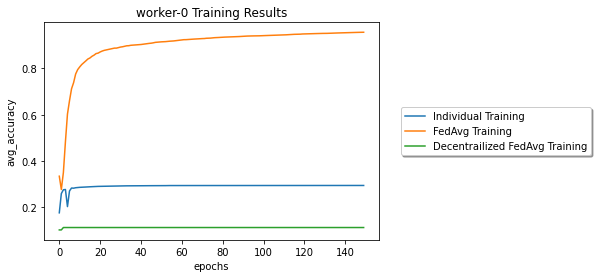

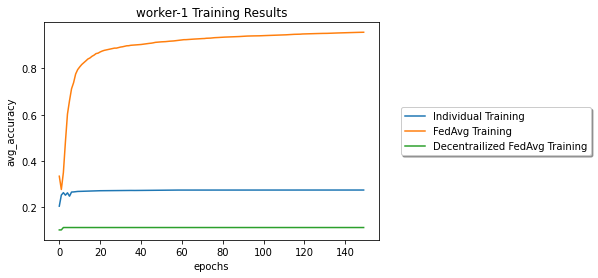

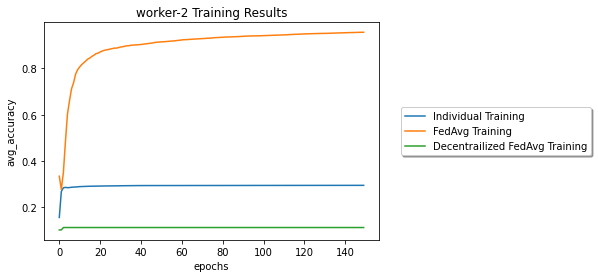

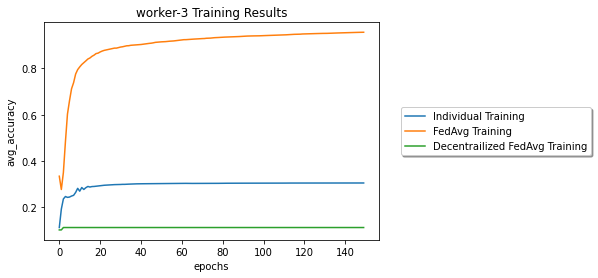

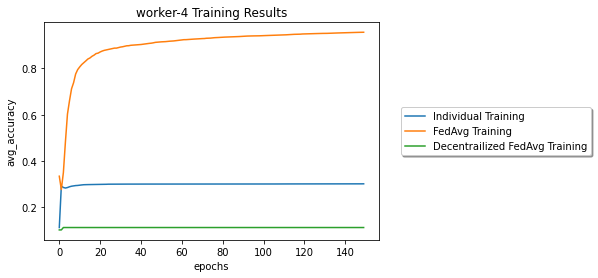

In [21]:
%matplotlib inline
ind_train_df
fedavg_train_df
decentrailized_fedavg_train_df
for node in compute_nodes[:5]:
    ind_worker_data  = ind_train_df[ind_train_df['worker_id']==node.id]
    plt.plot(ind_worker_data['epoch_idx'],ind_worker_data['avg_accuracy'], label="Individual Training")

    plt.plot(fedavg_train_df['epoch_idx'],fedavg_train_df['avg_accuracy'], label="FedAvg Training")
    
    decentral_worker_data  = decentrailized_fedavg_train_df[decentrailized_fedavg_train_df['worker_id']==node.id]
    plt.plot(decentral_worker_data['epoch_idx'],decentral_worker_data['avg_accuracy'], label="Decentrailized FedAvg Training")
    
    plt.xlabel('epochs')
    # Set the y axis label of the current axis.
    plt.ylabel('avg_accuracy')
    # Set a title of the current axes.
    plt.title(f'{node.id} Training Results')
    # show a legend on the plot
    plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), shadow=True)
    # Display a figure.
    plt.show()